In [2]:
!pip install tensorflow
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')
model_performance_df = pd.read_csv('/kaggle/input/model-performance/model_performance.csv')
nn_results_df = pd.read_csv('/kaggle/input/nn-performance/nn_results_Injury Rate.csv')
nn_pca13_results_df = pd.read_csv('/kaggle/input/pca13-nn/pca13_nn_results.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [4]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [5]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [6]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

# Perform standardisaion
scaler = MinMaxScaler()
outfield_X_train = scaler.fit_transform(outfield_X_train)
outfield_X_test = scaler.fit_transform(outfield_X_test)

goalkeeper_X_train = scaler.fit_transform(goalkeeper_X_train)
goalkeeper_X_test = scaler.fit_transform(goalkeeper_X_test)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

## PCA Analysis
PCA essentially creates as many principal components as there are features in our data. These components are arranged in order of importance, indicating how much of the PCA variance of our data is explained by each component. Typically we want to keep about 80% of the variance, and from the result below, the number of components that we should keep is around 12.5 to 15.

[0.17150201 0.12437322 0.10420449 0.07853144 0.07303621 0.05834568
 0.05260792 0.03377087 0.02874655 0.02640965 0.02360597 0.02200985
 0.0209873  0.02011761 0.01834238 0.01742599 0.01428694 0.01318348
 0.01205291 0.01053297]


Text(0, 0.5, 'Cumulative Explained Vairance')

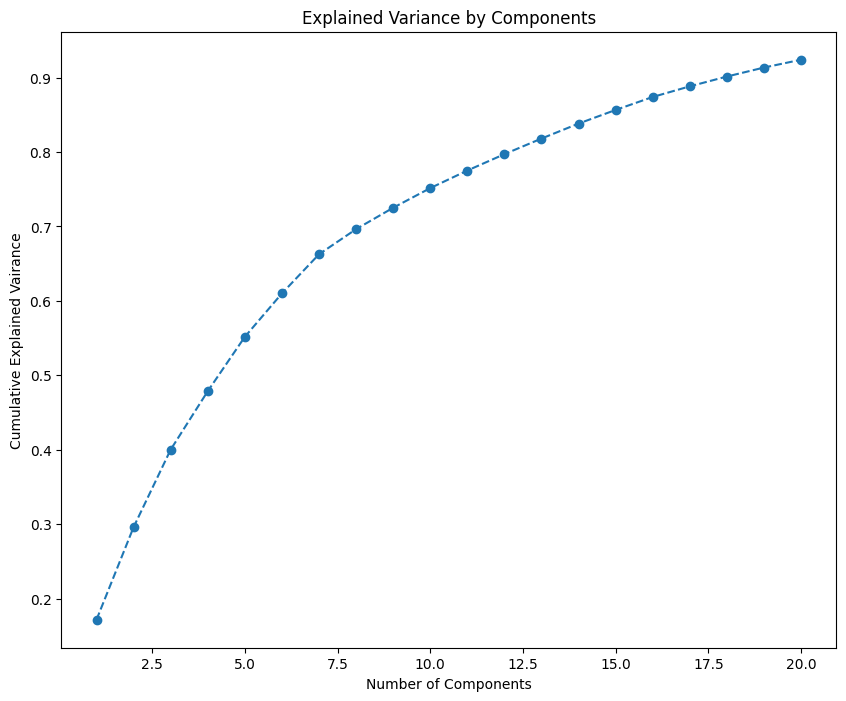

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(outfield_X_train)

explained_variance = pca.explained_variance_ratio_[:20].cumsum()
print(pca.explained_variance_ratio_[:20])

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = "o", linestyle = "--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Vairance")

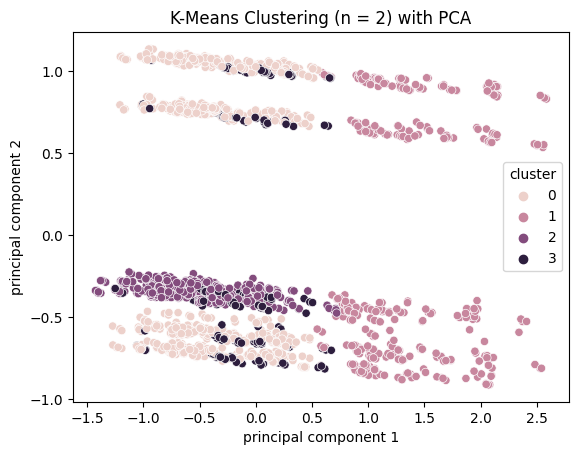

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
outfield_pca2_X_train = pca.fit_transform(outfield_X_train)
outfield_pca2_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca2_X_train, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

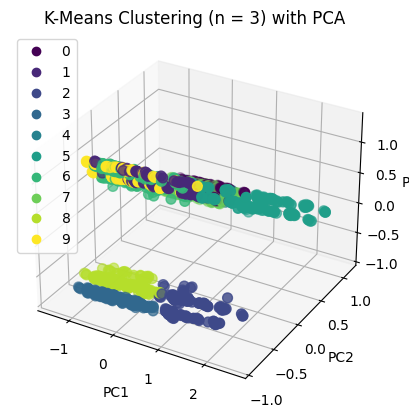

In [9]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
outfield_pca3_X_train = pca.fit_transform(outfield_X_train)
outfield_pca3_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca3_X_train, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

In [10]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_pca13_X_train = pca.fit_transform(outfield_X_train)
outfield_pca13_X_test = pca.transform(outfield_X_test)

# Training Different Regression Models
In the follow sections, we try to train different regression models on our data. To evaluate the performance of each regression mode, we can use several scores
* **Mean Squared Error (MSE)**
    * Formula: `MSE = Σ(y_true - y_pred)^2 / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average squared difference between predicted and actual values. Lower values indicate better performance.
    * Sensitivity: Sensitive to outliers due to squaring the errors.
* **Normalized Root Mean Squared Error (NRMSE)**
    * Formula: `NRMSE = RMSE / Mean(y_true)`
    * Range: 0 to infinity
    * Interpretation: Provides a relative measure of error, making it easier to compare models for different target variables. Lower NRMSE values indicate better model performance.
        * An NRMSE value of 1 indicates that the average prediction error is equal to the average value of the target variable.
        * An NRMSE value less than 1 suggests that the model's predictions are better than simply predicting the mean.
    * Sensitivity: Like MSE, sensitive to outliers.
* **Mean Absolute Error (MAE)**
    * Formula: `MAE = Σ|y_true - y_pred| / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average absolute difference between predicted and actual values. Less sensitive to outliers than MSE.
    * Sensitivity: Less sensitive to outliers compared to MSE.
* **R-squared (Coefficient of Determination)**
    * Formula: `R^2 = 1 - (SS_res / SS_tot)`
    * Range: -infinity to 1
    * Interpretation: Represents the proportion of variance in the dependent variable explained by the independent variables. Higher values indicate a better fit.
    * Negative R-squared: Indicates the model is performing worse than simply predicting the mean of the dependent variable.

In [11]:
evaluation_metrics = {'Model': [], 'Target': [], 'Mean Square Error': [], 'Mean Absolute Error': [], 'Normalized Root Mean Square Error': [], 'R-Squared Error': []}
def add_evaluation_metrics(model, target, mse, mae, nrmse, r2):
    evaluation_metrics['Model'].append(model)
    evaluation_metrics['Target'].append(target)
    evaluation_metrics['Mean Square Error'].append(mse)
    evaluation_metrics['Mean Absolute Error'].append(mae)
    evaluation_metrics['Normalized Root Mean Square Error'].append(nrmse)
    evaluation_metrics['R-Squared Error'].append(r2)

## Simple Linear Regression Model

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import numpy as np
from permetrics.regression import RegressionMetric

def normalized_root_mean_squared_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    evaluator = RegressionMetric(y_true, y_pred)
    return evaluator.normalized_root_mean_square_error()

targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(df_X, df_y, X_test, y_test, target):
    model = LinearRegression()
    model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(y_test[target], y_pred)

    print("Mean Squared Error for ", target, ":", mse)
          
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)
    
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    
    print("Mean Absolute Error for ", target, ":", mae)
          
    # Calculate the R-squared score
    r2 = r2_score(y_test[target], y_pred)

    print("R-squared for ", target, ":", r2, "\n")
    
    return (mse, mae, nrmse, r2)

print(colored('All features:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression', target, mse, mae, nrmse, r2)

print(colored('PCA Components with n = 2:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 2)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 3:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 3)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 13:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 13)', target, mse, mae, nrmse, r2)

All features:
Mean Squared Error for  Total Days : 3030.931202342048
Normalised Root Mean Squared Error for  Total Days : 1.783017462163986
Mean Absolute Error for  Total Days : 36.93273420479303
R-squared for  Total Days : 0.21897205417730392 

Mean Squared Error for  Total Games Missed : 56.79102307155501
Normalised Root Mean Squared Error for  Total Games Missed : 1.568959912062024
Mean Absolute Error for  Total Games Missed : 35.702682461873636
R-squared for  Total Games Missed : 0.25110361467390285 

Mean Squared Error for  Injury Count : 1.074276793236826
Normalised Root Mean Squared Error for  Injury Count : 1.8308346291928057
Mean Absolute Error for  Injury Count : 36.57511233660131
R-squared for  Injury Count : 0.1967344458233271 

Mean Squared Error for  Average Injury Cost : 0.018559103602989048
Normalised Root Mean Squared Error for  Average Injury Cost : 1.7595362315901577
Mean Absolute Error for  Average Injury Cost : 36.863572729439
R-squared for  Average Injury Cost : 0

## K Nearest Neighbours
* Hyperparameters that we can tune: K value, Distance Metrics

### Finding an estimate of the best distance metric
To find a suitable distance metric, we fix and arbitrary K value and iterate through some common metrics. The best metrics will be indicated by the lowest errors achieved.

In [13]:
from sklearn.neighbors import KNeighborsRegressor

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # You can add or remove metrics

# Create empty lists to store performance metrics
mse_scores = []
mae_scores = []
nrmse_scores = []
r2_scores = []

# Loop through each distance metric
for metric in metrics:
    knn_model = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_model.fit(outfield_X_train, outfield_y_train['Total Days'])
    y_pred = knn_model.predict(outfield_X_test)

    mse = mean_squared_error(outfield_y_test['Total Days'], y_pred)
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test['Total Days'], y_pred)
    r2 = r2_score(outfield_y_test['Total Days'], y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    nrmse_scores.append(nrmse)
    r2_scores.append(r2)

print(colored('Detailed Results:', 'black', attrs=['bold']))
for i, metric in enumerate(metrics):
    print(f"\nMetric: {metric}")
    print(f"MSE: {mse_scores[i]:.4f}")
    print(f"NRMSE: {nrmse_scores[i]:.4f}")
    print(f"MAE: {mae_scores[i]:.4f}")
    print(f"R-squared: {r2_scores[i]:.4f}")

Detailed Results:

Metric: euclidean
MSE: 3956.6825
NRMSE: 2.6835
MAE: 40.2745
R-squared: -0.0196

Metric: manhattan
MSE: 4123.5397
NRMSE: 2.5040
MAE: 41.1512
R-squared: -0.0626

Metric: minkowski
MSE: 3956.6825
NRMSE: 2.6835
MAE: 40.2745
R-squared: -0.0196

Metric: cosine
MSE: 3853.0743
NRMSE: 2.7038
MAE: 39.4318
R-squared: 0.0071

Metric: chebyshev
MSE: 3746.1045
NRMSE: 2.5477
MAE: 40.8458
R-squared: 0.0347


### Finding the best K Value for each target
Given a suitable distance metric, to find the best K value we can plot a graph of K against the error (NRMSE). The most suitable value of K will be at the 'elbow point'.

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def get_knn_error_rates(df_X, df_y, X_test, y_test, target, k=None):
    # Define a range of k values if k is not provided
    neighbors = np.arange(1, 50) if k is None else [k]

    # Create an empty list to store error values
    error_rates = []

    # Loop over k values
    for i in neighbors:
        knn = KNeighborsRegressor(n_neighbors=i, metric='chebyshev')
        knn.fit(df_X, df_y[target])
        y_pred = knn.predict(X_test)
        error = normalized_root_mean_squared_error(y_test[target], y_pred)
        error_rates.append(error)

    # Create a DataFrame to hold the results
    error_df = pd.DataFrame({'k': neighbors, 'error': error_rates})

    # Find the k value with the lowest error (if k is not provided)
    if k is None:
        best_k = error_df.loc[error_df['error'].idxmin(), 'k']
    else:
        best_k = k

    # Create a line plot using Seaborn
    sns.lineplot(x='k', y='error', data=error_df, marker='o')
    plt.title(f'K-Nearest Neighbors: Error Rate vs. K Value for {target}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Normalized Root Mean Squared Error')
    plt.show()

    return best_k, error_df

def get_best_knn_error_rates(df_X, df_y, X_test, y_test, target, k):
    knn = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(df_X, df_y[target])
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(outfield_y_test[target], y_pred)
    mae = mean_absolute_error(outfield_y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test[target], y_pred)
    r2 = r2_score(outfield_y_test[target], y_pred)
    
    print("Mean Squared Error for ", target, ":", mse)          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)    
    print("Mean Absolute Error for ", target, ":", mae)
    print("R-squared for ", target, ":", r2, "\n")

    return mse, mae, nrmse, r2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


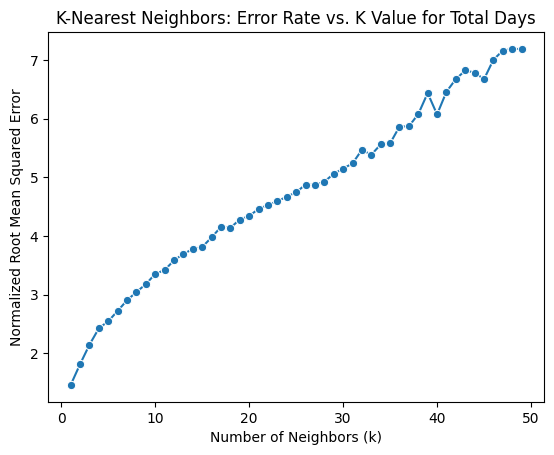

Best K:  1
Smallest Normalised Root MSE:  1.463407456706217
Mean Squared Error for  Total Days : 5393.664488017429
Normalised Root Mean Squared Error for  Total Days : 1.463407456706217
Mean Absolute Error for  Total Days : 45.26797385620915
R-squared for  Total Days : -0.38987077379979196 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


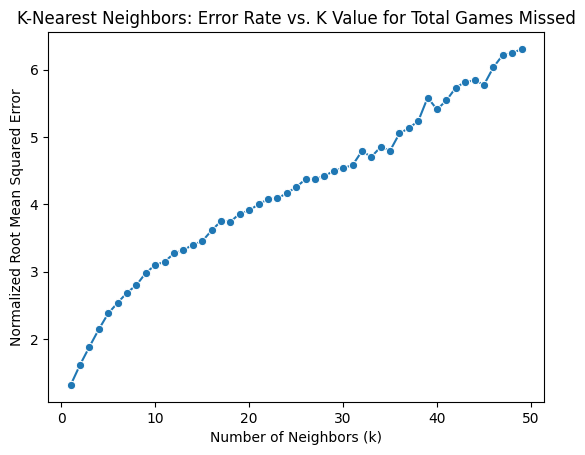

Best K:  1
Smallest Normalised Root MSE:  1.3158491465211162
Mean Squared Error for  Total Games Missed : 109.2156862745098
Normalised Root Mean Squared Error for  Total Games Missed : 1.3158491465211162
Mean Absolute Error for  Total Games Missed : 6.627450980392157
R-squared for  Total Games Missed : -0.4402141086423974 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


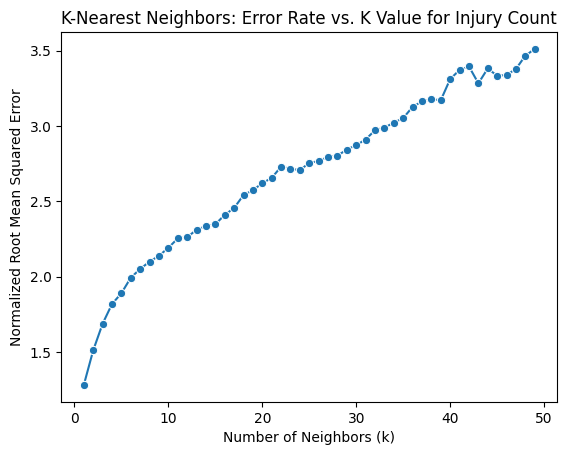

Best K:  1
Smallest Normalised Root MSE:  1.282483154374625
Mean Squared Error for  Injury Count : 2.289760348583878
Normalised Root Mean Squared Error for  Injury Count : 1.282483154374625
Mean Absolute Error for  Injury Count : 1.065359477124183
R-squared for  Injury Count : -0.71211518941518 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


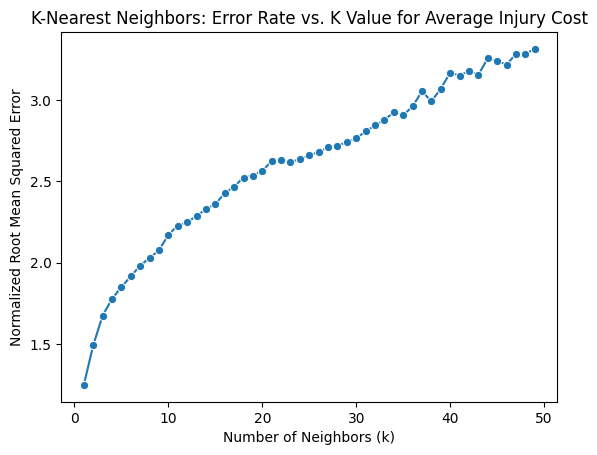

Best K:  1
Smallest Normalised Root MSE:  1.2482278827868813
Mean Squared Error for  Average Injury Cost : 0.039957298474945536
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2482278827868813
Mean Absolute Error for  Average Injury Cost : 0.1343790849673203
R-squared for  Average Injury Cost : -0.855107146416078 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


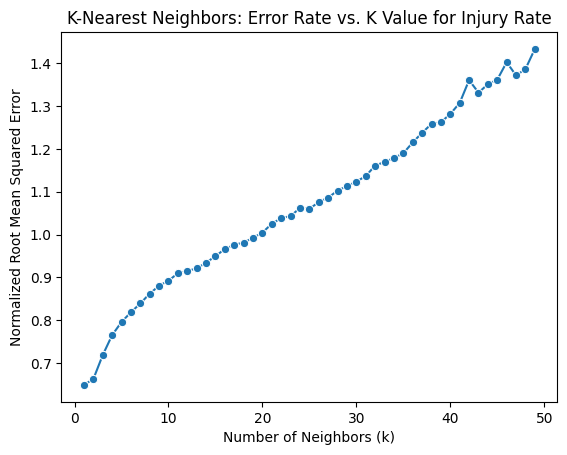

Best K:  1
Smallest Normalised Root MSE:  0.6494357818674312
Mean Squared Error for  Injury Rate : 5.378254422983413e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.6494357818674312
Mean Absolute Error for  Injury Rate : 0.00011379928850497413
R-squared for  Injury Rate : 0.5583341171508474 



In [15]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


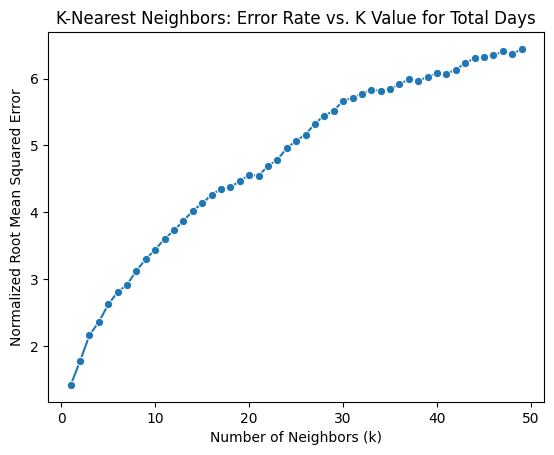

Best K:  1
Smallest Normalised Root MSE:  1.42032992212971
Mean Squared Error for  Total Days : 5466.300653594772
Normalised Root Mean Squared Error for  Total Days : 1.42032992212971
Mean Absolute Error for  Total Days : 44.074074074074076
R-squared for  Total Days : -0.40858808257587764 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


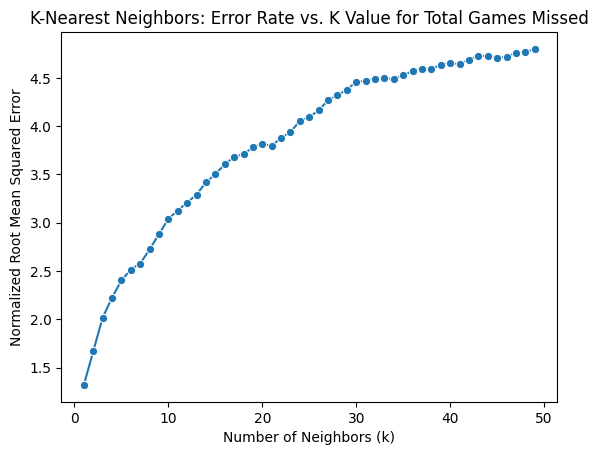

Best K:  1
Smallest Normalised Root MSE:  1.321669498773408
Mean Squared Error for  Total Games Missed : 110.29193899782135
Normalised Root Mean Squared Error for  Total Games Missed : 1.321669498773408
Mean Absolute Error for  Total Games Missed : 6.4880174291939
R-squared for  Total Games Missed : -0.4544065237564878 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


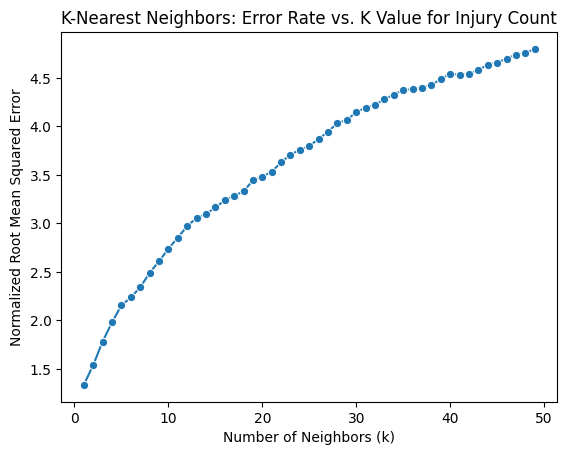

Best K:  1
Smallest Normalised Root MSE:  1.3339322500245385
Mean Squared Error for  Injury Count : 2.5577342047930283
Normalised Root Mean Squared Error for  Injury Count : 1.3339322500245385
Mean Absolute Error for  Injury Count : 1.1285403050108933
R-squared for  Injury Count : -0.9124864247130555 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


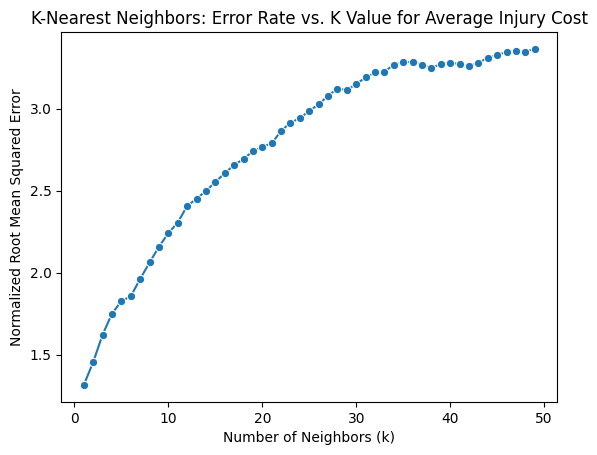

Best K:  1
Smallest Normalised Root MSE:  1.316061391785316
Mean Squared Error for  Average Injury Cost : 0.039949891067538115
Normalised Root Mean Squared Error for  Average Injury Cost : 1.316061391785316
Mean Absolute Error for  Average Injury Cost : 0.139041394335512
R-squared for  Average Injury Cost : -0.8547632409234045 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


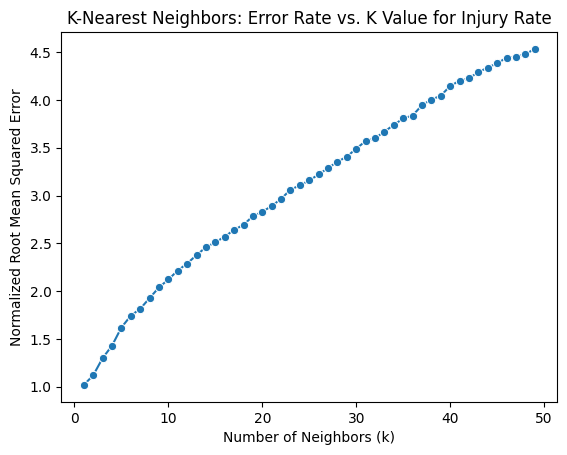

Best K:  1
Smallest Normalised Root MSE:  1.0175959102076184
Mean Squared Error for  Injury Rate : 1.2688900118055047e-07
Normalised Root Mean Squared Error for  Injury Rate : 1.0175959102076184
Mean Absolute Error for  Injury Rate : 0.00019560084185882333
R-squared for  Injury Rate : -0.04202104107910909 



In [16]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 2)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


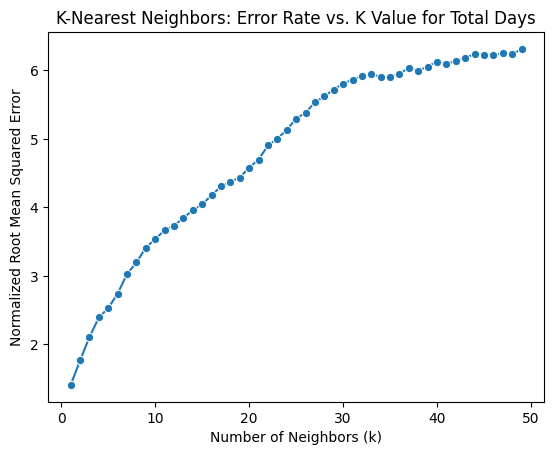

Best K:  1
Smallest Normalised Root MSE:  1.4094830724557386
Mean Squared Error for  Total Days : 5667.93899782135
Normalised Root Mean Squared Error for  Total Days : 1.4094830724557386
Mean Absolute Error for  Total Days : 45.18082788671024
R-squared for  Total Days : -0.46054742156340867 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


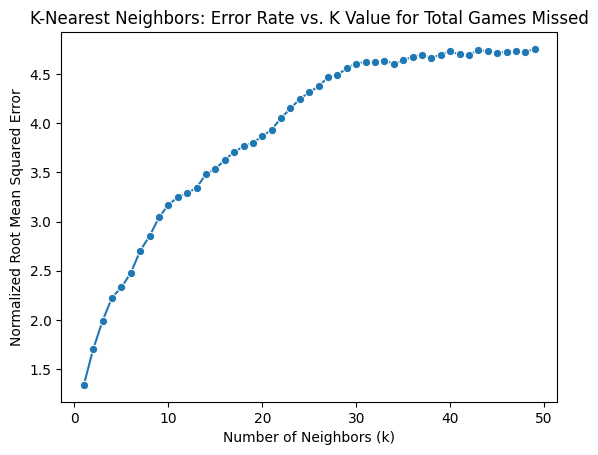

Best K:  1
Smallest Normalised Root MSE:  1.3374922562650036
Mean Squared Error for  Total Games Missed : 110.90631808278867
Normalised Root Mean Squared Error for  Total Games Missed : 1.3374922562650036
Mean Absolute Error for  Total Games Missed : 6.4793028322440085
R-squared for  Total Games Missed : -0.4625082667973248 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


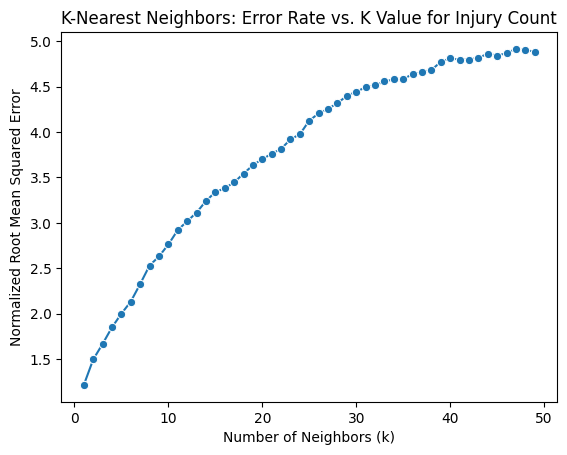

Best K:  1
Smallest Normalised Root MSE:  1.2150591134074258
Mean Squared Error for  Injury Count : 2.241830065359477
Normalised Root Mean Squared Error for  Injury Count : 1.2150591134074258
Mean Absolute Error for  Injury Count : 1.0479302832244008
R-squared for  Injury Count : -0.6762764318822265 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


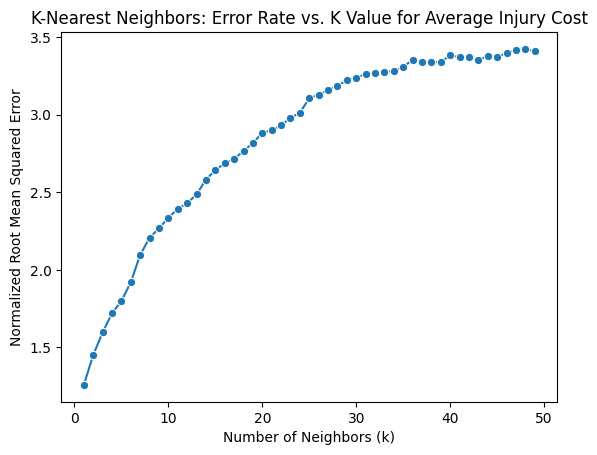

Best K:  1
Smallest Normalised Root MSE:  1.2579932193292696
Mean Squared Error for  Average Injury Cost : 0.03522657952069717
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2579932193292696
Mean Absolute Error for  Average Injury Cost : 0.12949891067538125
R-squared for  Average Injury Cost : -0.6354729150073914 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


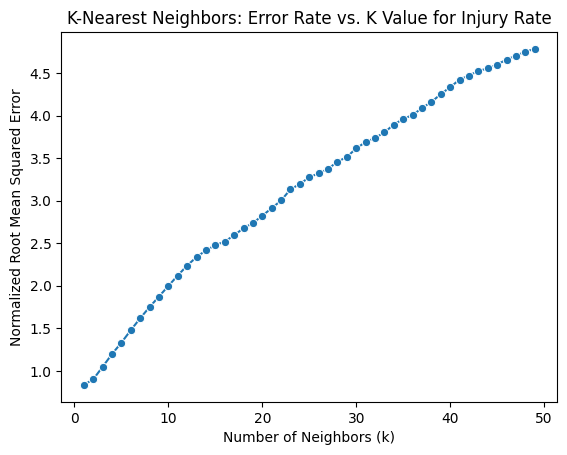

Best K:  1
Smallest Normalised Root MSE:  0.8339462742648468
Mean Squared Error for  Injury Rate : 8.570558458473883e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.8339462742648468
Mean Absolute Error for  Injury Rate : 0.00012952235721745548
R-squared for  Injury Rate : 0.29617995535950226 



In [17]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 3)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


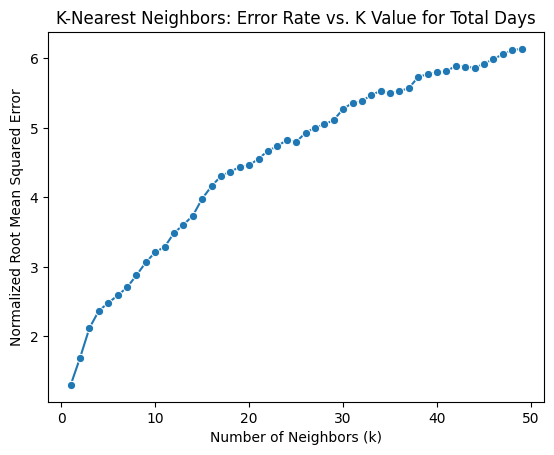

Best K:  1
Smallest Normalised Root MSE:  1.302808349950549
Mean Squared Error for  Total Days : 5658.311546840959
Normalised Root Mean Squared Error for  Total Days : 1.302808349950549
Mean Absolute Error for  Total Days : 44.89978213507625
R-squared for  Total Days : -0.45806656411045354 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


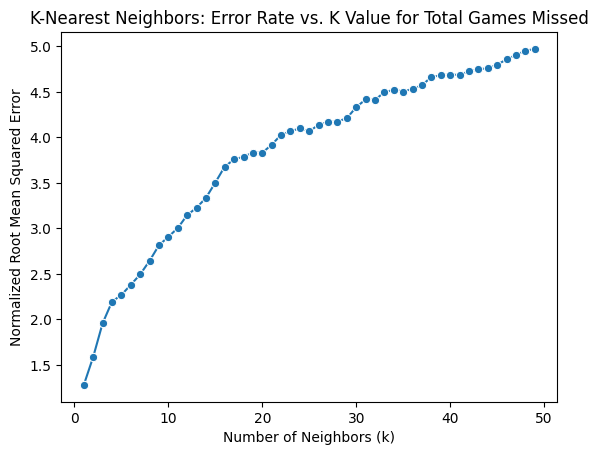

Best K:  1
Smallest Normalised Root MSE:  1.2800442150037845
Mean Squared Error for  Total Games Missed : 123.0479302832244
Normalised Root Mean Squared Error for  Total Games Missed : 1.2800442150037845
Mean Absolute Error for  Total Games Missed : 6.690631808278867
R-squared for  Total Games Missed : -0.6226182454022335 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


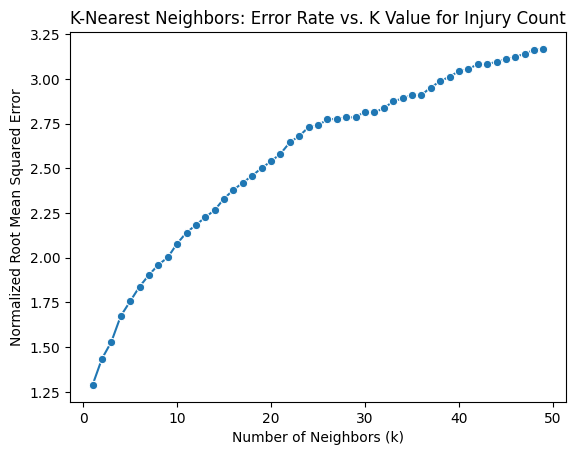

Best K:  1
Smallest Normalised Root MSE:  1.2890621571760363
Mean Squared Error for  Injury Count : 2.156862745098039
Normalised Root Mean Squared Error for  Injury Count : 1.2890621571760363
Mean Absolute Error for  Injury Count : 1.0065359477124183
R-squared for  Injury Count : -0.6127440889829003 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


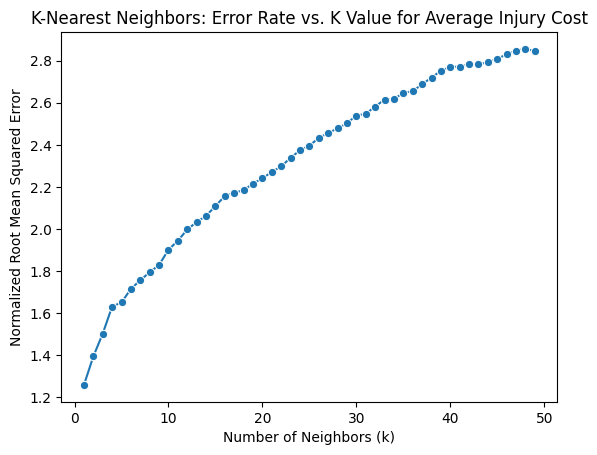

Best K:  1
Smallest Normalised Root MSE:  1.257931386231308
Mean Squared Error for  Average Injury Cost : 0.03620915032679739
Normalised Root Mean Squared Error for  Average Injury Cost : 1.257931386231308
Mean Absolute Error for  Average Injury Cost : 0.12549019607843137
R-squared for  Average Injury Cost : -0.681090967123684 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


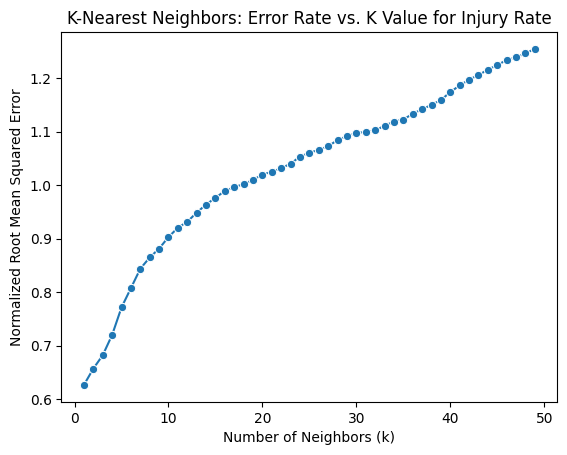

Best K:  1
Smallest Normalised Root MSE:  0.6264544245501514
Mean Squared Error for  Injury Rate : 5.1123980954537564e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.6264544245501514
Mean Absolute Error for  Injury Rate : 9.915911669673644e-05
R-squared for  Injury Rate : 0.5801664181865958 



In [18]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 13)', target, mse, mae, nrmse, r2)

## Decision Tree

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def get_decision_tree_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a decision tree model
    dt_model = DecisionTreeRegressor()

    # Fit the model to the training data
    dt_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Decision Tree Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [20]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5866.257080610022
MAE: 45.760348583878
NRMSE: 1.2988058723107894
R-squared: -0.5116511763105449 

Decision Tree Errors for Total Games Missed:
MSE: 106.40522875816994
MAE: 6.4793028322440085
NRMSE: 1.16047016966009
R-squared: -0.4031529436683561 

Decision Tree Errors for Injury Count:
MSE: 1.9237472766884531
MAE: 1.0043572984749456
NRMSE: 1.1899095411657161
R-squared: -0.43843740461808167 

Decision Tree Errors for Average Injury Cost:
MSE: 0.037555991285403045
MAE: 0.12618736383442267
NRMSE: 1.2033304477102984
R-squared: -0.7436210775855285 

Decision Tree Errors for Injury Rate:
MSE: 9.76337181310176e-14
MAE: 1.4584568062197205e-08
NRMSE: 0.0008954294923019665
R-squared: 0.9999991982253177 



In [21]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6232.9825708061
MAE: 48.372549019607845
NRMSE: 1.476691218095312
R-squared: -0.6061511293505022 

Decision Tree Errors for Total Games Missed:
MSE: 126.93899782135077
MAE: 7.021786492374727
NRMSE: 1.3871463518989167
R-squared: -0.6739292846608675 

Decision Tree Errors for Injury Count:
MSE: 2.7712418300653594
MAE: 1.1938997821350763
NRMSE: 1.371624452369543
R-squared: -1.0721317991780293 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03642701525054466
MAE: 0.13477124183006536
NRMSE: 1.2788636011731522
R-squared: -0.6912058345552341 

Decision Tree Errors for Injury Rate:
MSE: 1.517923338325208e-07
MAE: 0.00024532517492160163
NRMSE: 1.1585579948486062
R-squared: -0.2465288894734825 



In [22]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6422.034858387799
MAE: 48.64052287581699
NRMSE: 1.2849894344855834
R-squared: -0.6548672202036765 

Decision Tree Errors for Total Games Missed:
MSE: 132.48583877995642
MAE: 7.078431372549019
NRMSE: 1.4011836230757075
R-squared: -0.7470748087104095 

Decision Tree Errors for Injury Count:
MSE: 2.337690631808279
MAE: 1.0392156862745099
NRMSE: 1.3547483811937016
R-squared: -0.7479539469481333 

Decision Tree Errors for Average Injury Cost:
MSE: 0.04063093681917211
MAE: 0.14296296296296299
NRMSE: 1.3015693780693607
R-squared: -0.8863823165144316 

Decision Tree Errors for Injury Rate:
MSE: 9.868602149665705e-08
MAE: 0.00015723088968207913
NRMSE: 0.9264067666338883
R-squared: 0.18958373142538265 



In [23]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5897.993464052288
MAE: 47.87581699346405
NRMSE: 1.254168237625982
R-squared: -0.5198291918156812 

Decision Tree Errors for Total Games Missed:
MSE: 118.11546840958606
MAE: 6.930283224400871
NRMSE: 1.3647825543500447
R-squared: -0.5575744643935285 

Decision Tree Errors for Injury Count:
MSE: 1.8867102396514162
MAE: 0.9455337690631809
NRMSE: 1.2606147873898923
R-squared: -0.4107438192517088 

Decision Tree Errors for Average Injury Cost:
MSE: 0.0347764705882353
MAE: 0.12531590413943355
NRMSE: 1.1897658767483241
R-squared: -0.6145755988938082 

Decision Tree Errors for Injury Rate:
MSE: 1.2146264609860153e-08
MAE: 3.26023610009957e-05
NRMSE: 0.3228086396945761
R-squared: 0.9002540553063411 



## Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

def get_random_forest_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a random forest model
    rf_model = RandomForestRegressor(n_estimators=100)
      # Adjust n_estimators as needed

    # Fit the model to the training data
    rf_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Random Forest Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [25]:
for target in targets:
    mse, mae, nrmse, r2 = get_random_forest_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest', target, mse, mae, nrmse, r2)

Random Forest Errors for Total Days:
MSE: 3016.2058239651415
MAE: 36.187625272331154
NRMSE: 1.7285502808501165
R-squared: 0.2227665751536595 

Random Forest Errors for Total Games Missed:
MSE: 54.39760108932462
MAE: 5.114923747276689
NRMSE: 1.554200550137849
R-squared: 0.28266538225808535 

Random Forest Errors for Injury Count:
MSE: 1.056757734204793
MAE: 0.7942483660130719
NRMSE: 1.679850833046114
R-squared: 0.20983391585806477 

Random Forest Errors for Average Injury Cost:
MSE: 0.018015744705882353
MAE: 0.10307015250544663
NRMSE: 1.643401772130071
R-squared: 0.16357866954278555 

Random Forest Errors for Injury Rate:
MSE: 6.586974836540783e-11
MAE: 4.0829427548914184e-07
NRMSE: 0.023259714413965276
R-squared: 0.9994590731810579 



In [26]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5891.4553376906315
MAE: 47.128540305010894
NRMSE: 1.4597588671545858
R-squared: -0.5181444094630407 

Decision Tree Errors for Total Games Missed:
MSE: 121.18518518518519
MAE: 6.788671023965142
NRMSE: 1.4332269116332557
R-squared: -0.598054450012462 

Decision Tree Errors for Injury Count:
MSE: 2.8191721132897603
MAE: 1.2113289760348585
NRMSE: 1.3599858622617844
R-squared: -1.1079705567109825 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03729455337690632
MAE: 0.13429193899782135
NRMSE: 1.256727953171194
R-squared: -0.7314832366676682 

Decision Tree Errors for Injury Rate:
MSE: 1.4803766275423076e-07
MAE: 0.00024275611210787914
NRMSE: 1.1674997840131291
R-squared: -0.21569527718629633 



In [27]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5833.315904139434
MAE: 46.64488017429194
NRMSE: 1.2862549087730848
R-squared: -0.5031627027444256 

Decision Tree Errors for Total Games Missed:
MSE: 131.75381263616558
MAE: 7.074074074074074
NRMSE: 1.4161785591484757
R-squared: -0.7374216680660082 

Decision Tree Errors for Injury Count:
MSE: 2.4422657952069717
MAE: 1.0784313725490196
NRMSE: 1.3481007189190952
R-squared: -0.8261475997473042 

Decision Tree Errors for Average Injury Cost:
MSE: 0.036843355119825706
MAE: 0.1381917211328976
NRMSE: 1.2907513518611278
R-squared: -0.7105353462169268 

Decision Tree Errors for Injury Rate:
MSE: 1.0765786789954129e-07
MAE: 0.00016445416181070133
NRMSE: 0.9916188222362148
R-squared: 0.11590632328003203 



In [28]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6103.755991285403
MAE: 47.89978213507625
NRMSE: 1.2430743293572115
R-squared: -0.5728512742199225 

Decision Tree Errors for Total Games Missed:
MSE: 119.8322440087146
MAE: 6.904139433551198
NRMSE: 1.3824410158715803
R-squared: -0.58021337757147 

Decision Tree Errors for Injury Count:
MSE: 1.9411764705882353
MAE: 0.9433551198257081
NRMSE: 1.2441249349379733
R-squared: -0.4514696800846103 

Decision Tree Errors for Average Injury Cost:
MSE: 0.035068845315904144
MAE: 0.12666666666666668
NRMSE: 1.1835325361191775
R-squared: -0.6281497509869489 

Decision Tree Errors for Injury Rate:
MSE: 1.2156309626030637e-08
MAE: 3.368781242172119e-05
NRMSE: 0.32116337623676827
R-squared: 0.9001715649556389 



## Gradient Boosting

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor

def get_xGboost_error_rates(df_X, df_y, X_test, y_test, target):
    xG_model = HistGradientBoostingRegressor()
    
    # Fit the model to the training data
    xG_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = xG_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Gradient Boost Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [32]:
for target in targets:
    mse, mae, nrmse, r2 = get_xGboost_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Gradient Boosting', target, mse, mae, nrmse, r2)

Gradient Boost Errors for Total Days:
MSE: 3423.0091214732597
MAE: 36.5428155706306
NRMSE: 1.699736427423521
R-squared: 0.11793914008645834 

Gradient Boost Errors for Total Games Missed:
MSE: 62.487647706212705
MAE: 5.1808334063452905
NRMSE: 1.5080737705565825
R-squared: 0.17598291131767907 

Gradient Boost Errors for Injury Count:
MSE: 1.147289281295069
MAE: 0.8196845944441231
NRMSE: 1.575486844173663
R-squared: 0.1421410514103164 

Gradient Boost Errors for Average Injury Cost:
MSE: 0.018636370639123552
MAE: 0.10225567570433348
NRMSE: 1.547830806759899
R-squared: 0.1347647194523205 

Gradient Boost Errors for Injury Rate:
MSE: 9.639688873886979e-11
MAE: 2.3861653214674555e-06
NRMSE: 0.02814029889614174
R-squared: 0.9992083822441196 



In [33]:
for target in targets:
    mse, mae, nrmse, r2 = get_xGboost_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Gradient Boosting (PCA n = 2)', target, mse, mae, nrmse, r2)

Gradient Boost Errors for Total Days:
MSE: 4108.034567415503
MAE: 43.10017037795999
NRMSE: 2.8966531020829116
R-squared: -0.058582193181391906 

Gradient Boost Errors for Total Games Missed:
MSE: 79.59060665230118
MAE: 6.25819639838892
NRMSE: 2.608921894722666
R-squared: -0.04955174962632536 

Gradient Boost Errors for Injury Count:
MSE: 1.5178906612483458
MAE: 0.9543457402690787
NRMSE: 2.5376932146670557
R-squared: -0.13496753431073993 

Gradient Boost Errors for Average Injury Cost:
MSE: 0.02388749307517804
MAE: 0.12105895262032987
NRMSE: 2.1812612469767556
R-squared: -0.10903041008924852 

Gradient Boost Errors for Injury Rate:
MSE: 9.01592545841665e-08
MAE: 0.00023535367160407454
NRMSE: 1.7169618944019638
R-squared: 0.25960611675844814 



In [34]:
for target in targets:
    mse, mae, nrmse, r2 = get_xGboost_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Gradient Boosting (PCA n = 3)', target, mse, mae, nrmse, r2)

Gradient Boost Errors for Total Days:
MSE: 3974.1944917971173
MAE: 42.514203296920975
NRMSE: 2.752265526261181
R-squared: -0.024093505596464837 

Gradient Boost Errors for Total Games Missed:
MSE: 77.71669366935127
MAE: 6.246277073743979
NRMSE: 2.5881219389337904
R-squared: -0.02484068468251155 

Gradient Boost Errors for Injury Count:
MSE: 1.448779347288035
MAE: 0.9373530269674849
NRMSE: 2.3779014812052695
R-squared: -0.08329115234130402 

Gradient Boost Errors for Average Injury Cost:
MSE: 0.0239053093600735
MAE: 0.12046441323667108
NRMSE: 2.068110990080412
R-squared: -0.10985757105091531 

Gradient Boost Errors for Injury Rate:
MSE: 7.201777997843598e-08
MAE: 0.00019586055366612037
NRMSE: 1.3639387155920342
R-squared: 0.40858513053817913 



In [35]:
for target in targets:
    mse, mae, nrmse, r2 = get_xGboost_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Gradient Boosting (PCA n = 13)', target, mse, mae, nrmse, r2)

Gradient Boost Errors for Total Days:
MSE: 3488.742787950735
MAE: 38.95566314847584
NRMSE: 1.800400458705972
R-squared: 0.10100050734526456 

Gradient Boost Errors for Total Games Missed:
MSE: 64.64216645305284
MAE: 5.495992156137439
NRMSE: 1.6484364146158406
R-squared: 0.1475715319418769 

Gradient Boost Errors for Injury Count:
MSE: 1.2244899242744103
MAE: 0.8299296751065501
NRMSE: 1.6420087841730249
R-squared: 0.0844160612997602 

Gradient Boost Errors for Average Injury Cost:
MSE: 0.020560186928120925
MAE: 0.10799593615261398
NRMSE: 1.5572897880094567
R-squared: 0.045447235980596745 

Gradient Boost Errors for Injury Rate:
MSE: 5.959966184135704e-09
MAE: 4.71628832597259e-05
NRMSE: 0.232983213105875
R-squared: 0.9510563554743995 



## Voting regressor
The idea behind the VotingRegressor is to combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [36]:
from sklearn.ensemble import VotingRegressor

def get_voting_error_rates(df_X, df_y, X_test, y_test, target):
    # Create individual models
    rf_model = RandomForestRegressor(n_estimators=100)
    lr_model = LinearRegression()
    xg_model = HistGradientBoostingRegressor()

    # Create a VotingRegressor
    voting_model = VotingRegressor(estimators=[('rf', rf_model), ('lr', lr_model), ('xg', xg_model)])

    # Fit the voting model to the training data
    voting_model.fit(df_X, df_y[target])

    # Make predictions
    y_pred = voting_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Voting Regressor Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [37]:
for target in targets:
    mse, mae, nrmse, r2 = get_voting_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Voting Regressor', target, mse, mae, nrmse, r2)

Voting Regressor Errors for Total Days:
MSE: 2987.4248278262103
MAE: 35.2380402755817
NRMSE: 1.8486404860415149
R-squared: 0.23018302930337775 

Voting Regressor Errors for Total Games Missed:
MSE: 54.822038981370376
MAE: 5.068334307567086
NRMSE: 1.624211997749818
R-squared: 0.27706837086514036 

Voting Regressor Errors for Injury Count:
MSE: 1.0328842542915582
MAE: 0.7790061247494515
NRMSE: 1.7873776701488868
R-squared: 0.2276847567152429 

Voting Regressor Errors for Average Injury Cost:
MSE: 0.017104665663814855
MAE: 0.09948068651781318
NRMSE: 1.743997390273153
R-squared: 0.2058775562642966 

Voting Regressor Errors for Injury Rate:
MSE: 4.513428351193329e-09
MAE: 5.2077184027017023e-05
NRMSE: 0.21534986505405448
R-squared: 0.962935421781322 



In [38]:
for target in targets:
    mse, mae, nrmse, r2 = get_voting_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Voting Regressor (PCA n = 2)', target, mse, mae, nrmse, r2)

Voting Regressor Errors for Total Days:
MSE: 3953.895727995511
MAE: 42.47380820925035
NRMSE: 3.902816217779327
R-squared: -0.018862802312121785 

Voting Regressor Errors for Total Games Missed:
MSE: 75.12467947318919
MAE: 6.142372335405954
NRMSE: 3.420577189455966
R-squared: 0.00933989452230266 

Voting Regressor Errors for Injury Count:
MSE: 1.4105834893625373
MAE: 0.9209038744430567
NRMSE: 3.3139971694759254
R-squared: -0.054731085534559965 

Voting Regressor Errors for Average Injury Cost:
MSE: 0.021641446885619506
MAE: 0.1164021532053543
NRMSE: 2.7863224446629045
R-squared: -0.00475268120216521 

Voting Regressor Errors for Injury Rate:
MSE: 9.027216269662293e-08
MAE: 0.00024125109256639893
NRMSE: 2.399404032294478
R-squared: 0.2586789077191026 



In [39]:
for target in targets:
    mse, mae, nrmse, r2 = get_voting_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Voting Regressor (PCA n = 3)', target, mse, mae, nrmse, r2)

Voting Regressor Errors for Total Days:
MSE: 3842.9059268161595
MAE: 41.86131678495211
NRMSE: 3.852734705118529
R-squared: 0.009737693916692325 

Voting Regressor Errors for Total Games Missed:
MSE: 72.96927804856333
MAE: 6.114243695074399
NRMSE: 3.3958775659157667
R-squared: 0.03776291366381768 

Voting Regressor Errors for Injury Count:
MSE: 1.3385618364675247
MAE: 0.895643986714985
NRMSE: 3.110638498804718
R-squared: -0.0008785651323262034 

Voting Regressor Errors for Average Injury Cost:
MSE: 0.021403139924558934
MAE: 0.11508526322147712
NRMSE: 2.6050378071936113
R-squared: 0.006311253632702796 

Voting Regressor Errors for Injury Rate:
MSE: 7.128597134015425e-08
MAE: 0.00020827074919512145
NRMSE: 1.954592959556744
R-squared: 0.41459479246347064 



In [40]:
for target in targets:
    mse, mae, nrmse, r2 = get_voting_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Voting Regressor (PCA n = 13)', target, mse, mae, nrmse, r2)

Voting Regressor Errors for Total Days:
MSE: 3295.66528657414
MAE: 38.525981548838566
NRMSE: 2.39613880254898
R-squared: 0.150753838654209 

Voting Regressor Errors for Total Games Missed:
MSE: 62.61598403604595
MAE: 5.55457749996373
NRMSE: 2.1837489557549934
R-squared: 0.17429055558397377 

Voting Regressor Errors for Injury Count:
MSE: 1.1415715775353055
MAE: 0.817017165299794
NRMSE: 2.0190489562301965
R-squared: 0.14641633177392388 

Voting Regressor Errors for Average Injury Cost:
MSE: 0.018702935232831803
MAE: 0.10504802790558329
NRMSE: 1.87070755043618
R-squared: 0.1316743089841581 

Voting Regressor Errors for Injury Rate:
MSE: 1.4081807856884693e-08
MAE: 8.94073840742025e-05
NRMSE: 0.43234982900599517
R-squared: 0.8843592435373656 



## Neural Network
Hyperparameter to tune
* Loss function
* Hidden layers (Neurons per hidden layer)
* Batch size
* Epoch
* Optimizer
* Activation function

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

results = {
    "Model": [],
    "Target": [],
    "Loss Function": [],
    "Activation Function": [],
    "Optimizer": [],
    "Hidden Layers": [],
    "Epochs": [],
    "Batch Size": [],
    "Neurons per hidden layer": [],
    "MSE": [],
    "MAE": [],
    "NRMSE": [],
    "R-squared": []
}

hyperparameter_grid = {
    'loss_functions': ['mean_squared_error', 'mean_absolute_error', 'huber', 'log_cosh'],
    'activation_functions': ['relu', 'sigmoid', 'tanh'],
    'optimizers': ['SGD', 'adam'],
    'hidden_layers': [1, 2],  # Number of hidden layers
    'epochs': [50, 100, 200],  # Training epochs
    'batch_size': [64, 128],  # Batch size
    'neurons_per_layer': [32]
}

def get_nn_error_rates(model_name, df_X, df_y, X_test, y_test, target):
    # Loop through different loss functions
    for loss_func in hyperparameter_grid['loss_functions']:
        for activation_function in hyperparameter_grid['activation_functions']:
            for optimizer in hyperparameter_grid['optimizers']:
                for hidden_layers in hyperparameter_grid['hidden_layers']:
                    for epochs in hyperparameter_grid['epochs']:
                        for batch_size in hyperparameter_grid['batch_size']:
                            for neurons_per_layer in hyperparameter_grid['neurons_per_layer']:
                                print(f"Loss function: {loss_func}, Activation Function: {activation_function}, Optimizer: {optimizer}, Hidden layers: {hidden_layers}, Epochs: {epochs}, Batch size: {batch_size}, Neurons per layer: {neurons_per_layer}")

                                # Create the model
                                model = Sequential()
                                model.add(Input(shape=(df_X.shape[1],)))

                                for _ in range(hidden_layers):
                                    model.add(Dense(neurons_per_layer, activation='relu'))

                                model.add(Dense(1)) # output layer

                                model.compile(loss=loss_func, optimizer='adam')

                                model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)

                                # Evaluate on validation set (optional)
                                val_loss = model.evaluate(df_X, df_y, verbose=0)
                                print(f"Training Loss: {val_loss}")

                                # Evaluate on test set
                                y_pred = model.predict(X_test)

                                mse = mean_squared_error(y_test[target], y_pred)
                                mae = mean_absolute_error(y_test[target], y_pred)
                                nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
                                r2 = r2_score(y_test[target], y_pred)

                                # Print performance metrics
                                print(f"Test Set Performance ({loss_func}):")
                                print("MSE:", mse)
                                print("MAE:", mae)
                                print("NRMSE:", nrmse)
                                print("R-squared:", r2, '\n')

                                # Prepare data for visualization (optional)
                                results['Model'].append(model_name)
                                results['Target'].append(target)
                                results['Loss Function'].append(loss_func)
                                results['Activation Function'].append(activation_function)
                                results['Optimizer'].append(optimizer)
                                results['Hidden Layers'].append(hidden_layers)
                                results['Epochs'].append(epochs)
                                results['Batch Size'].append(batch_size)
                                results['Neurons per hidden layer'].append(neurons_per_layer)

                                results['MSE'].append(mse)
                                results['MAE'].append(mae)
                                results['NRMSE'].append(nrmse)
                                results['R-squared'].append(r2)

    return pd.DataFrame(results)
    
def create_nn_performance_chart(results_df, x_metric, y_metric):
    # Create Seaborn bar plot
    sns.barplot(x=x_metric, y=y_metric, data=results_df)
    plt.title(f'Neural Network Performance by {y_metric} against {x_metric}')
    plt.xlabel(f'{x_metric}')
    plt.xticks(rotation=90)
    plt.ylabel('Performance Metric')
    plt.show()

2024-08-23 04:02:14.351949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 04:02:14.352068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 04:02:14.509992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [45]:
def print_overall_nn_min_stats(df, title):
    print(colored(title, 'black', attrs=['bold']))
    print(df.idxmin(), '\n')

## To Run

In [30]:
# narrowed_targets = ['Total Days', 'Average Injury Cost', 'Injury Rate']
# for targets in narrowed_targets:
#     pca2_nn_results_df = get_nn_error_rates('Neural Network (PCA n = 2)', outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
#     pca2_nn_results_df.to_csv(f'pca2_nn_results_{target}.csv', index=False)

In [31]:
# narrowed_targets = ['Total Days', 'Average Injury Cost', 'Injury Rate']
# for targets in narrowed_targets:
#     pca3_nn_results_df = get_nn_error_rates('Neural Network (PCA n = 3)', outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
#     pca3_nn_results_df.to_csv(f'pca3_nn_results_{target}.csv', index=False)

### Hyperparameter tuning vs Performance

### Predicting Total Days

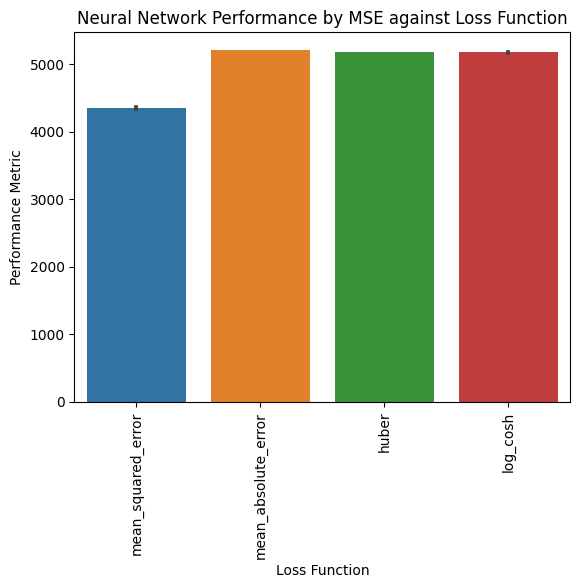

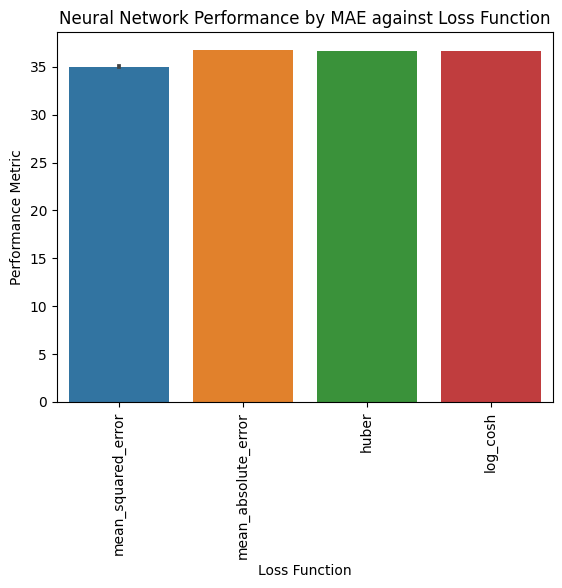

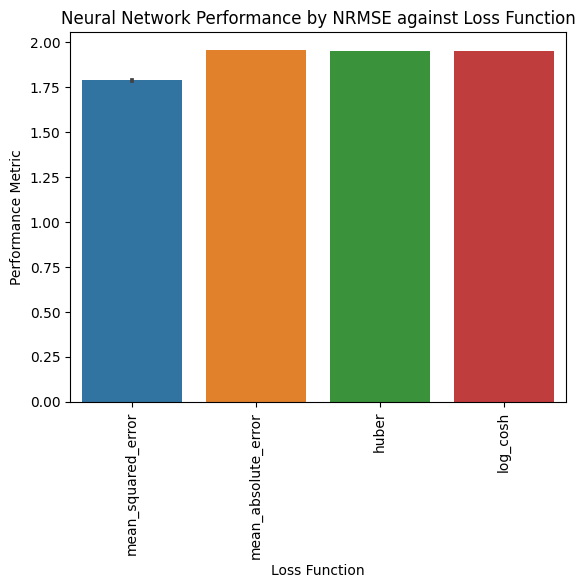

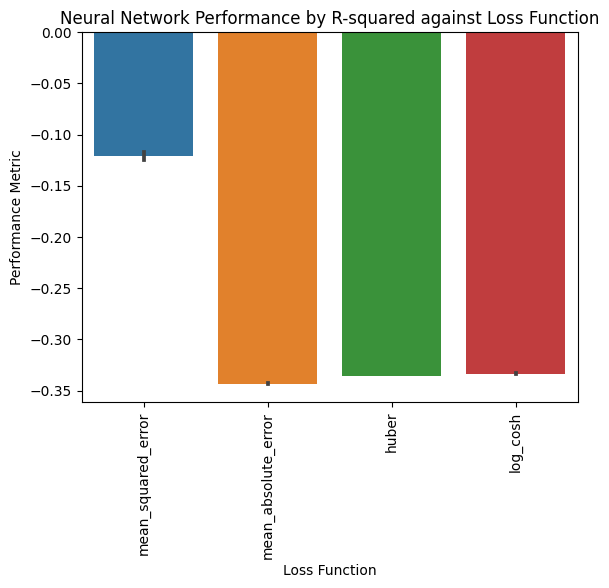

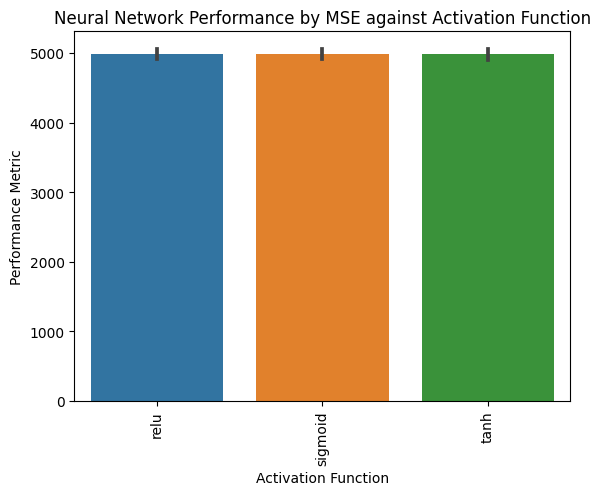

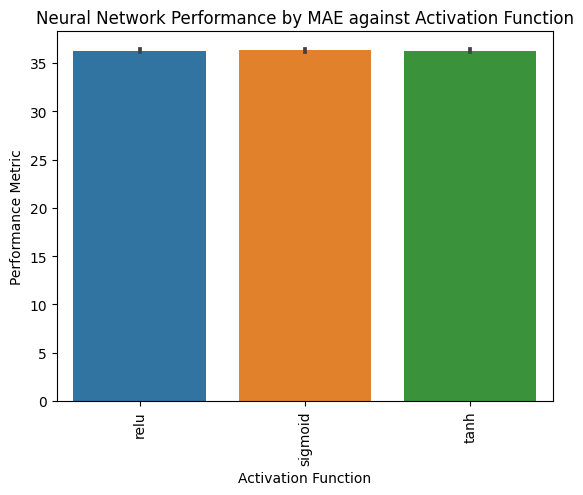

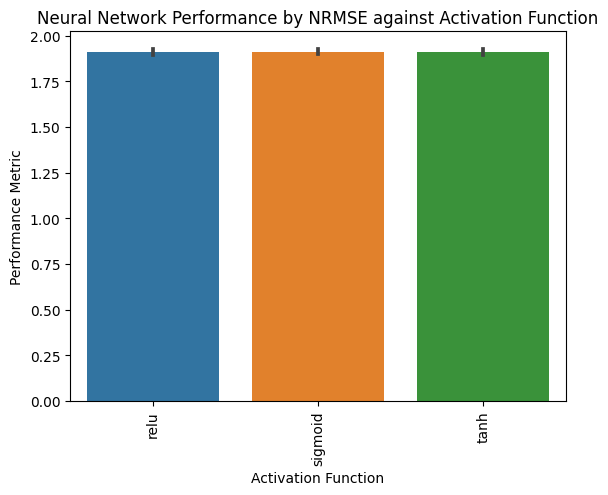

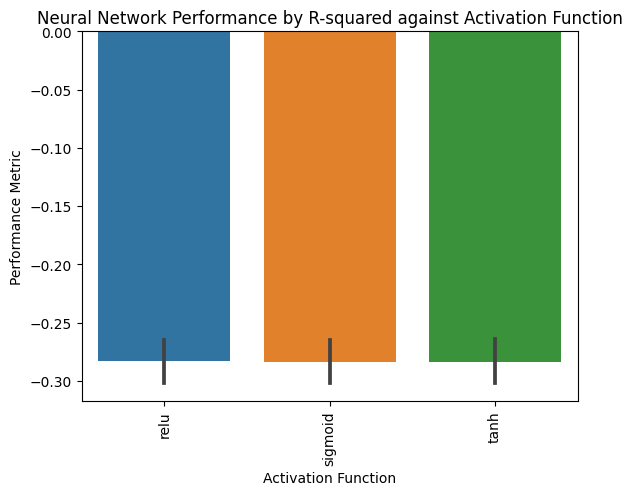

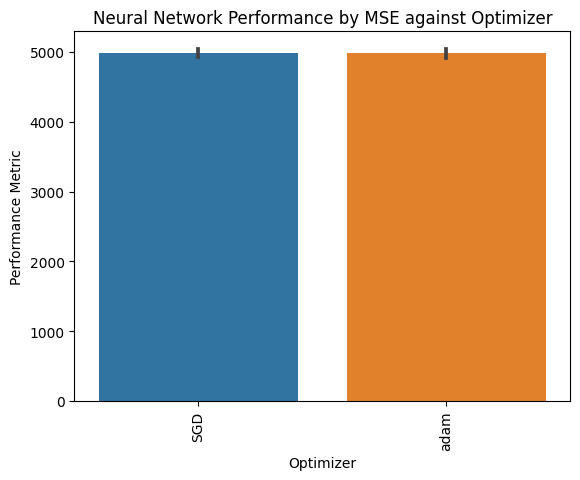

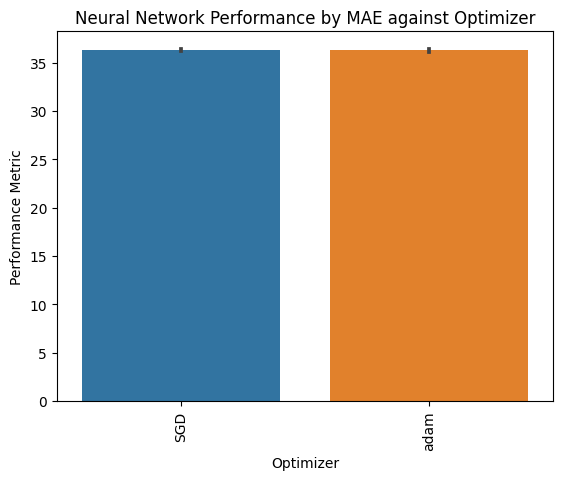

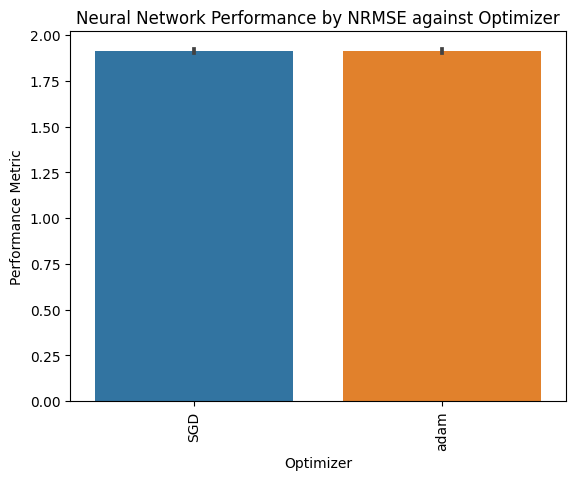

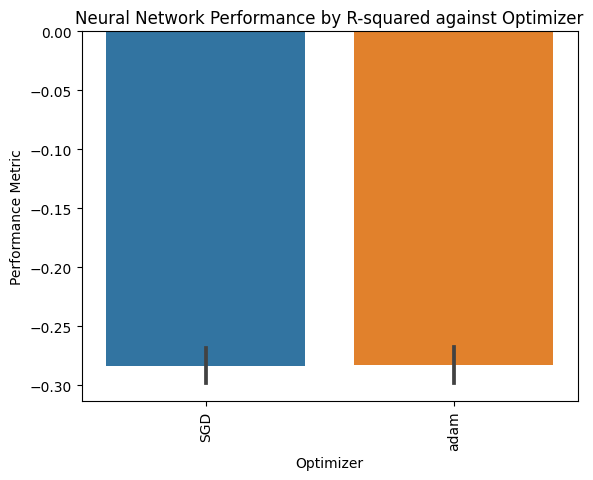

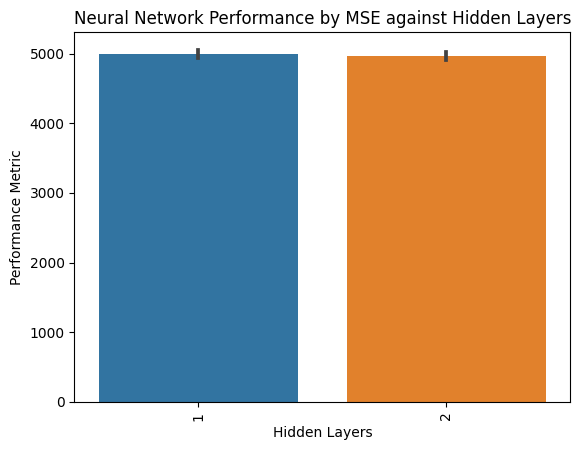

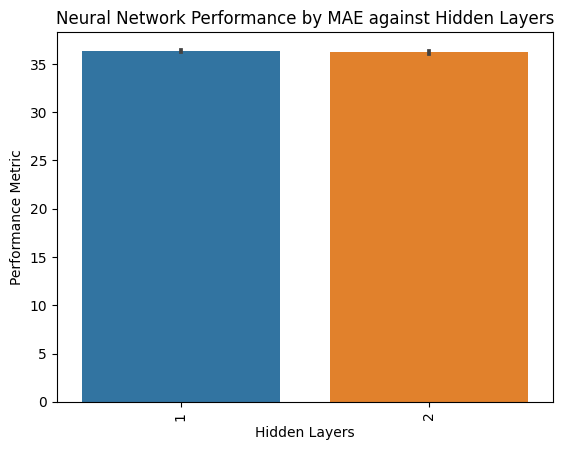

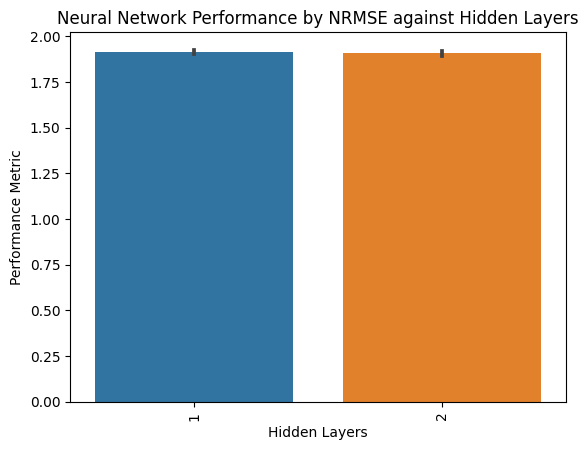

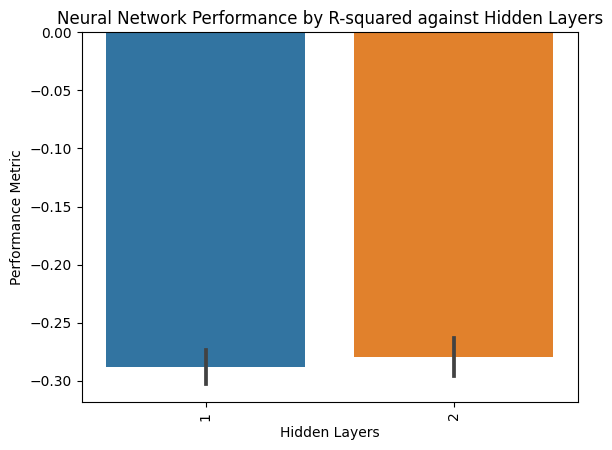

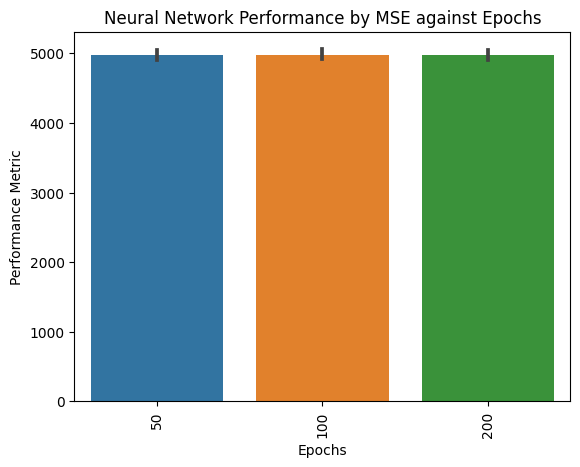

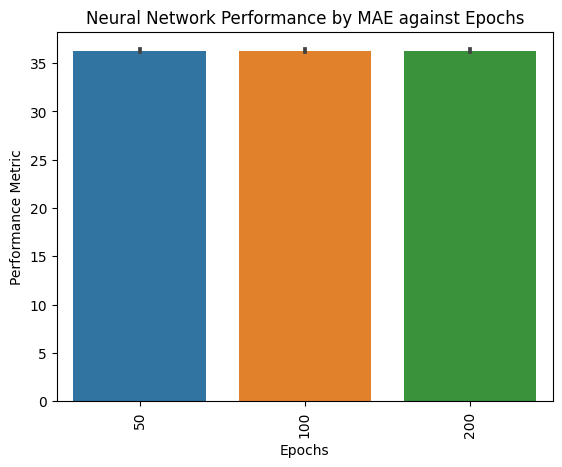

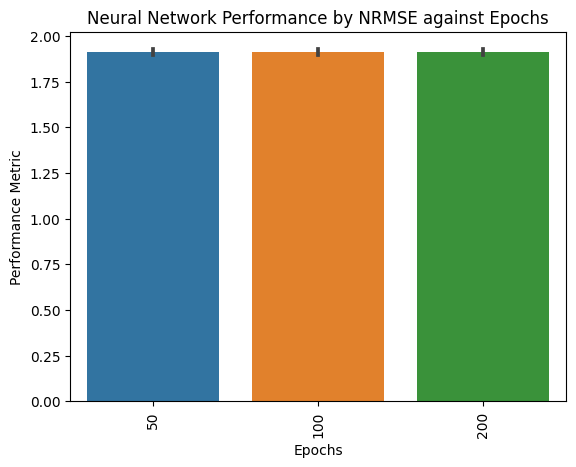

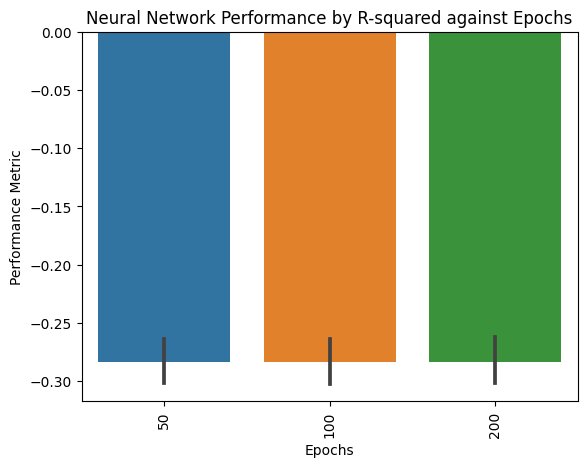

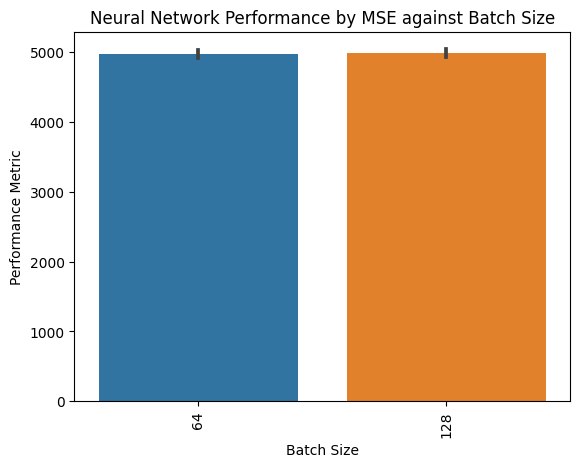

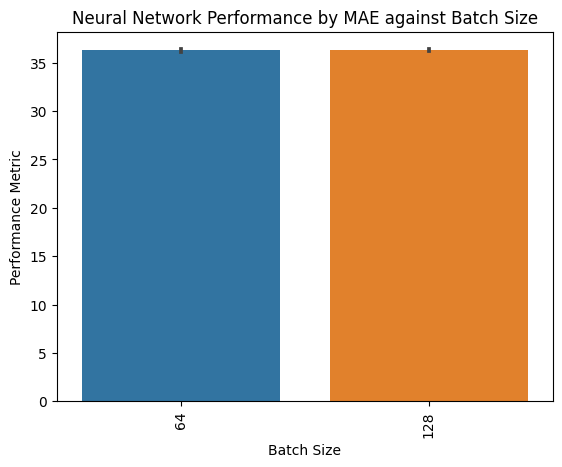

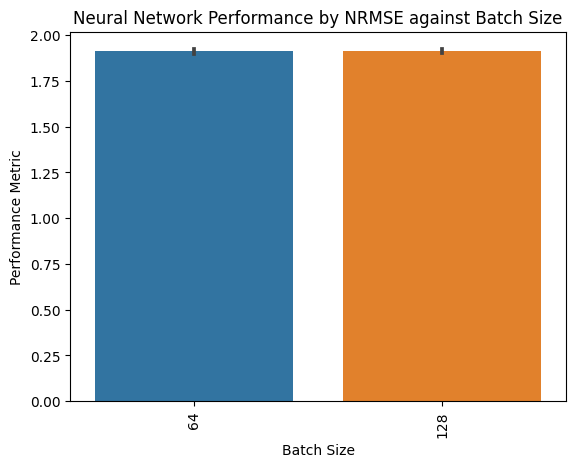

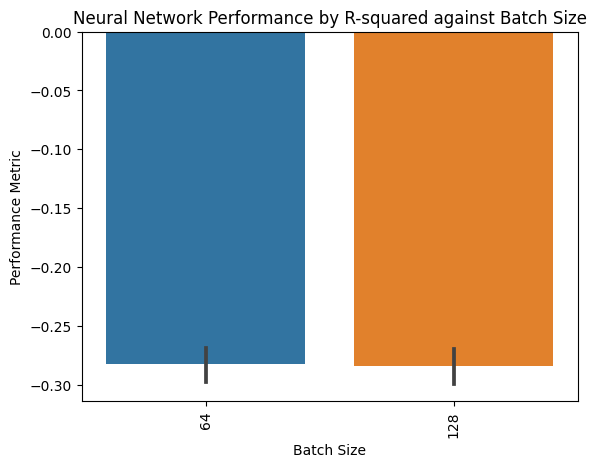

In [32]:
y_metrics = ["MSE", "MAE", "NRMSE", "R-squared"]
x_metrics = ["Loss Function", "Activation Function", "Optimizer", "Hidden Layers", "Epochs", "Batch Size"]

nn_results_total_days_df = nn_results_df[nn_results_df["Target"] == "Total Days"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_total_days_df, x_metric, y_metric)

In [33]:
print_overall_nn_min_stats(nn_results_total_days_df, 'Neural Network Total Days Performance')

Neural Network Total Days Performance
Model                         0
Target                        0
Loss Function               144
Activation Function           0
Optimizer                     0
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          18
MAE                          20
NRMSE                        18
R-squared                   101
dtype: int64 



In [34]:
nn_results_total_days_df.loc[[18]]

Model      Target       Loss Function Activation Function  \
18  Neural Network  Total Days  mean_squared_error                relu   

   Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
18      adam              2      50          64                        32   

            MSE        MAE     NRMSE  R-squared  
18  4190.590948  34.573068  1.754547  -0.079856

In [46]:
def optimised_nn_total_days_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=50, batch_size=64, verbose=0)
    model.save('nn_total_days_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_total_days_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Total Days')
add_evaluation_metrics('Neural Network', 'Total Days', mse, mae, nrmse, r2)

I0000 00:00:1724385765.235917     339 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Loss: 740.1267700195312
15/15 [==============================] - 0s 2ms/step
Neural Network Performance for Total Days:
MSE: 4372.798780350516
MAE: 35.03854226702439
NRMSE: 10.226888122401263
R-squared: -0.12680817244354325 



### Predicting Injury Rate

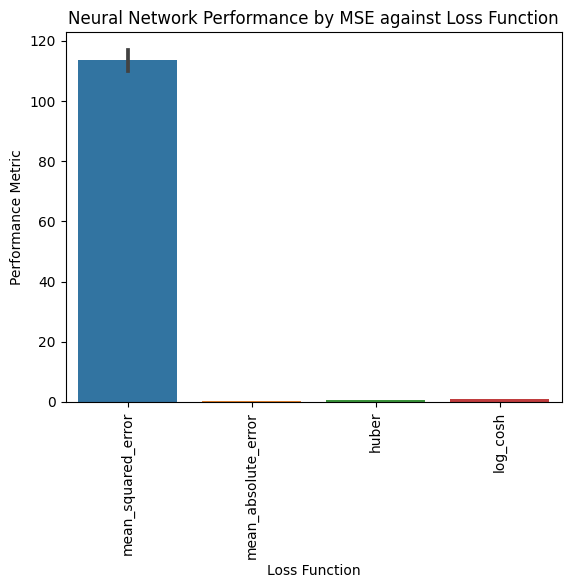

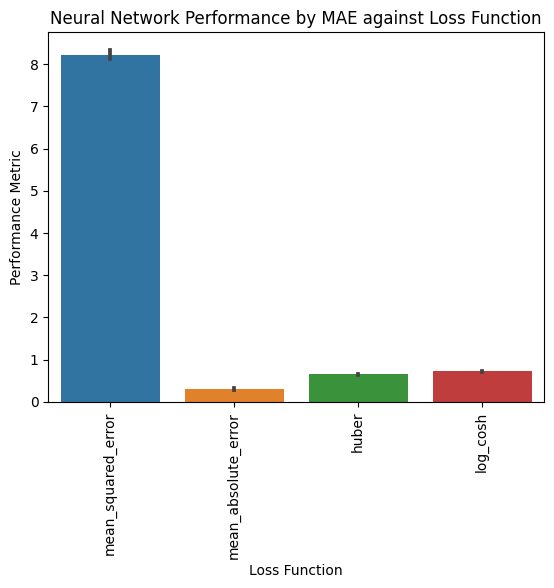

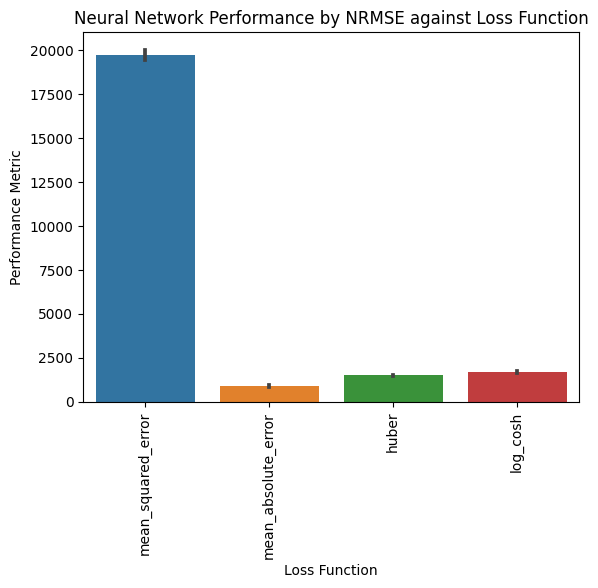

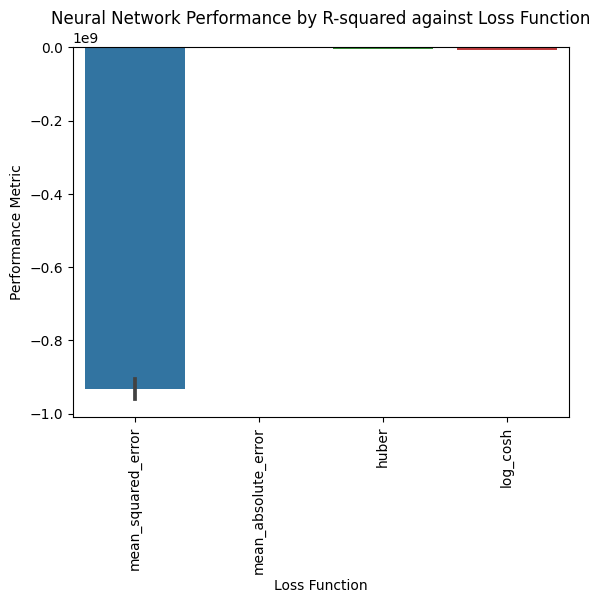

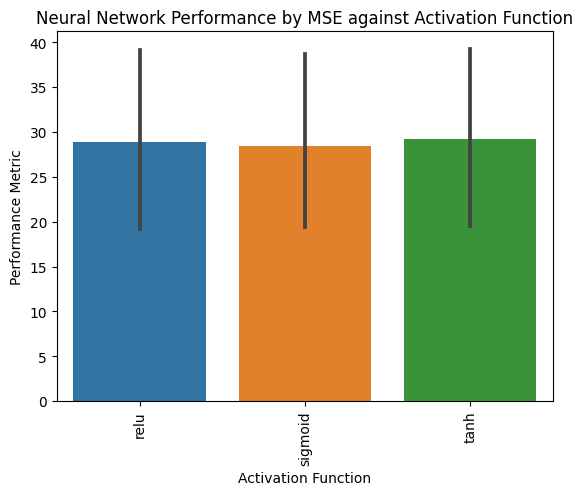

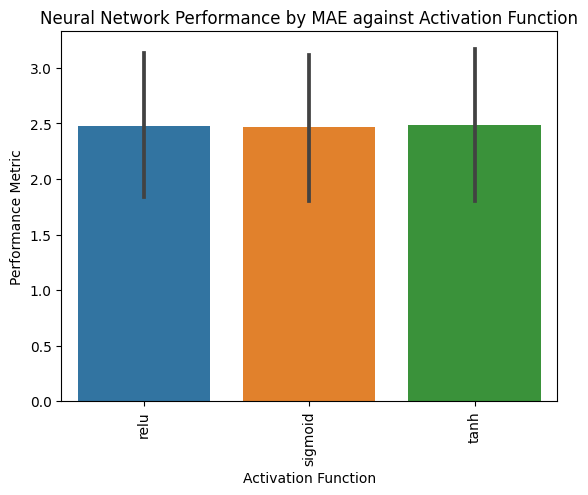

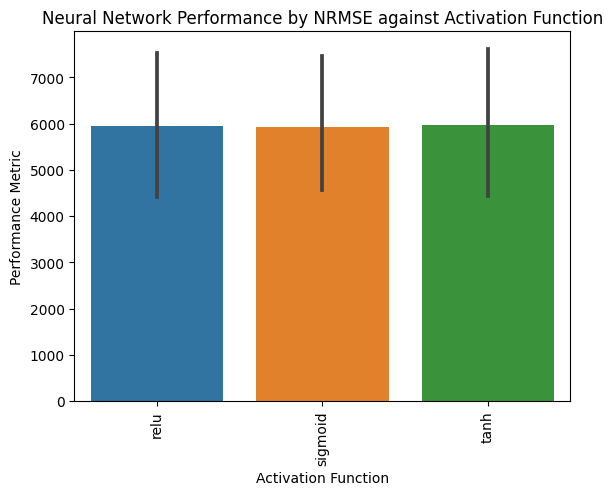

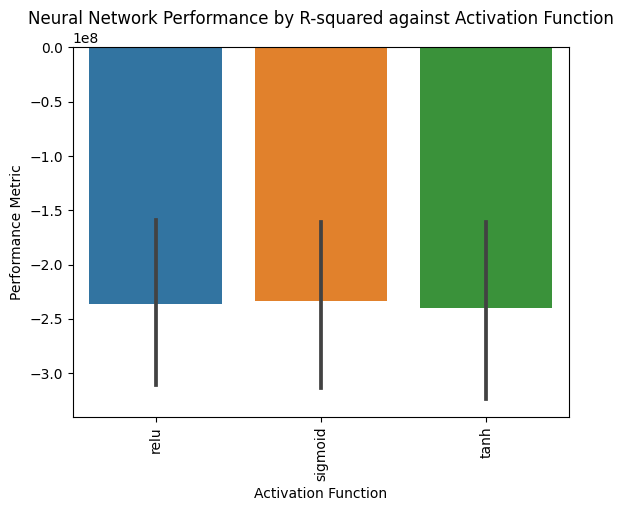

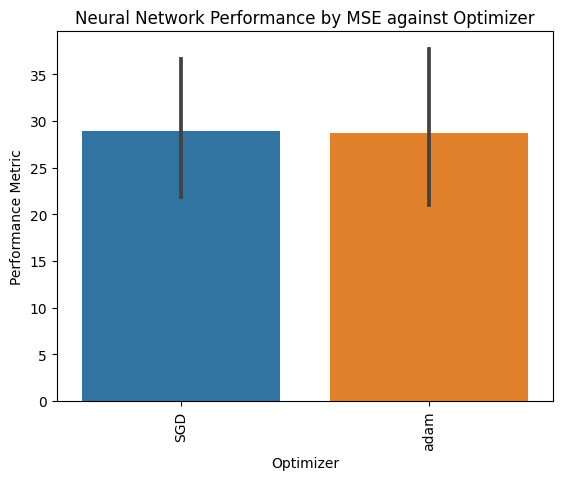

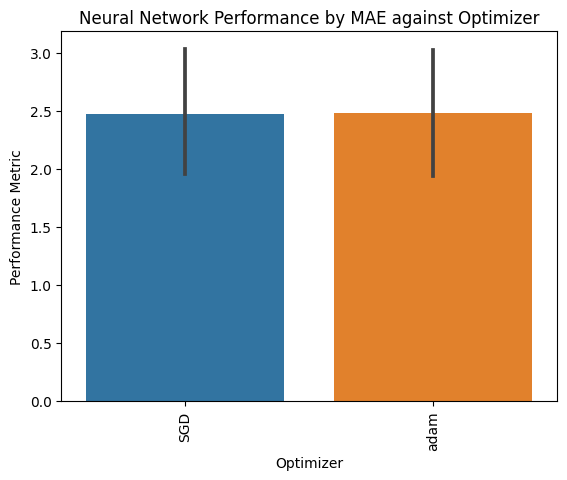

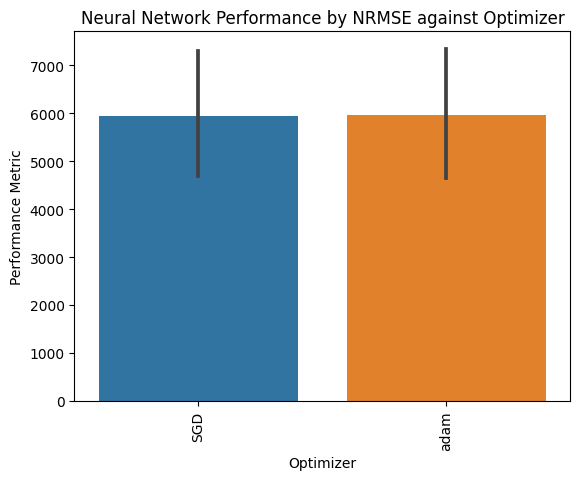

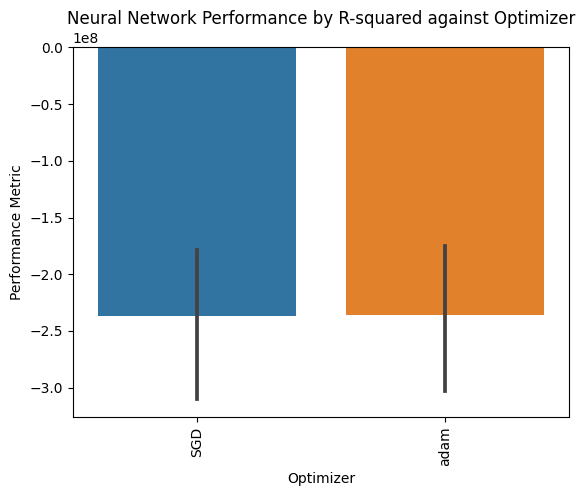

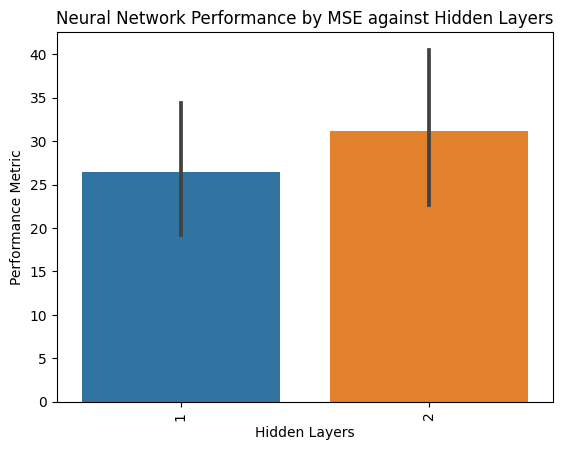

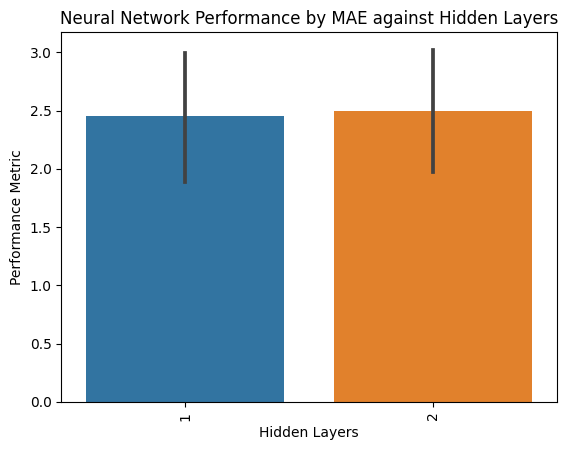

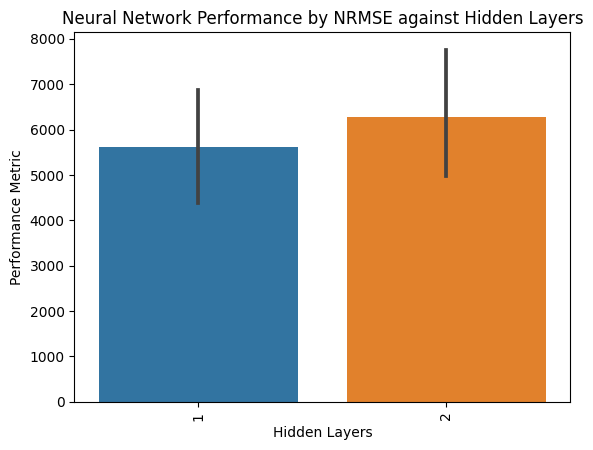

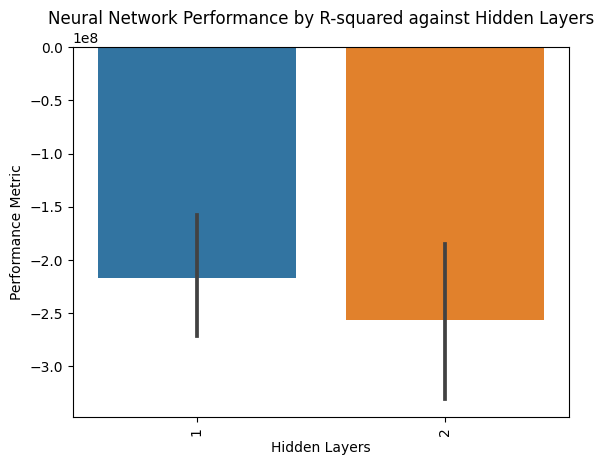

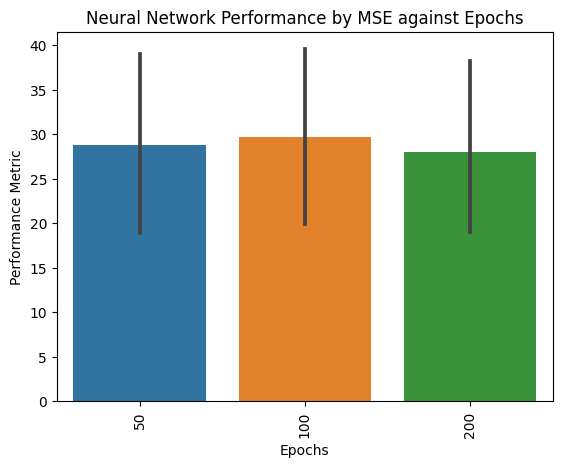

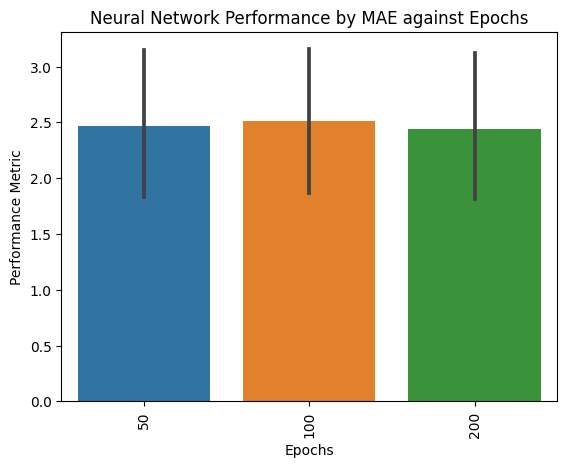

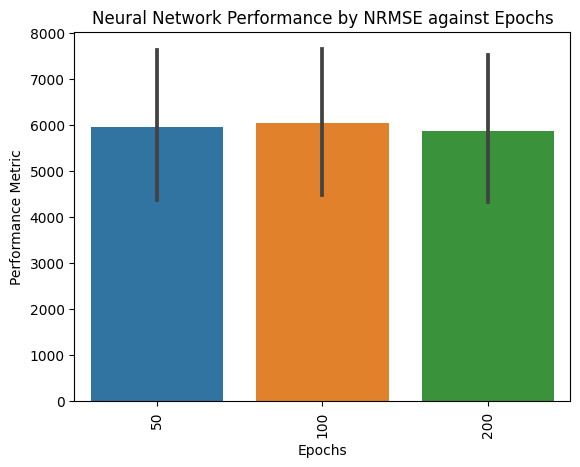

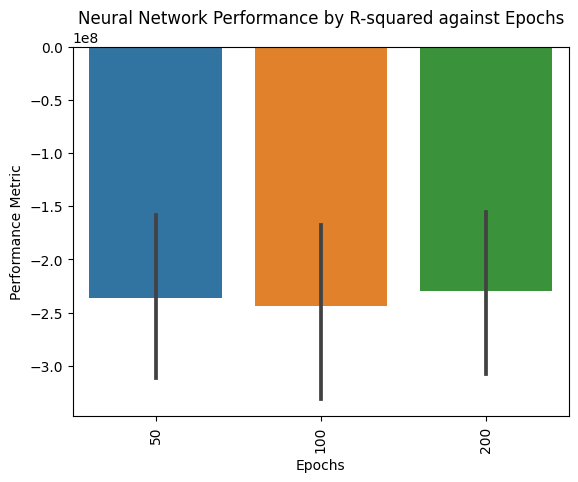

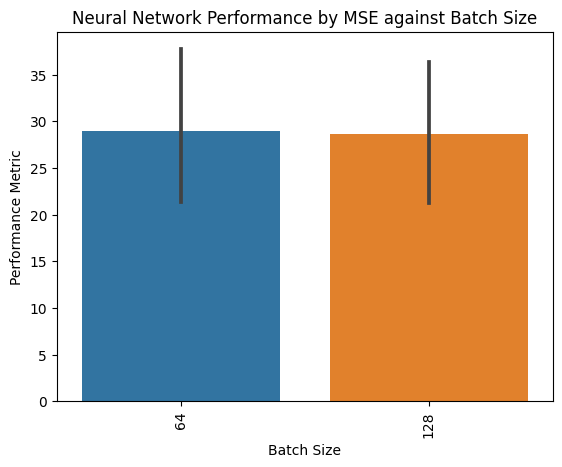

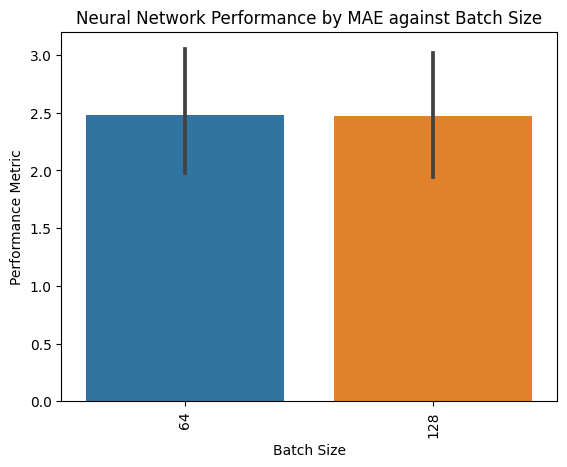

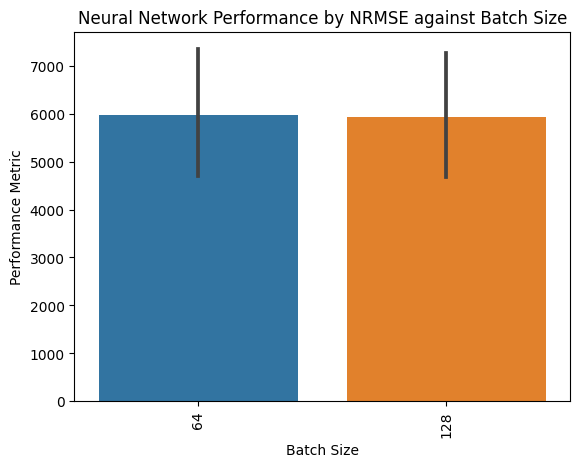

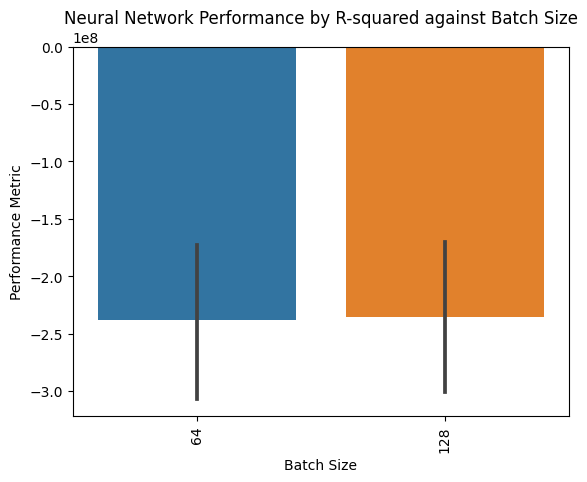

In [36]:
nn_results_injury_rate_df = nn_results_df[nn_results_df["Target"] == "Injury Rate"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_injury_rate_df, x_metric, y_metric)

In [37]:
print_overall_nn_min_stats(nn_results_injury_rate_df, 'Neural Network Injury Rate Performance')

Neural Network Injury Rate Performance
Model                       576
Target                      576
Loss Function               720
Activation Function         576
Optimizer                   576
Hidden Layers               576
Epochs                      576
Batch Size                  576
Neurons per hidden layer    576
MSE                         712
MAE                         712
NRMSE                       712
R-squared                   596
dtype: int64 



In [38]:
nn_results_df.iloc[[712]]

Model       Target        Loss Function Activation Function  \
712  Neural Network  Injury Rate  mean_absolute_error                tanh   

    Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
712      adam              1     200          64                        32   

         MSE      MAE       NRMSE      R-squared  
712  0.08789  0.20258  549.445417 -721756.533595

In [47]:
def optimised_nn_injury_rate_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='tanh'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=64, verbose=0)
    model.save('nn_injury_rate_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_injury_rate_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Injury Rate')
add_evaluation_metrics('Neural Network', 'Injury Rate', mse, mae, nrmse, r2)

Training Loss: 8.047898292541504
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Injury Rate:
MSE: 0.055709152449301254
MAE: 0.16021177513084875
NRMSE: 1.268129356667236
R-squared: -457486.31956882647 



### Predicting average injury cost

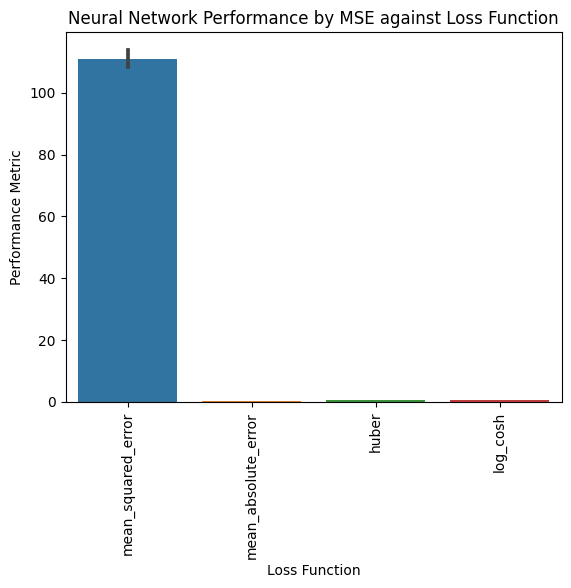

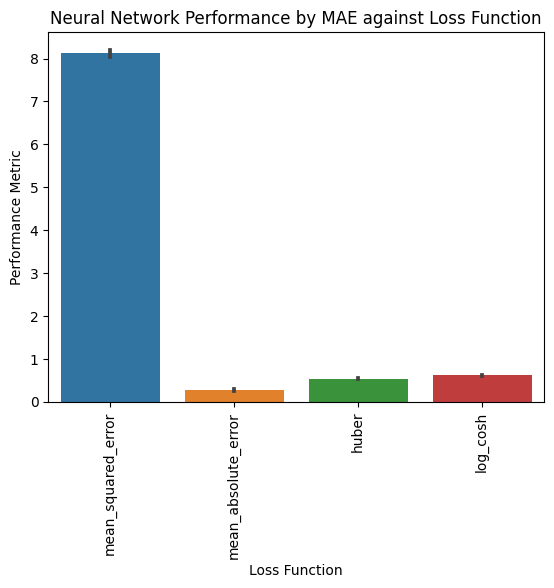

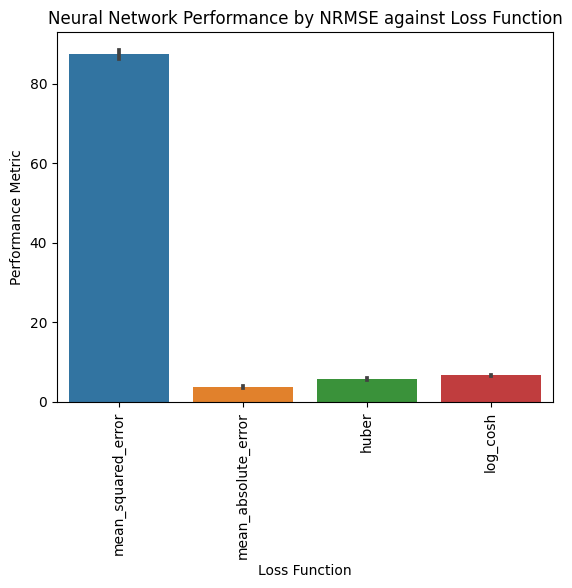

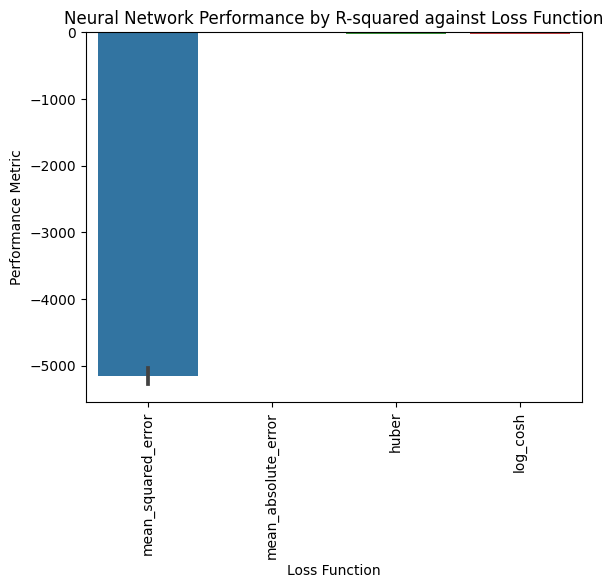

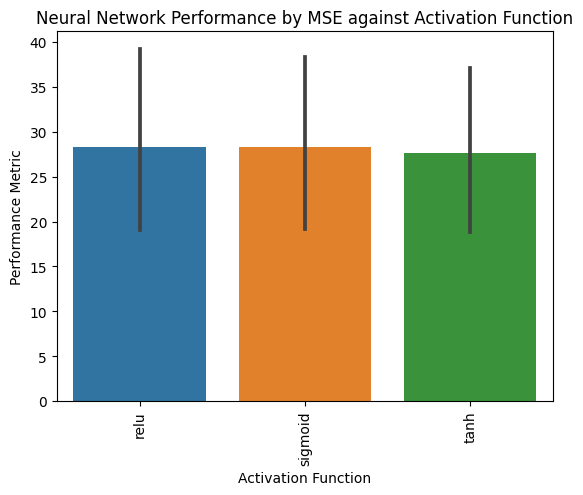

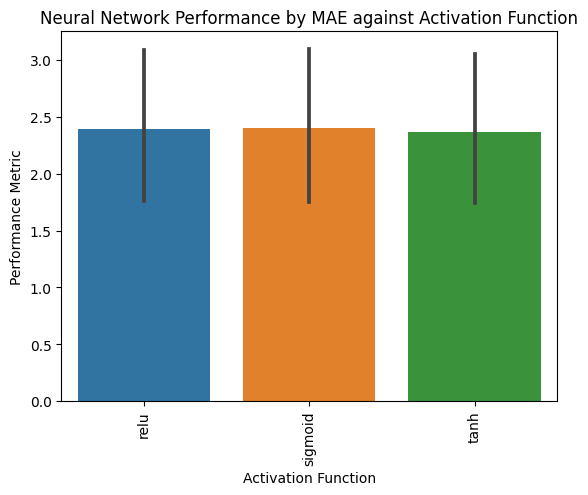

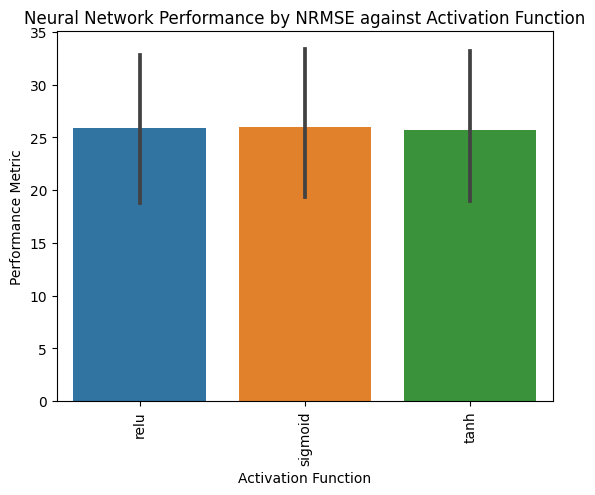

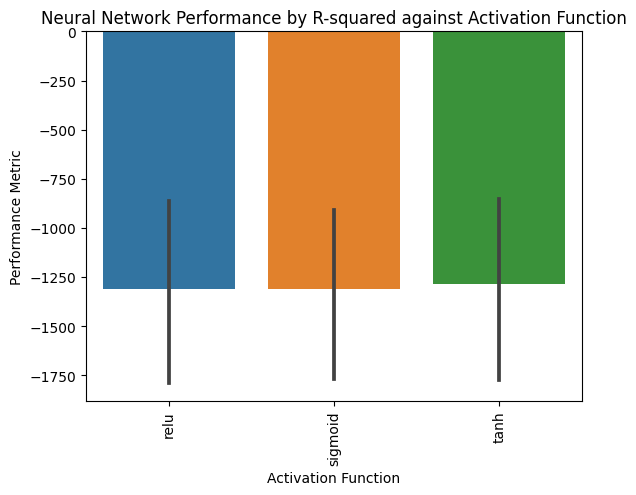

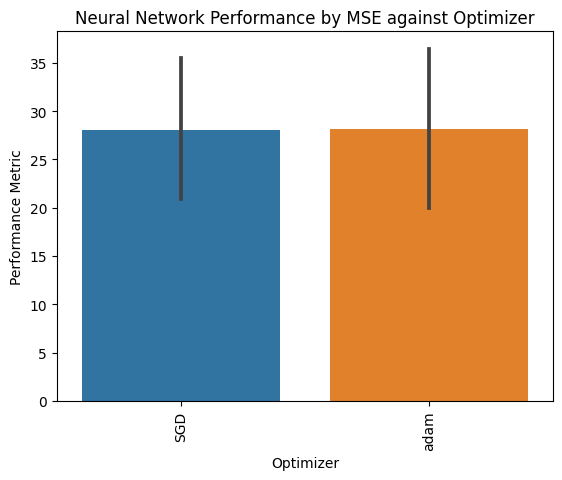

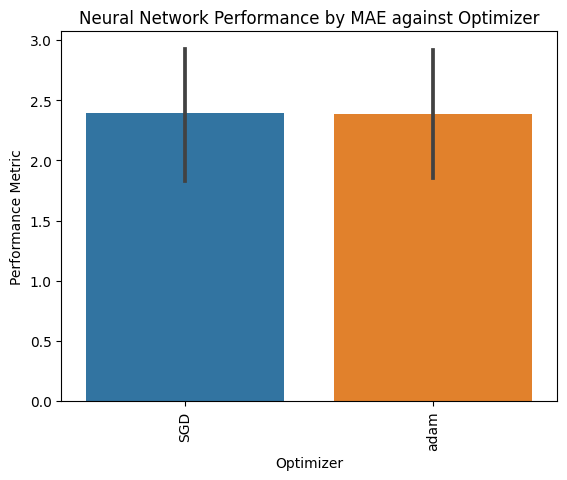

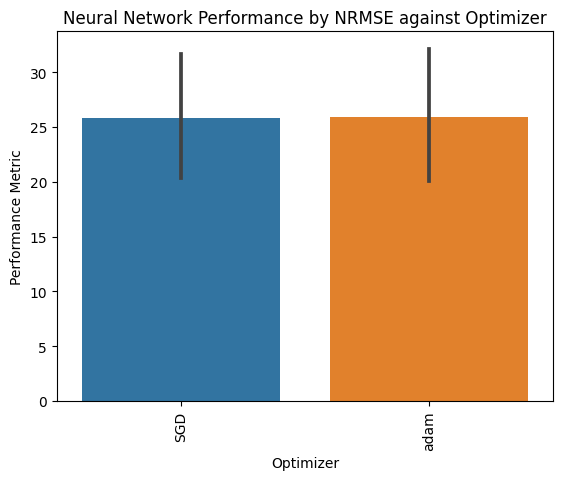

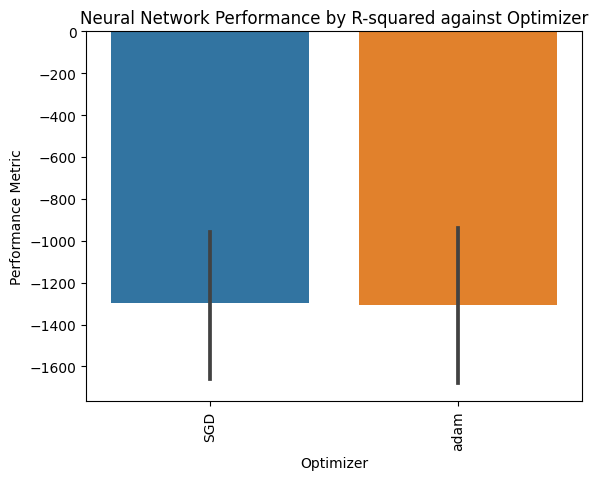

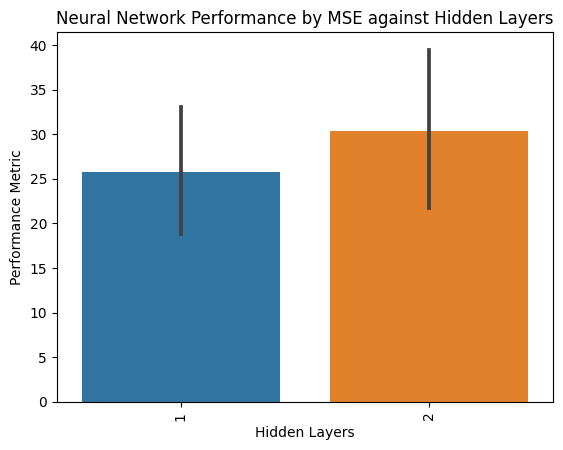

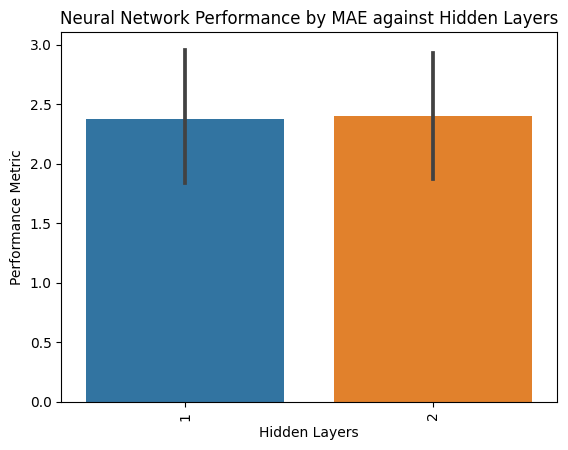

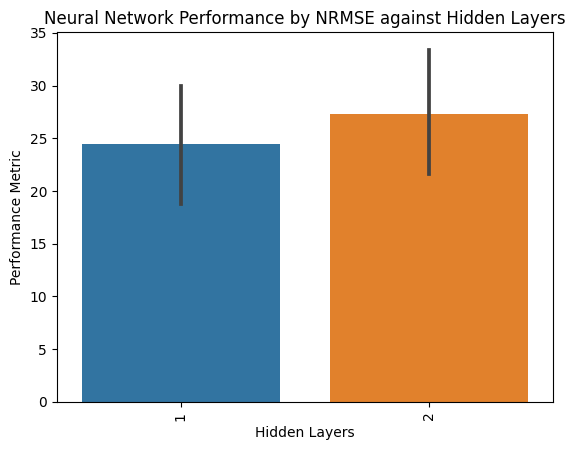

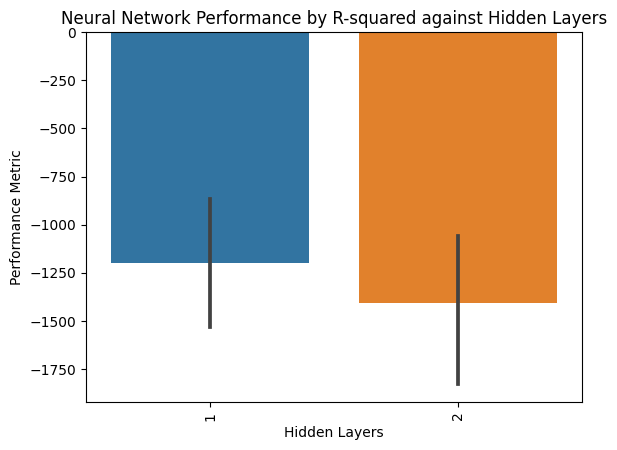

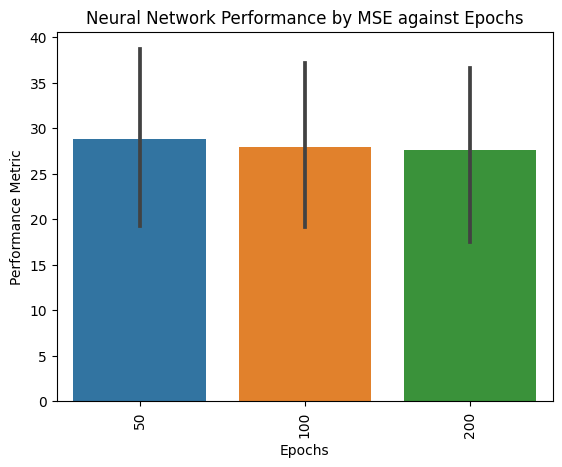

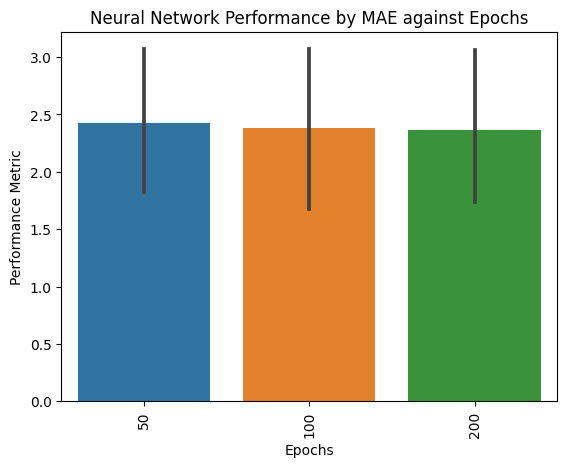

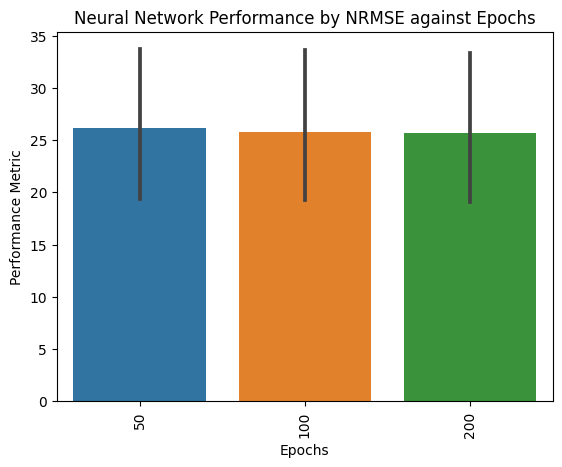

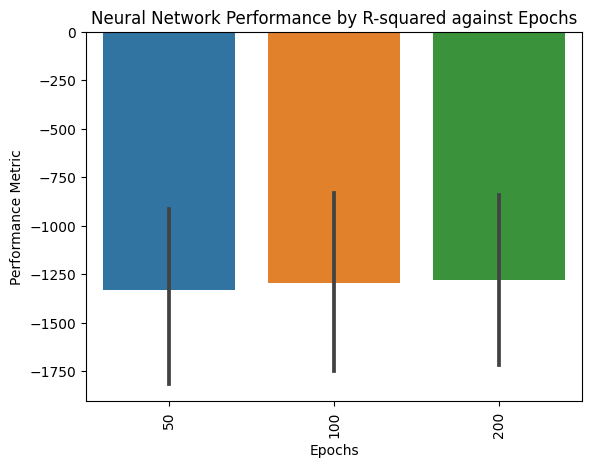

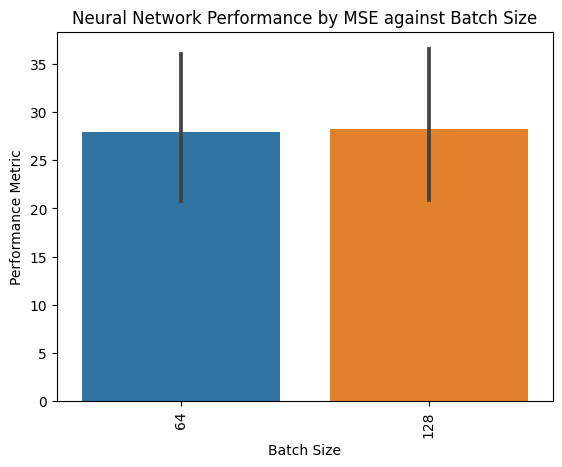

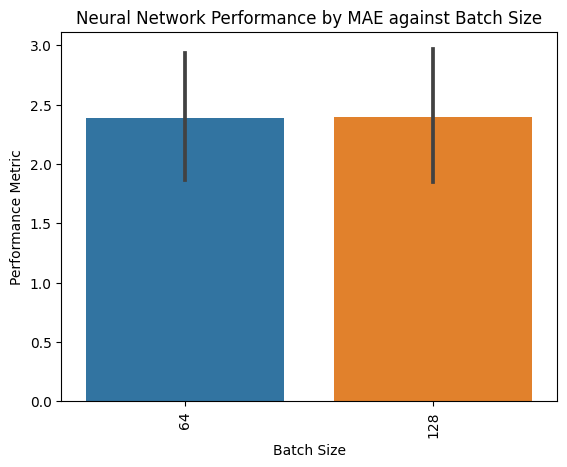

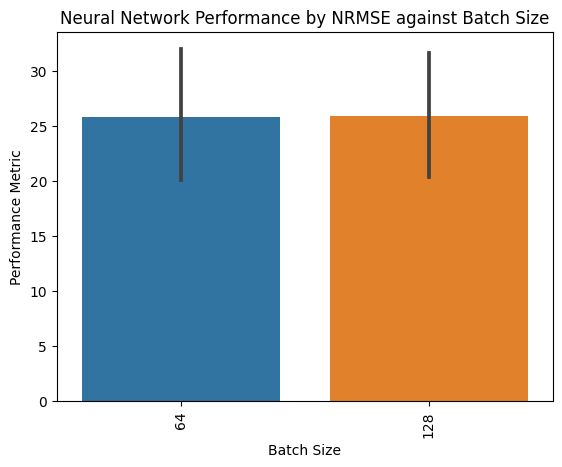

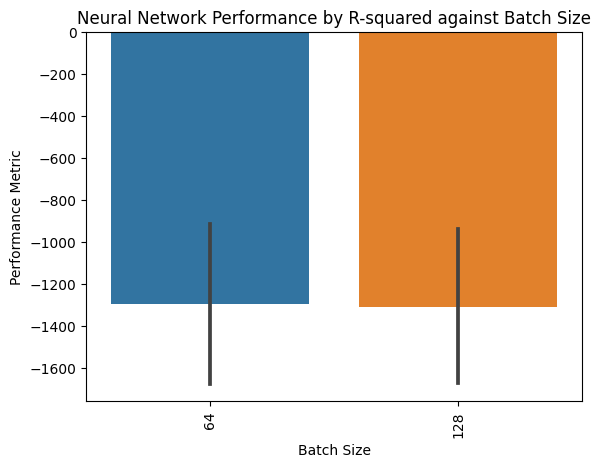

In [40]:
nn_results_avg_injury_cost_df = nn_results_df[nn_results_df["Target"] == "Average Injury Cost"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_avg_injury_cost_df, x_metric, y_metric)

In [41]:
print_overall_nn_min_stats(nn_results_avg_injury_cost_df, 'Neural Network Average Injury Cost Performance')

Neural Network Average Injury Cost Performance
Model                       288
Target                      288
Loss Function               432
Activation Function         288
Optimizer                   288
Hidden Layers               288
Epochs                      288
Batch Size                  288
Neurons per hidden layer    288
MSE                         424
MAE                         397
NRMSE                       424
R-squared                   320
dtype: int64 



In [42]:
nn_results_df.iloc[[424]]

Model               Target        Loss Function  \
424  Neural Network  Average Injury Cost  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
424                tanh      adam              1     200          64   

     Neurons per hidden layer       MSE       MAE     NRMSE  R-squared  
424                        32  0.069568  0.182621  2.191213  -2.229842

In [48]:
def optimised_nn_avg_injury_cost_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='tanh'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=64, verbose=0)
    model.save('nn_avg_injury_cost_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_avg_injury_cost_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Average Injury Cost')
add_evaluation_metrics('Neural Network', 'Average Injury Cost', mse, mae, nrmse, r2)

Training Loss: 8.047517776489258
15/15 [==============================] - 0s 1ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.043960027239609366
MAE: 0.14371855790822205
NRMSE: 1.0882653733091208
R-squared: -1.0409428014754178 



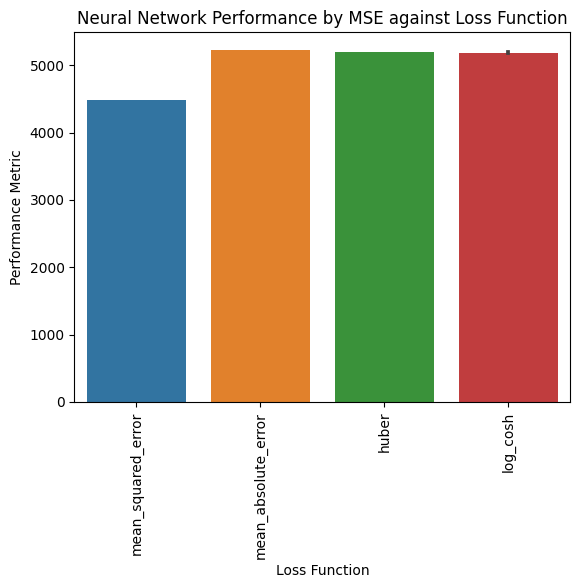

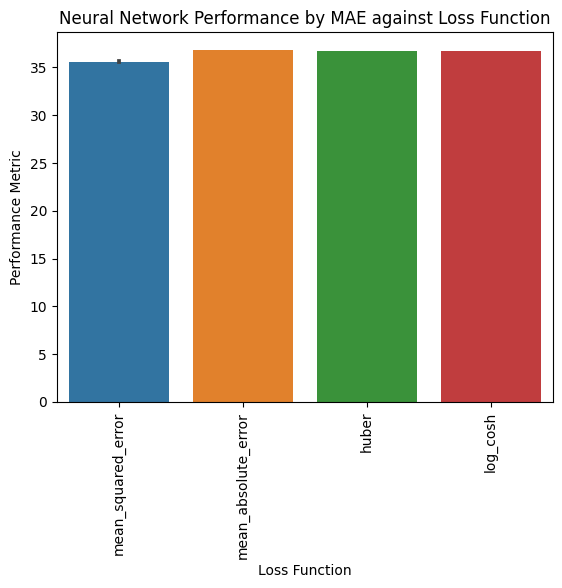

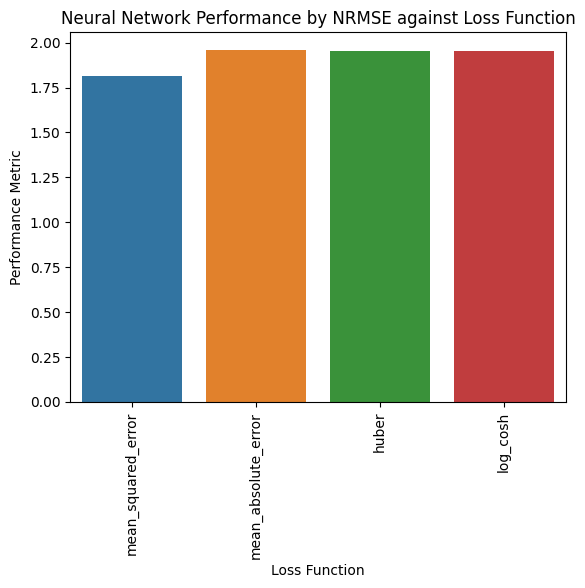

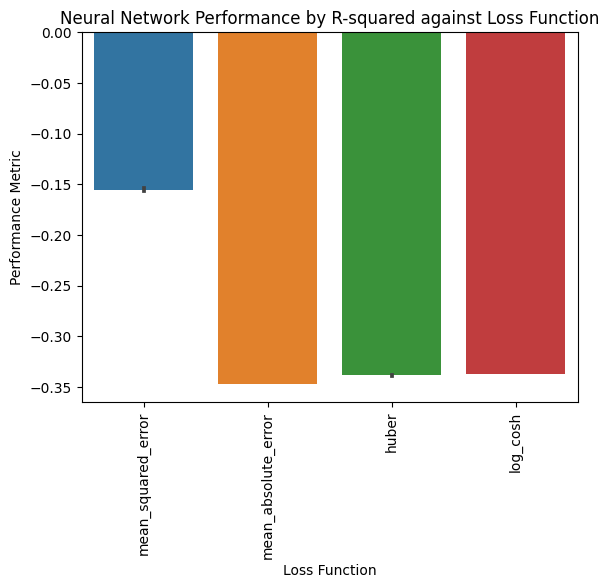

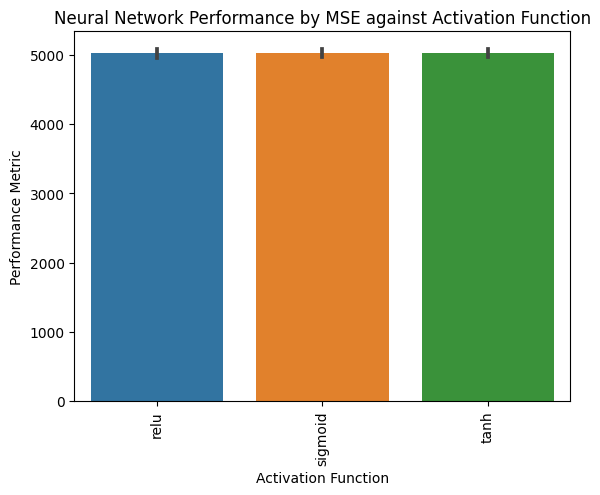

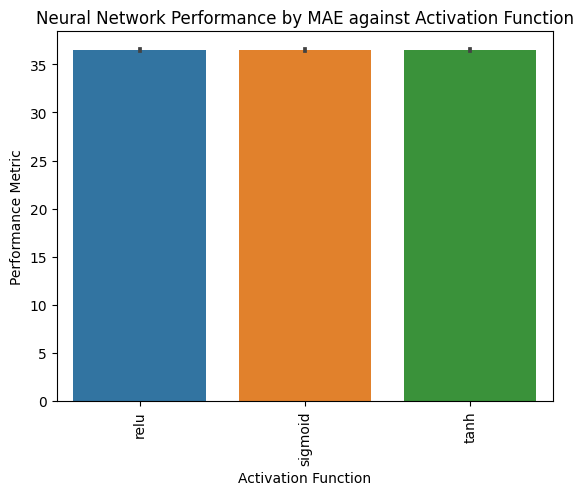

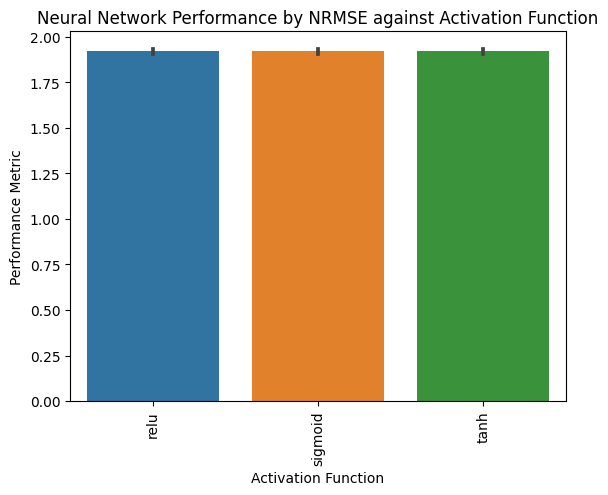

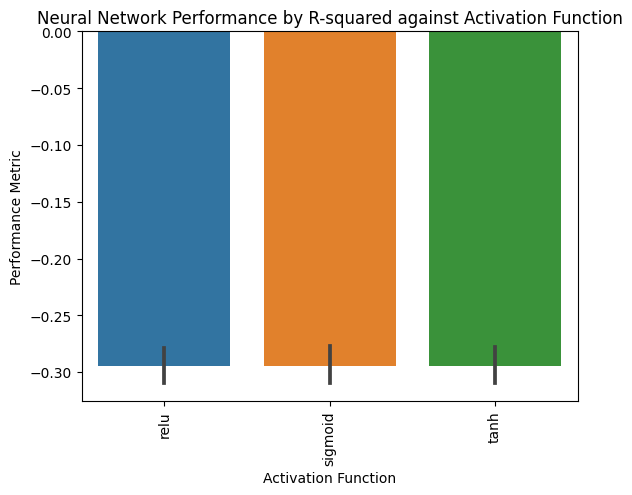

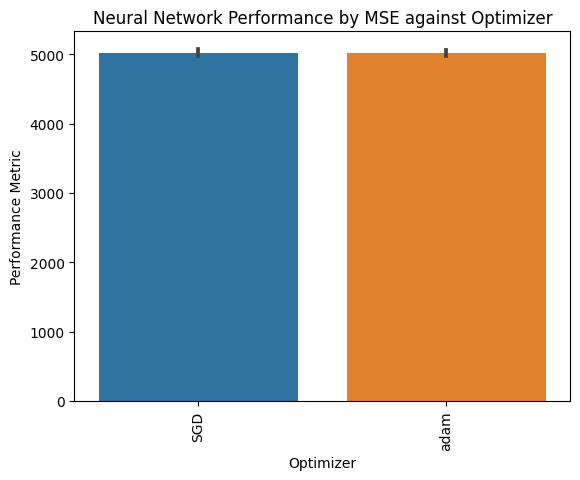

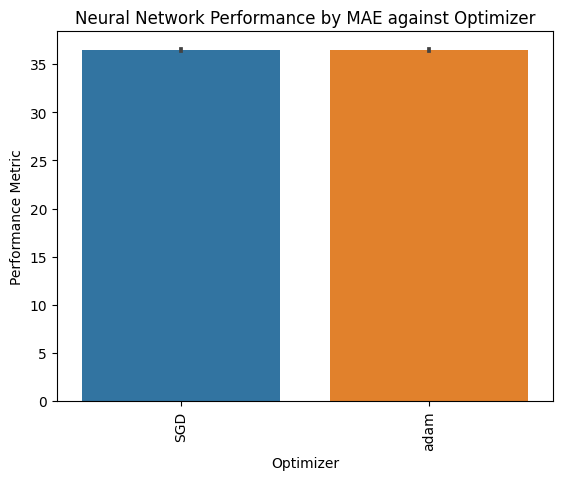

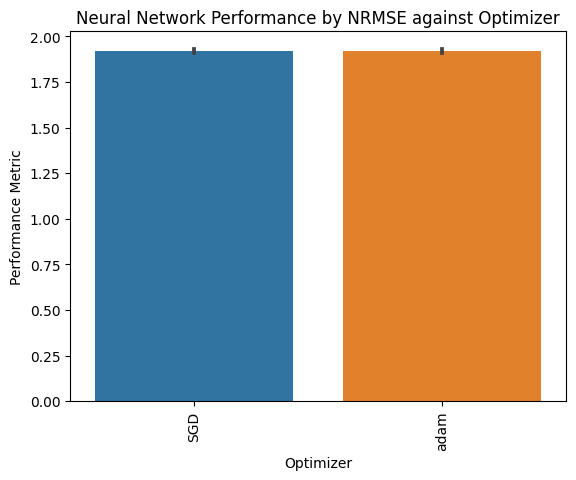

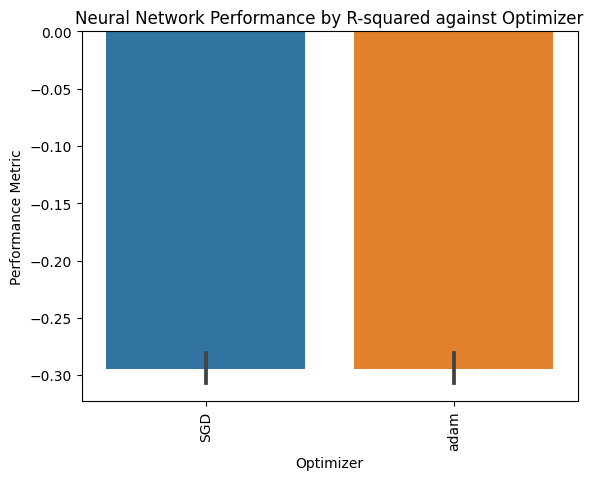

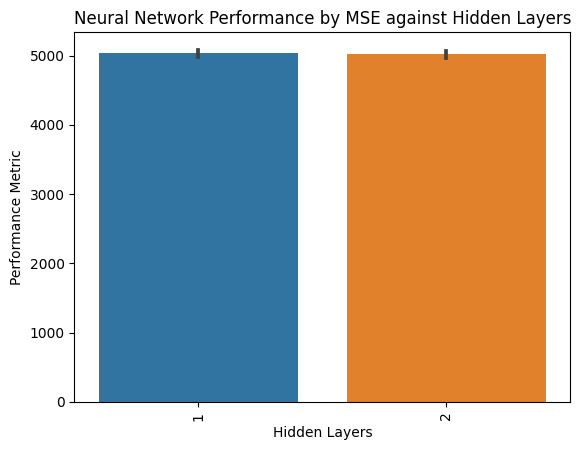

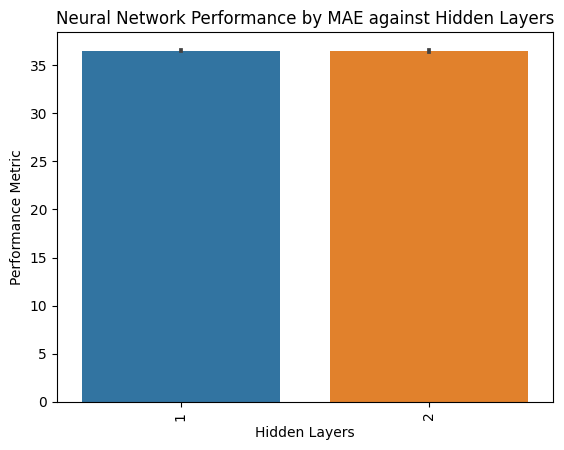

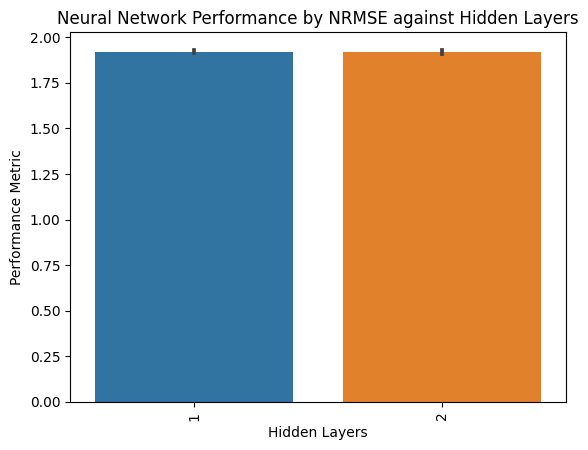

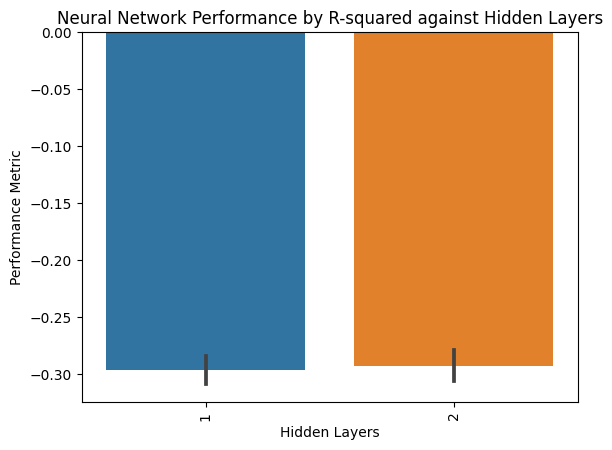

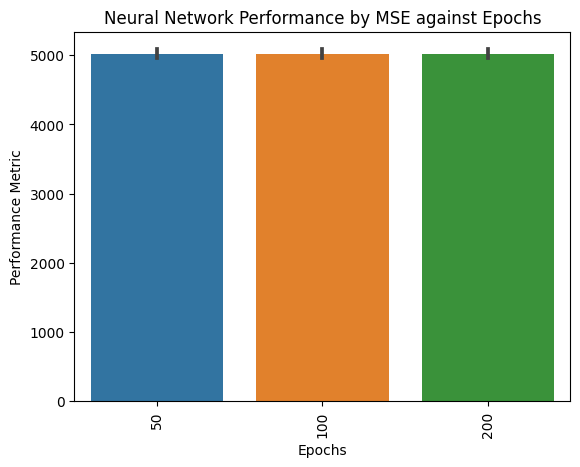

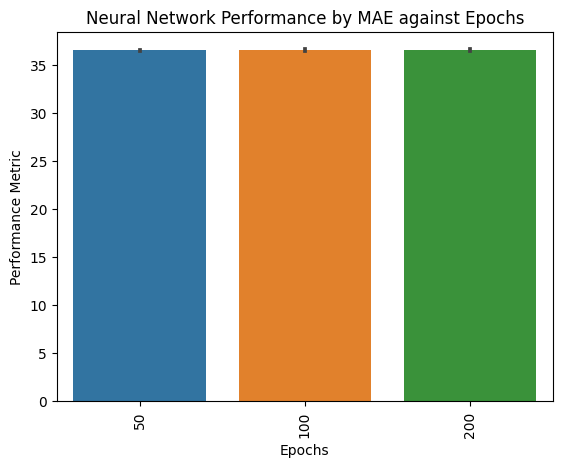

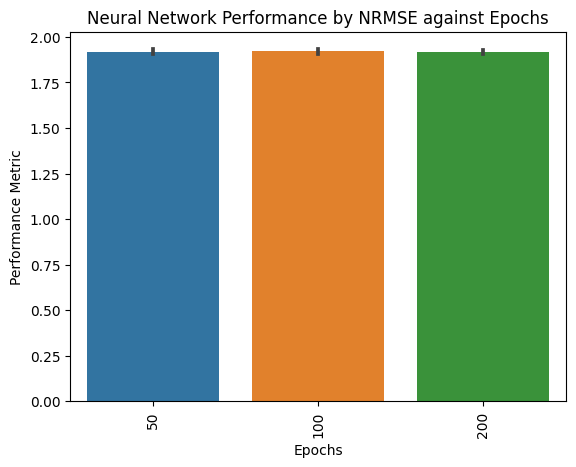

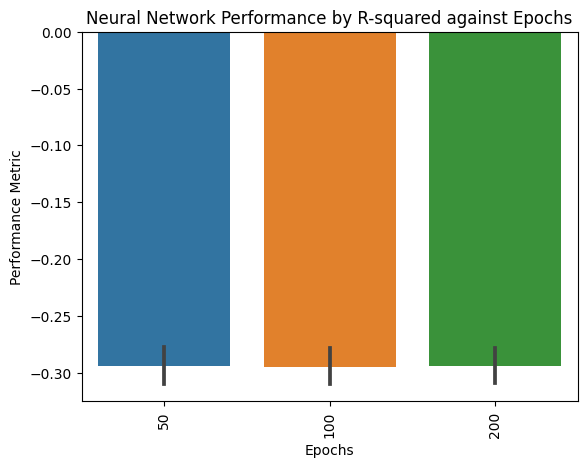

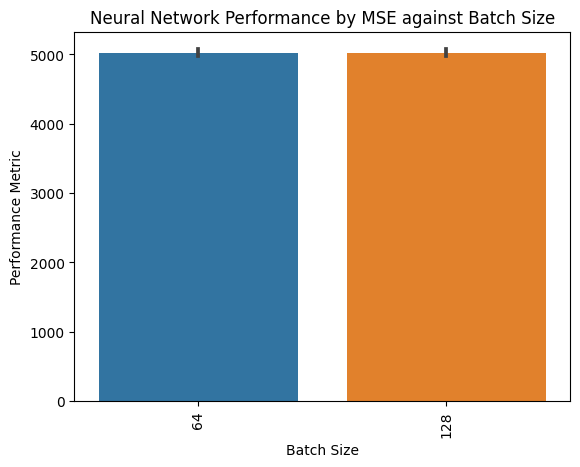

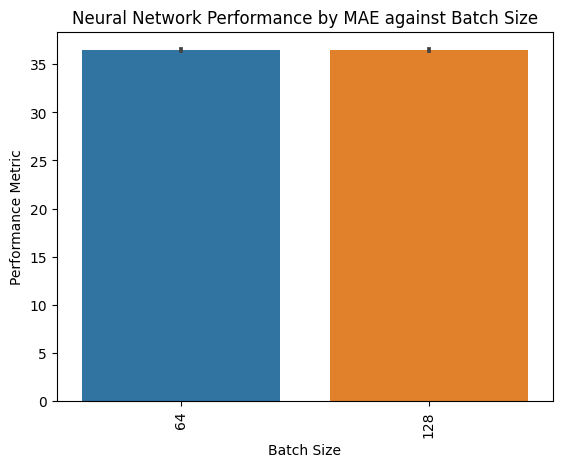

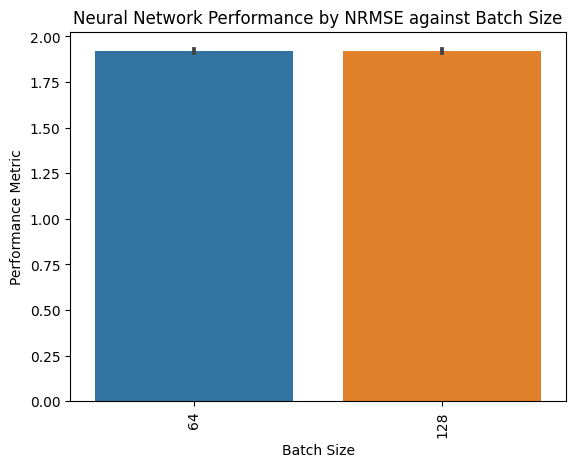

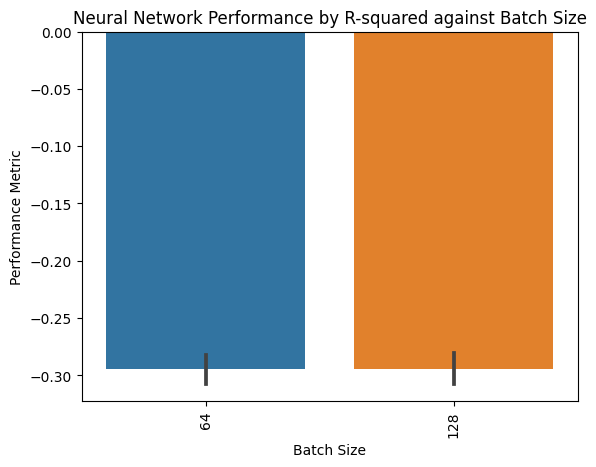

In [44]:
nn_pca13_results_total_days_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Total Days"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_total_days_df, x_metric, y_metric)

In [45]:
print_overall_nn_min_stats(nn_pca13_results_total_days_df, 'Neural Network (PCA n = 13) Total Days Performance')

Neural Network (PCA n = 13) Total Days Performance
Model                         0
Target                        0
Loss Function               144
Activation Function           0
Optimizer                     0
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          19
MAE                          18
NRMSE                        19
R-squared                    86
dtype: int64 



In [46]:
nn_pca13_results_df.loc[[19]]

Model      Target       Loss Function  \
19  Neural Network (PCA n = 13)  Total Days  mean_squared_error   

   Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
19                relu      adam              2      50         128   

    Neurons per hidden layer          MSE        MAE     NRMSE  R-squared  
19                        32  4437.225953  35.423043  1.805441   -0.14341

In [49]:
def optimised_nn_pca13_total_days_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=50, batch_size=128, verbose=0)
    model.save('nn_pca13_total_days_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_total_days_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Total Days')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Total Days', mse, mae, nrmse, r2)

Training Loss: 744.1160278320312
15/15 [==============================] - 0s 1ms/step
Neural Network (PCA n = 13) Performance for Total Days:
MSE: 4459.095148776345
MAE: 35.29876610132701
NRMSE: 11.337697682972351
R-squared: -0.14904552158281192 



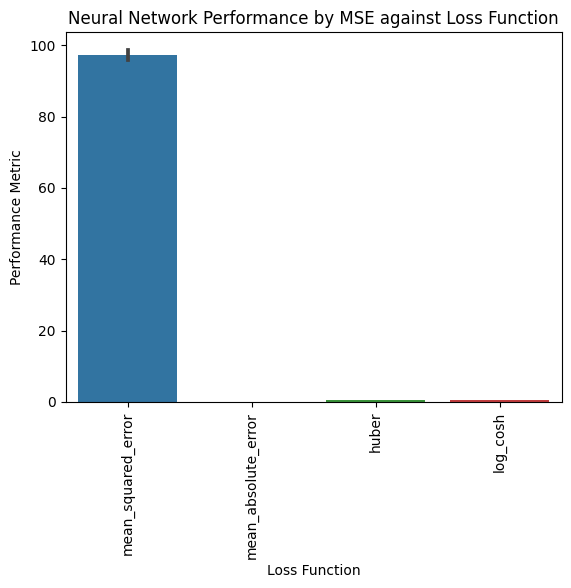

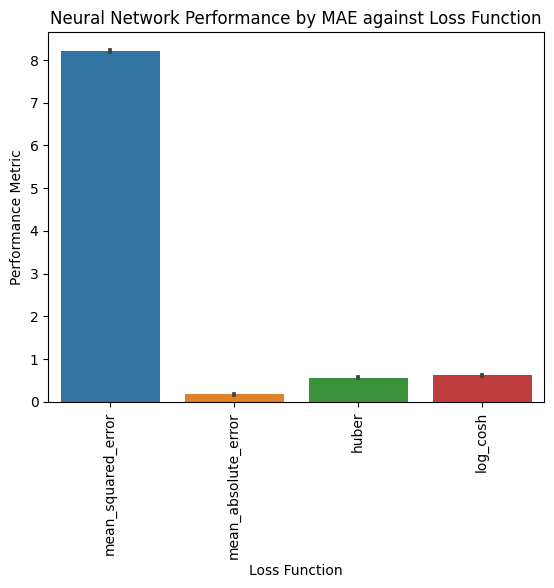

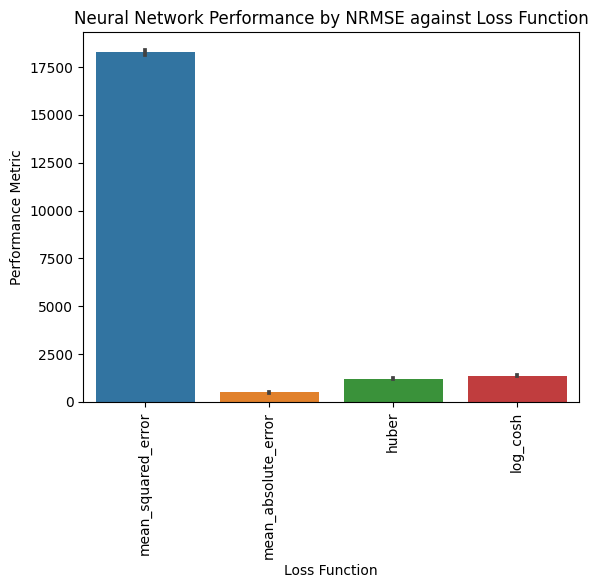

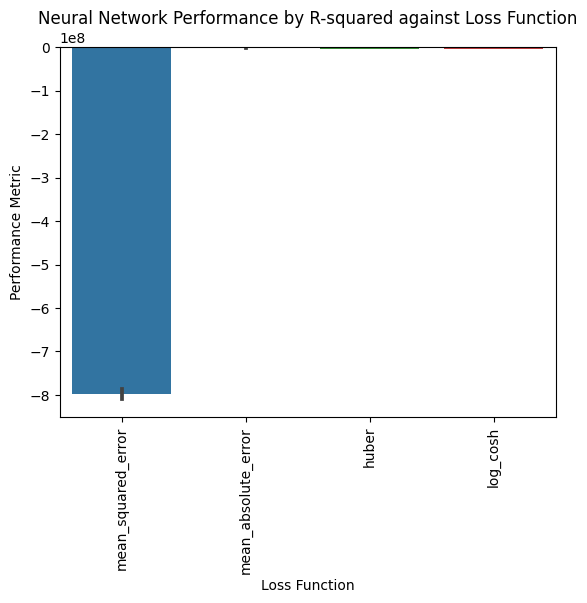

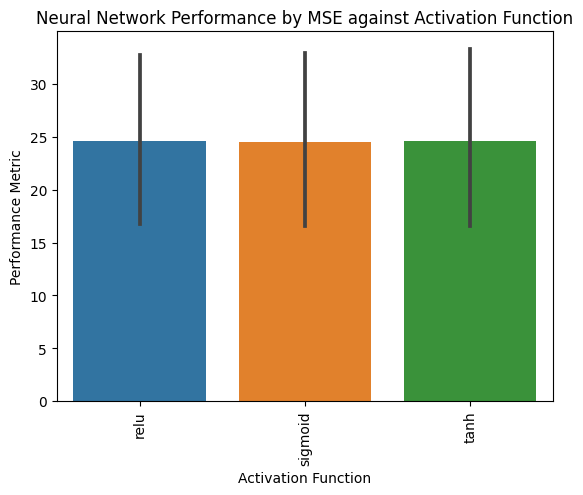

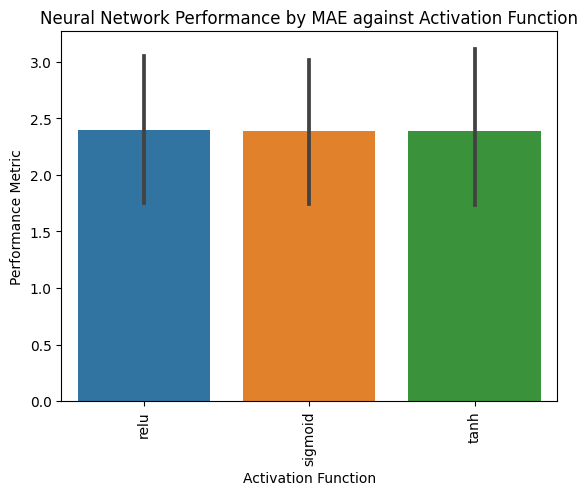

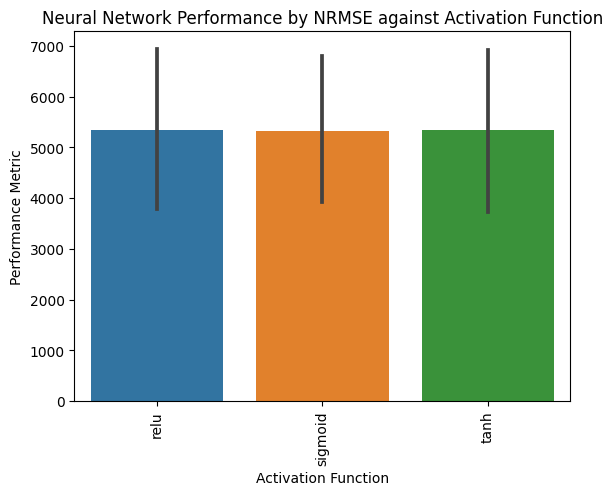

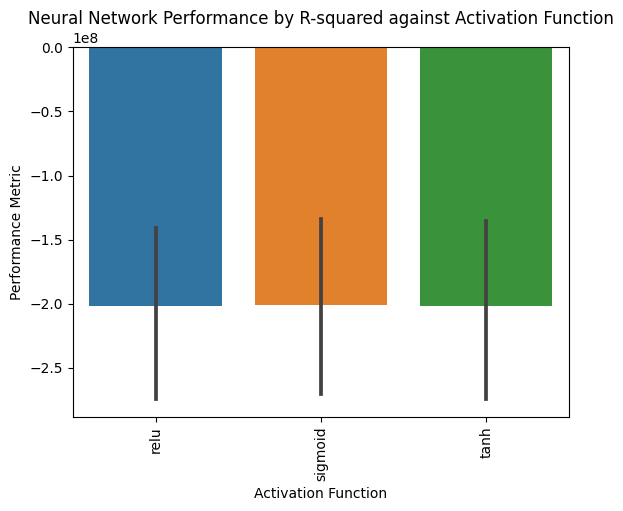

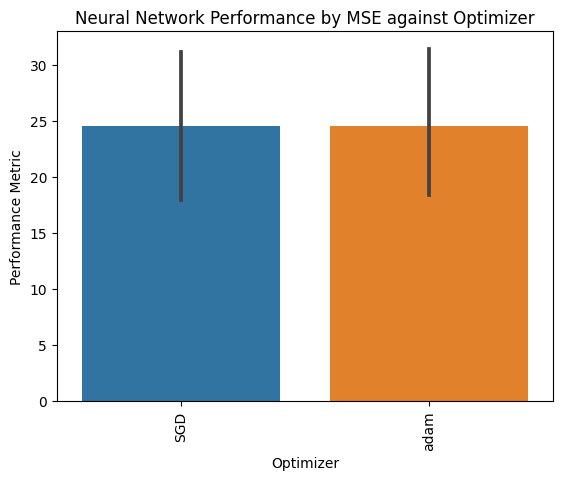

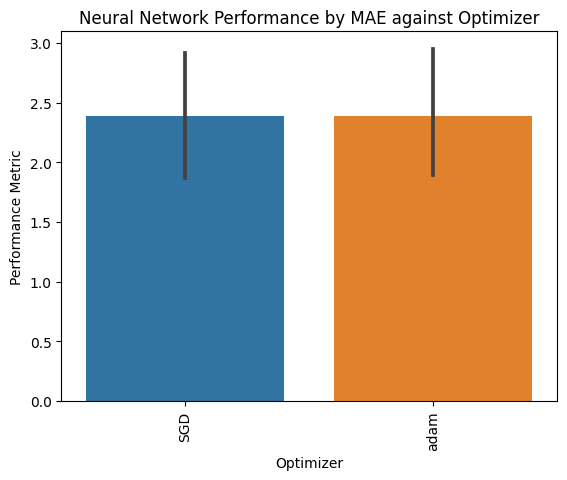

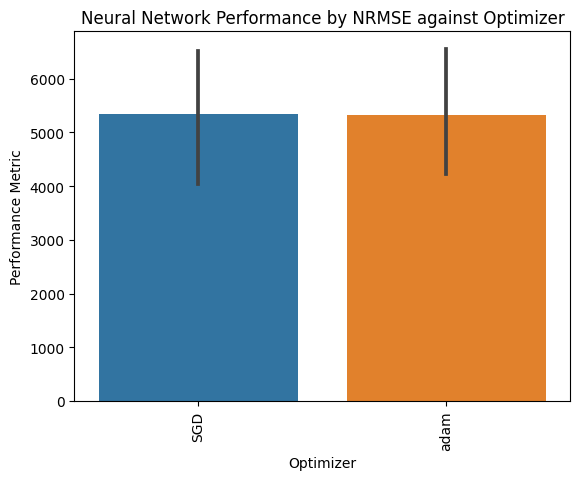

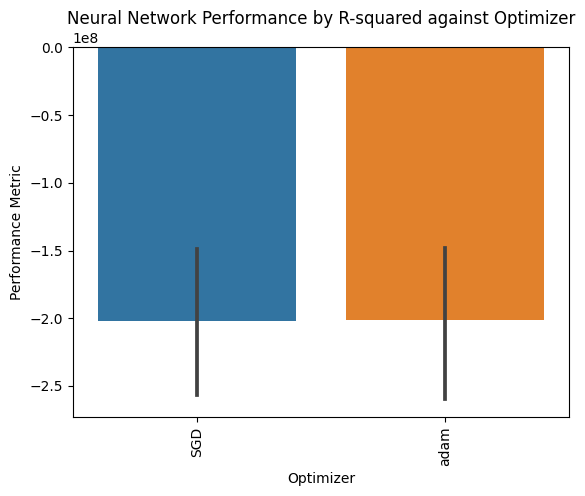

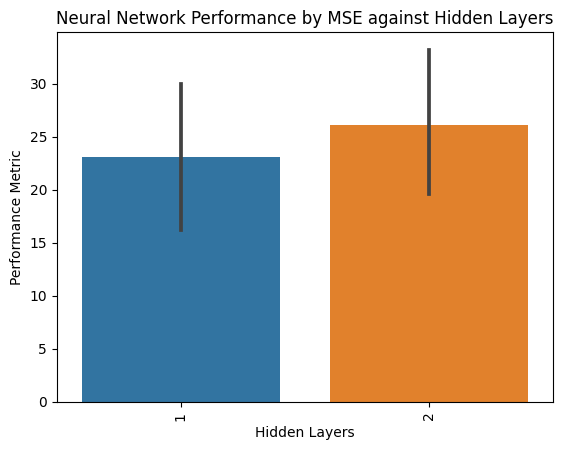

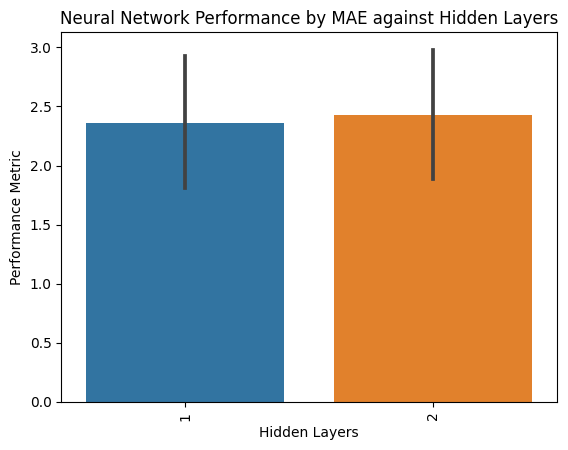

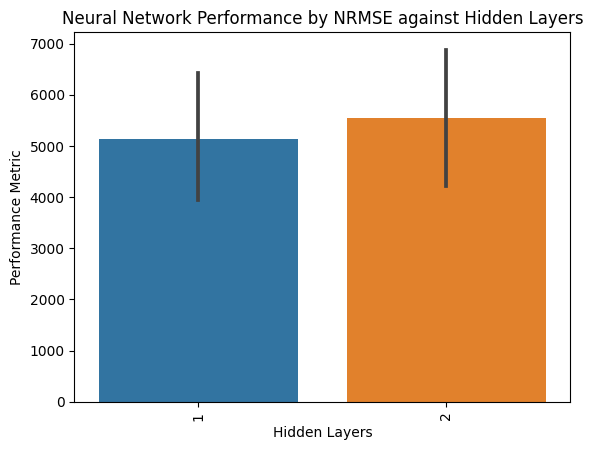

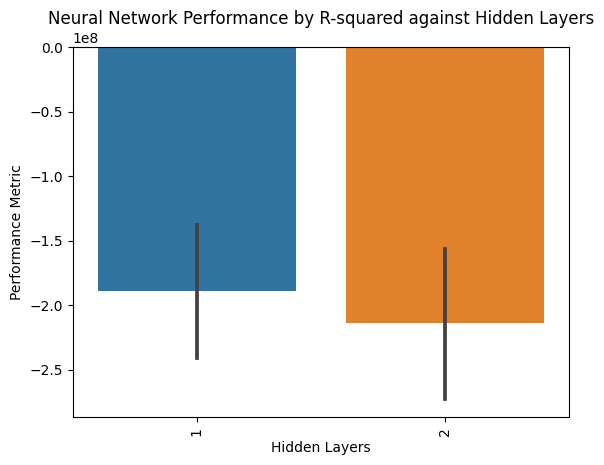

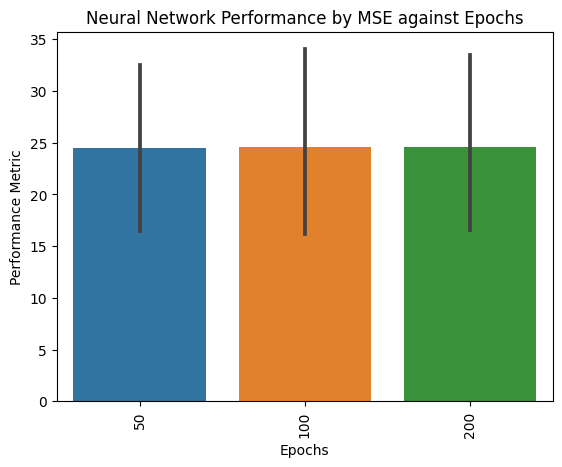

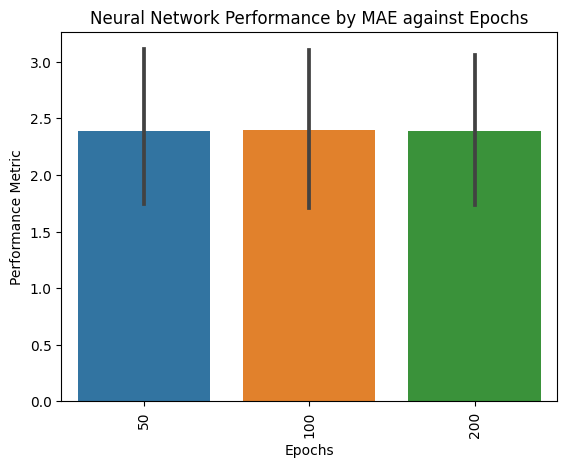

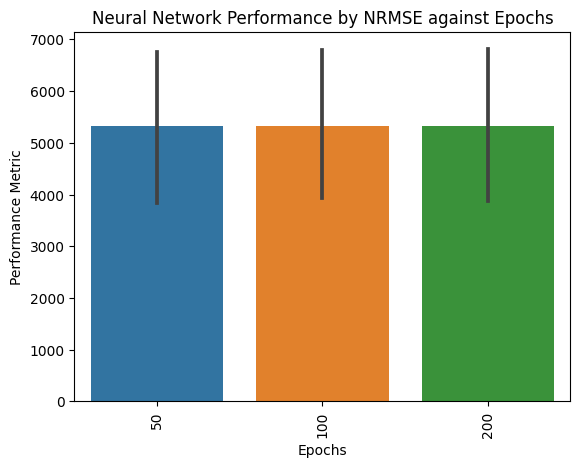

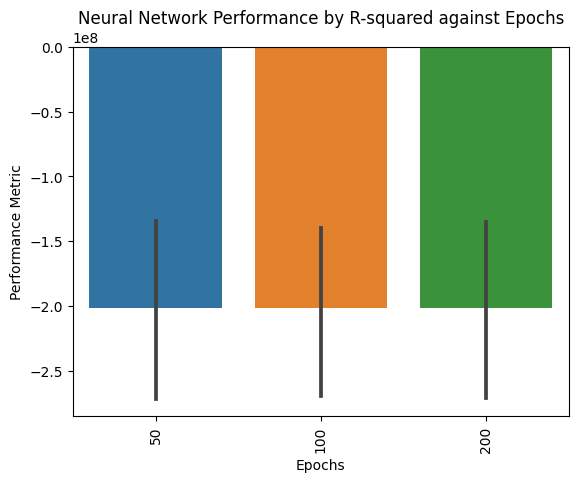

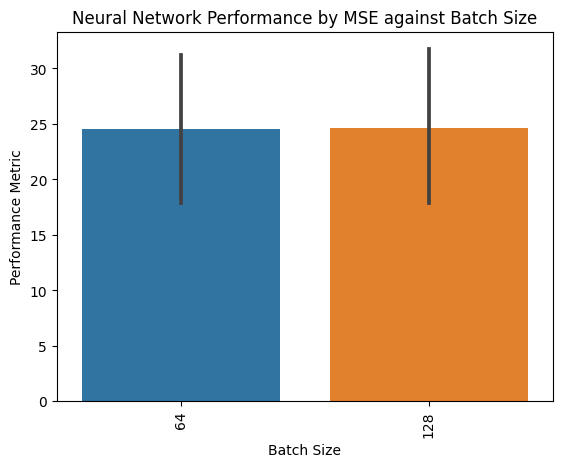

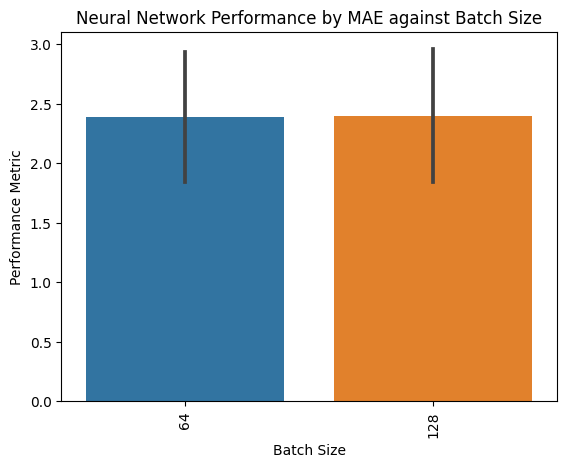

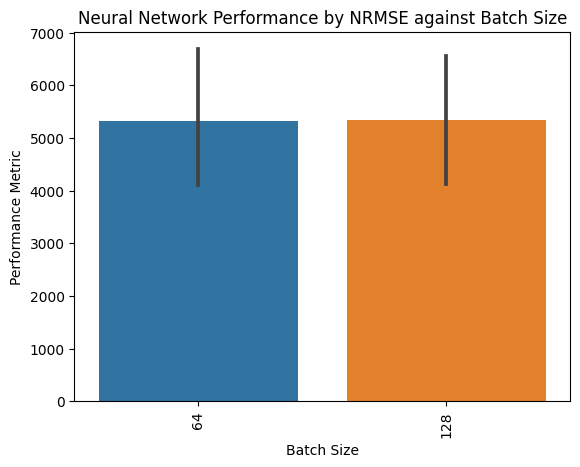

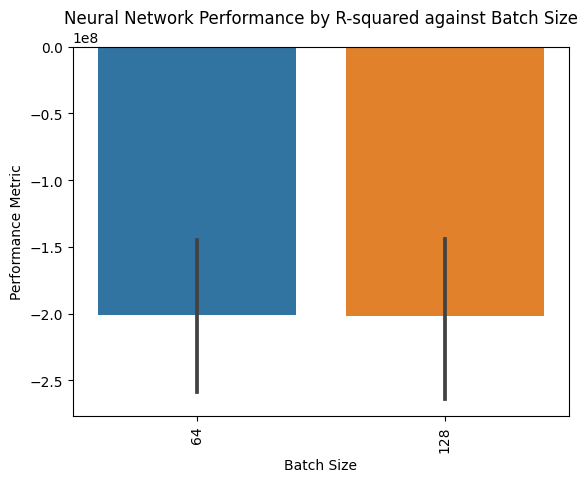

In [48]:
nn_pca13_results_injury_rate_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Injury Rate"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_injury_rate_df, x_metric, y_metric)

In [49]:
print_overall_nn_min_stats(nn_pca13_results_injury_rate_df, 'Neural Network (PCA n = 13) Injury Rate Performance')

Neural Network (PCA n = 13) Injury Rate Performance
Model                       576
Target                      576
Loss Function               720
Activation Function         576
Optimizer                   576
Hidden Layers               576
Epochs                      576
Batch Size                  576
Neurons per hidden layer    576
MSE                         677
MAE                         689
NRMSE                       677
R-squared                   585
dtype: int64 



In [50]:
nn_pca13_results_df.iloc[[677]]

Model       Target        Loss Function  \
677  Neural Network (PCA n = 13)  Injury Rate  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
677             sigmoid       SGD              1     200         128   

     Neurons per hidden layer       MSE       MAE       NRMSE    R-squared  
677                        32  0.037936  0.138176  360.976593 -311529.3039

In [50]:
def optimised_nn_pca13_injury_rate_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='sigmoid'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='SGD')
    model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)
    model.save('nn_pca13_injury_rate_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_injury_rate_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Injury Rate')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Injury Rate', mse, mae, nrmse, r2)

Training Loss: 8.066550254821777
15/15 [==============================] - 0s 1ms/step
Neural Network (PCA n = 13) Performance for Injury Rate:
MSE: 0.011076030894965014
MAE: 0.08036902550347022
NRMSE: 1.42365476940974
R-squared: -90956.11319985466 



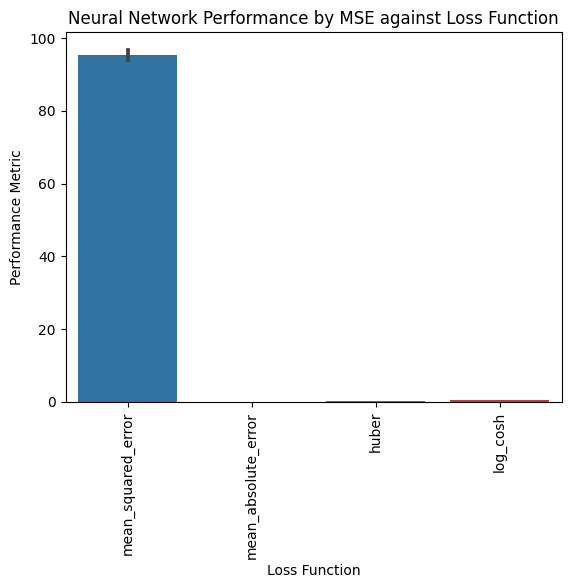

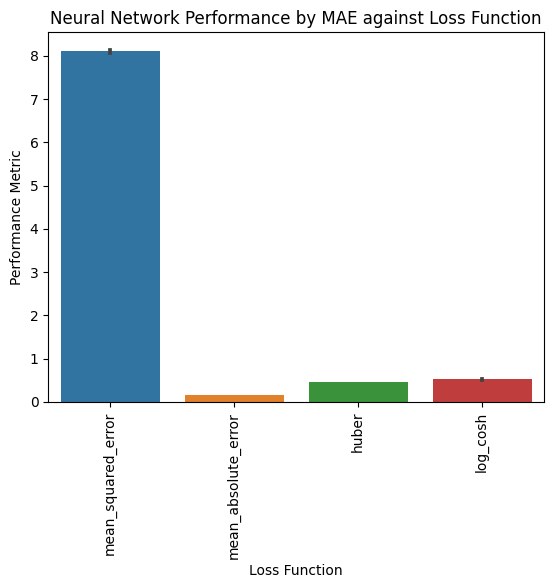

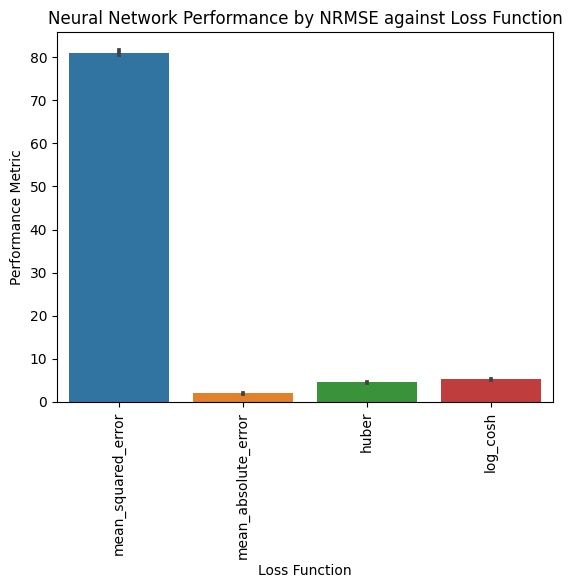

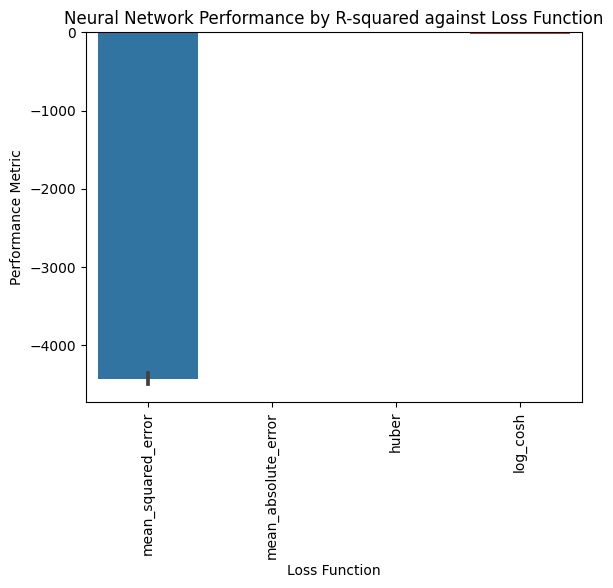

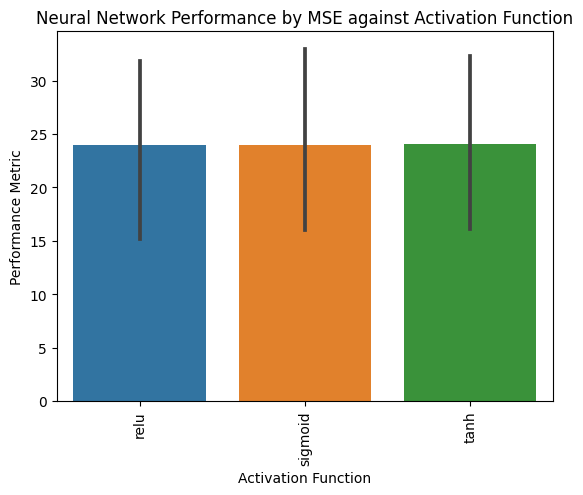

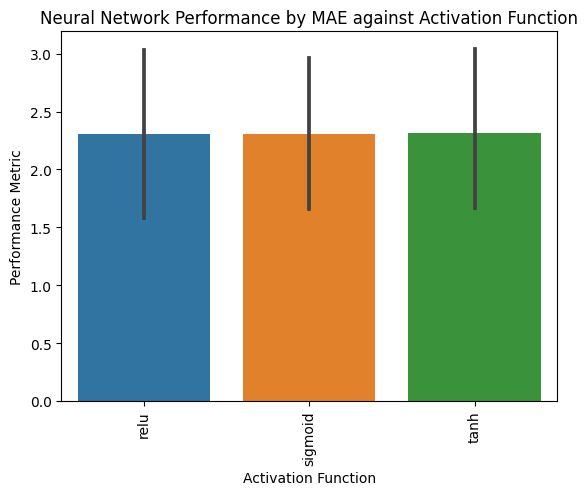

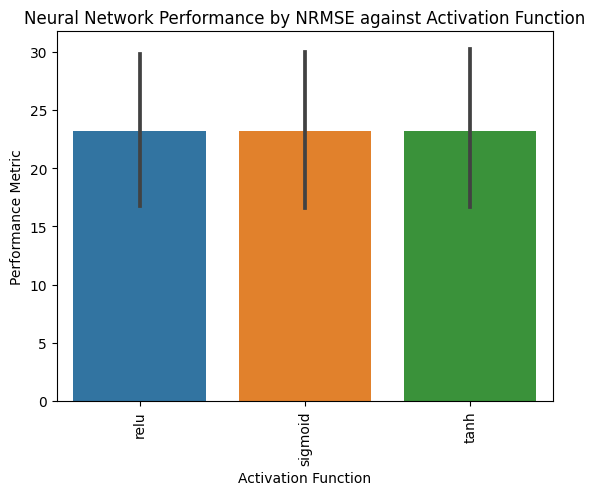

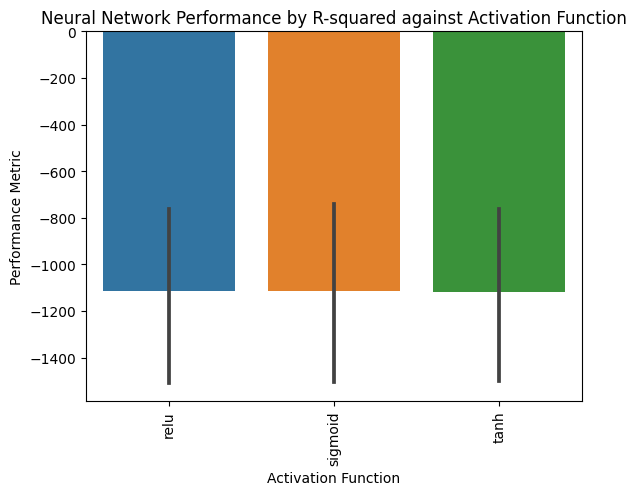

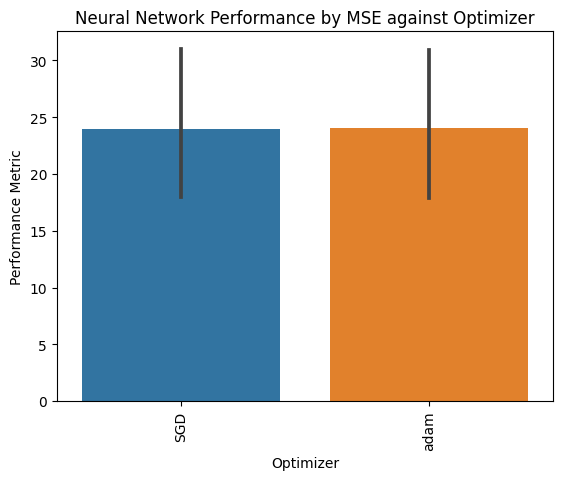

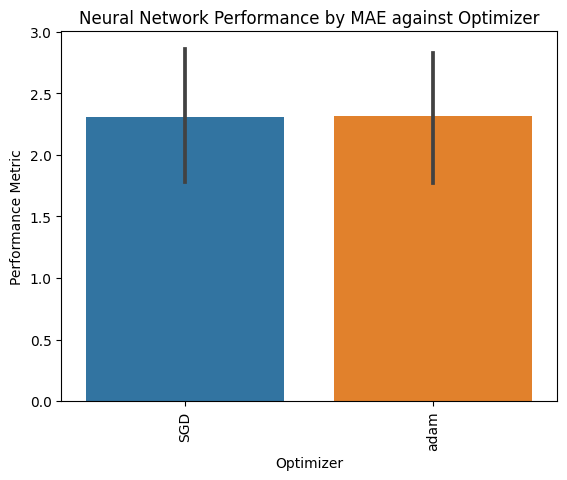

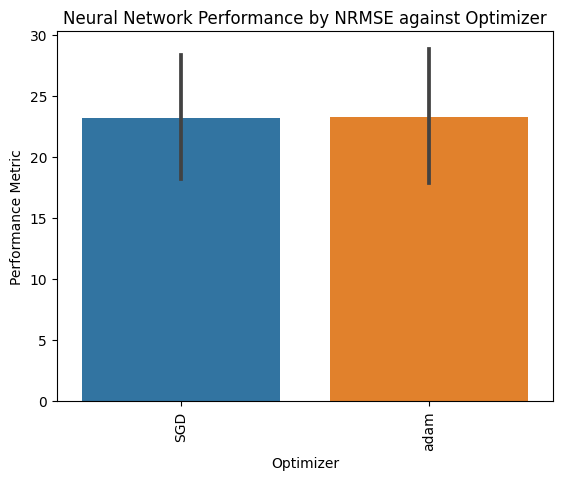

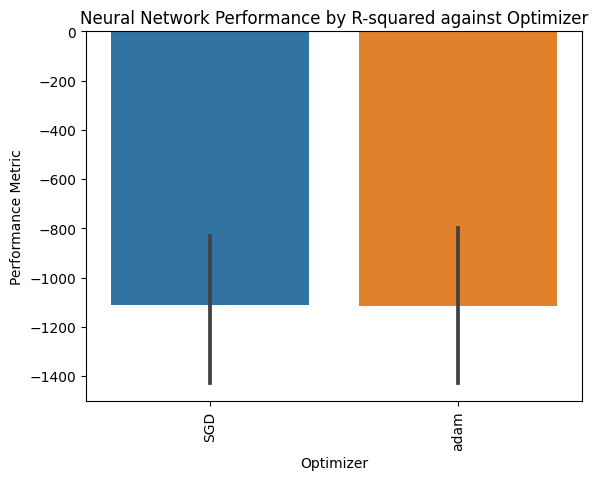

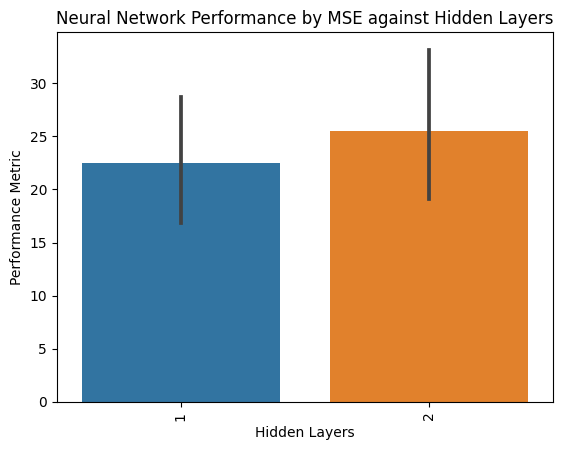

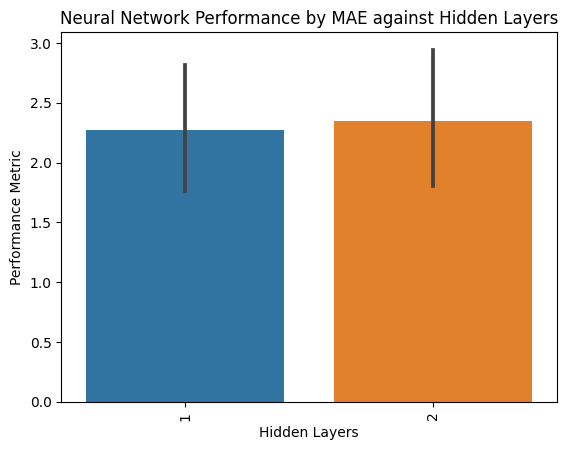

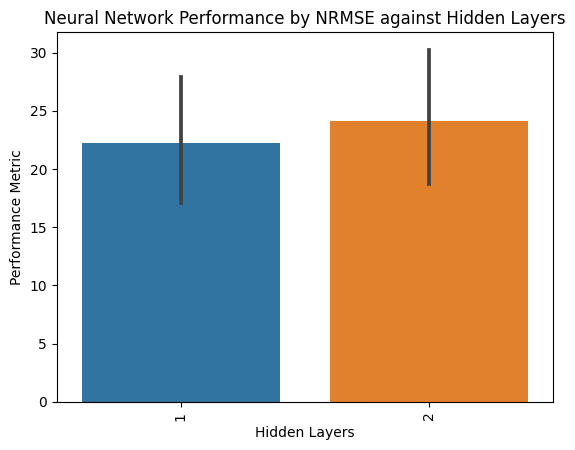

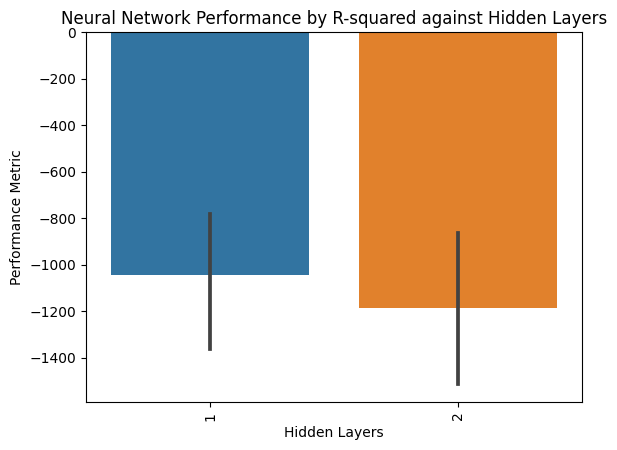

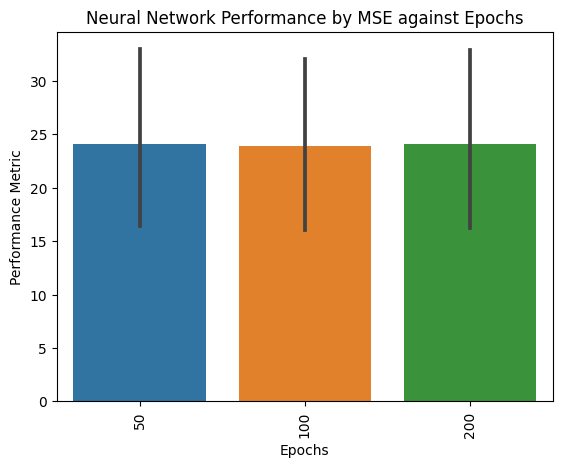

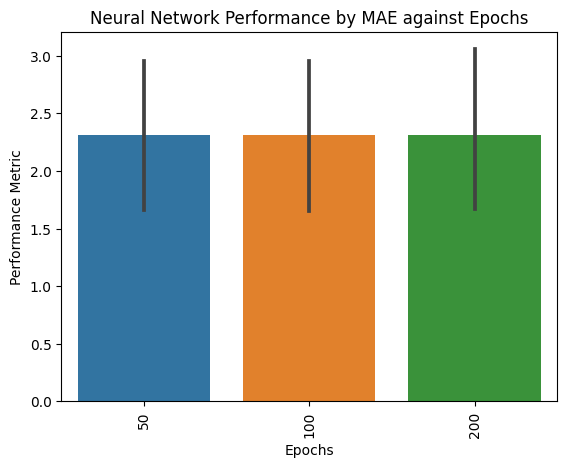

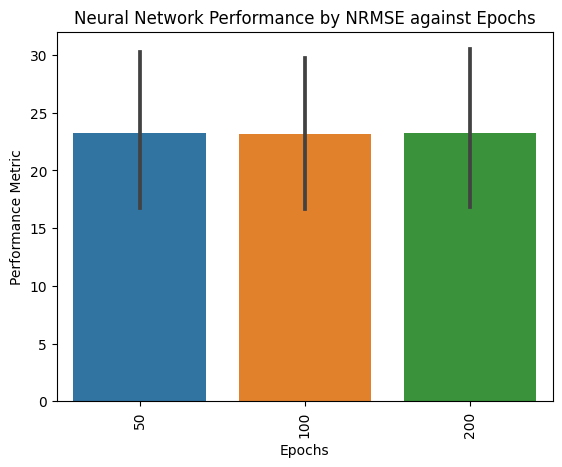

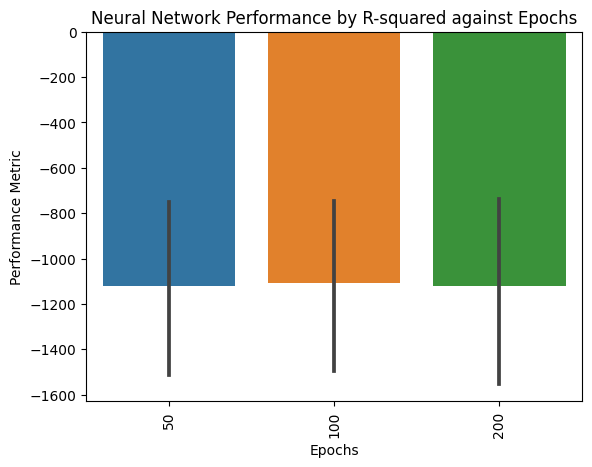

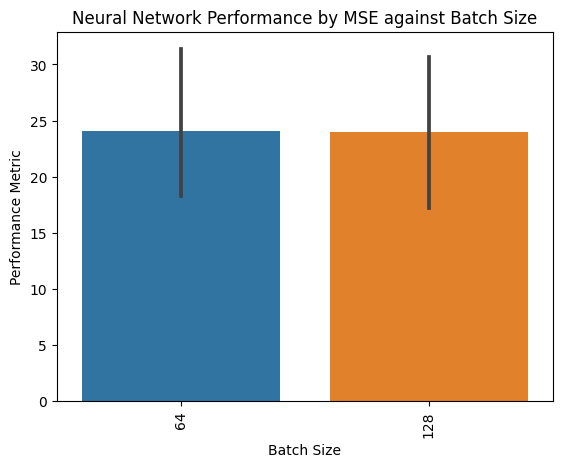

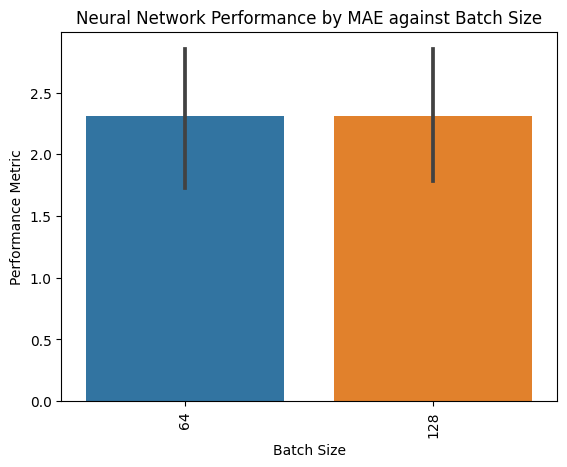

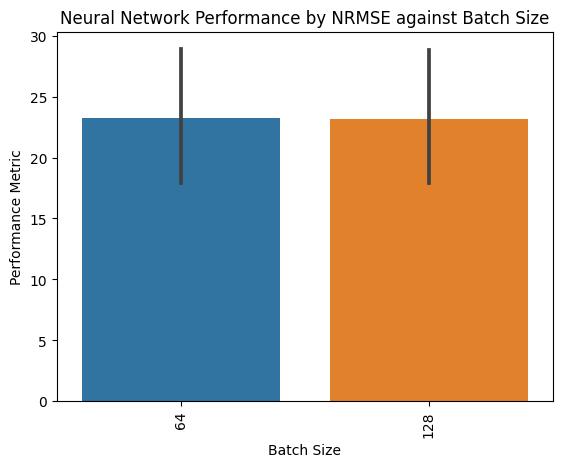

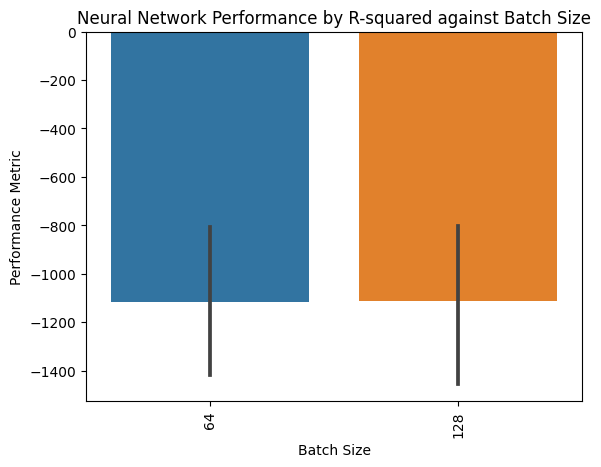

In [52]:
nn_pca13_results_avg_injury_cost_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Average Injury Cost"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_avg_injury_cost_df, x_metric, y_metric)

In [53]:
print_overall_nn_min_stats(nn_pca13_results_avg_injury_cost_df, 'Neural Network (PCA n = 13) Average Injury Cost Performance')

Neural Network (PCA n = 13) Average Injury Cost Performance
Model                       288
Target                      288
Loss Function               432
Activation Function         288
Optimizer                   288
Hidden Layers               288
Epochs                      288
Batch Size                  288
Neurons per hidden layer    288
MSE                         377
MAE                         411
NRMSE                       377
R-squared                   310
dtype: int64 



In [54]:
nn_pca13_results_df.iloc[[377]]

Model               Target        Loss Function  \
377  Neural Network (PCA n = 13)  Average Injury Cost  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
377                relu      adam              1     200         128   

     Neurons per hidden layer       MSE       MAE    NRMSE  R-squared  
377                        32  0.029009  0.123165  1.41496  -0.346792

In [51]:
def optimised_nn_pca13_avg_injury_cost_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)
    model.save('nn_pca13_avg_injury_cost_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_avg_injury_cost_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Average Injury Cost')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Average Injury Cost', mse, mae, nrmse, r2)

Training Loss: 8.029675483703613
15/15 [==============================] - 0s 2ms/step
Neural Network (PCA n = 13) Performance for Average Injury Cost:
MSE: 0.08365956020323737
MAE: 0.1995043352318518
NRMSE: 1.0592740999812669
R-squared: -2.884082606244397 



# Comparing the performance of different models
Now that we have several models, we can compare the performance of these models by plotting a graph of Evaluation Metrics against Model, for each target that we are trying to predict.

In [52]:
eval_metrics_df = pd.DataFrame(evaluation_metrics)
eval_metrics_df.to_csv('model_performance.csv', index = False)

In [42]:
def plot_model_comparison(df, x, target):
    """
    Plots the performance of different models for a specific target variable.

    Args:
    df: DataFrame containing model performance metrics.
    target: Target variable to focus on.
    """

    # Filter data for the specified target
    target_df = df[df['Target'] == target]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y='Model', data=target_df, orient='h')
    plt.title(f'Model Performance by {target}')
    plt.xlabel(f'{x}')
    plt.ylabel('Model')
    plt.show()


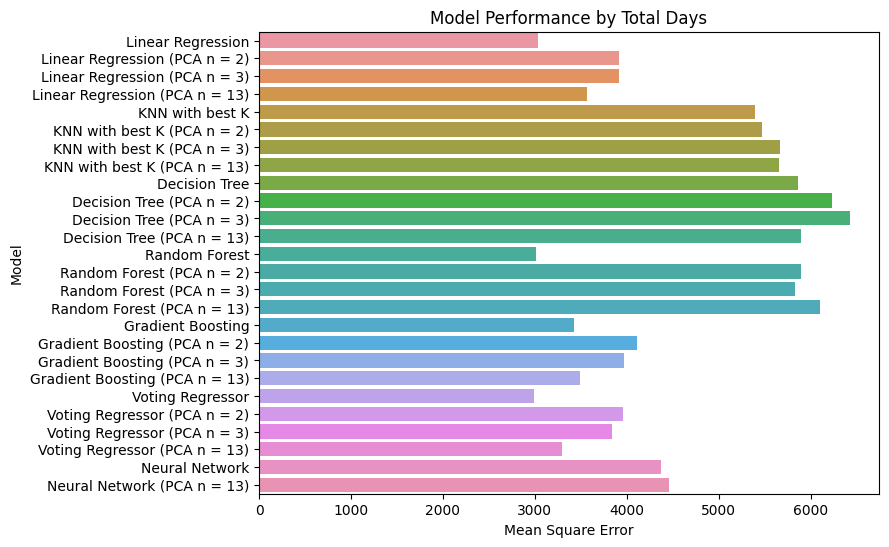

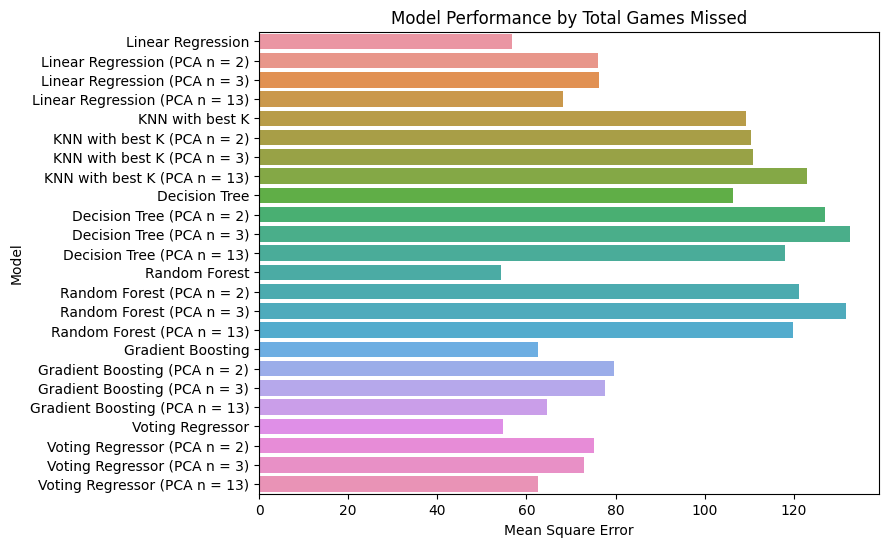

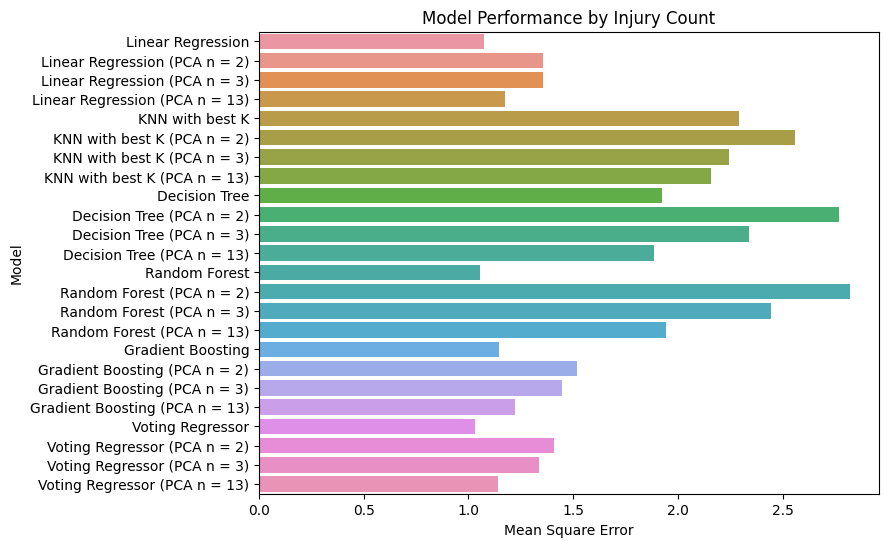

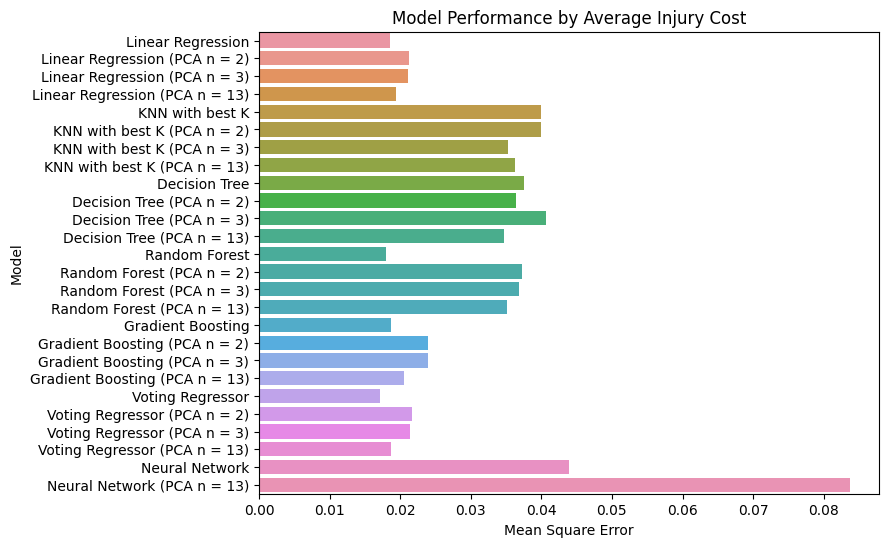

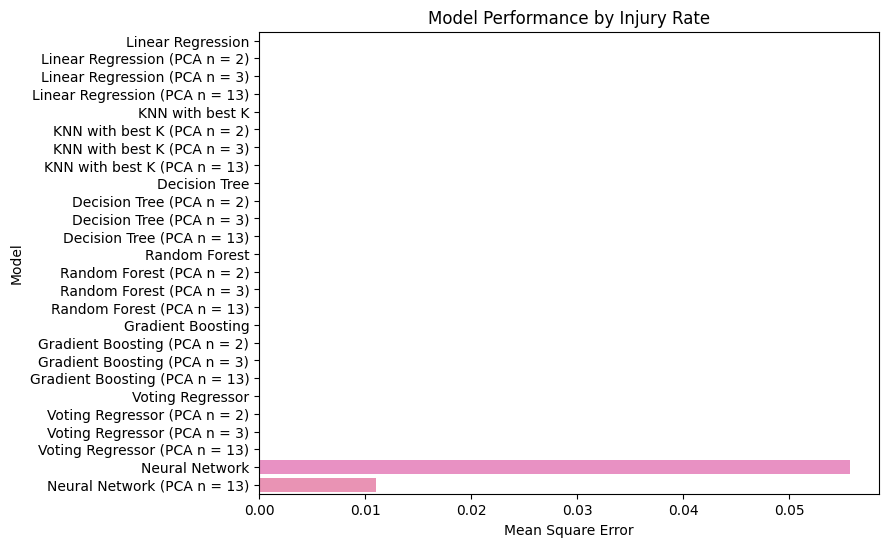

In [53]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Square Error', target)

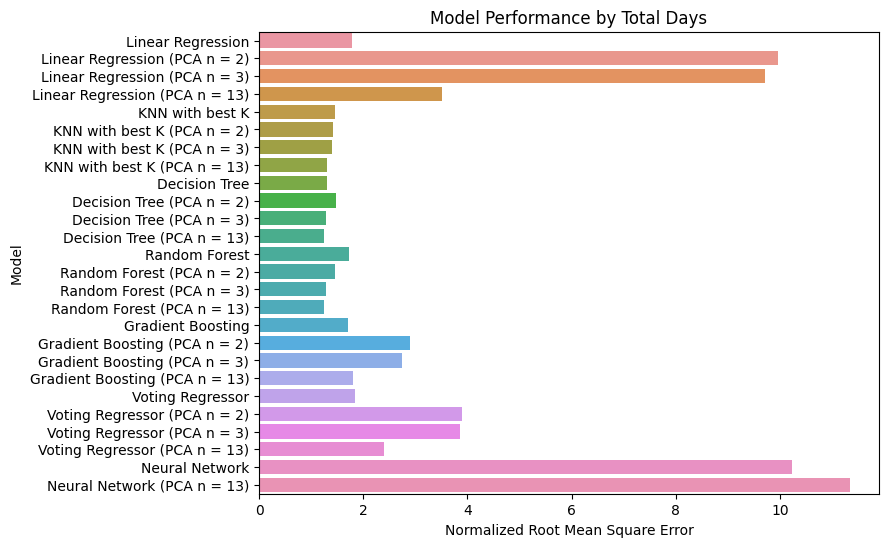

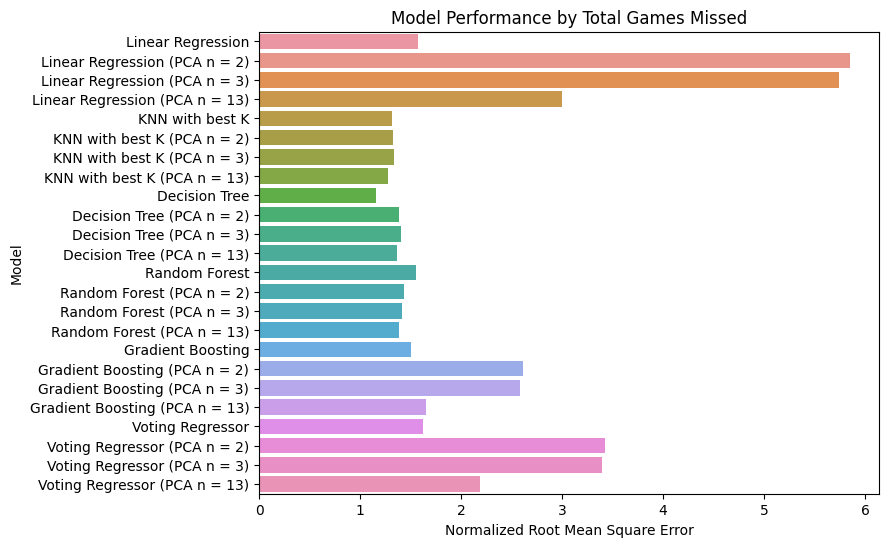

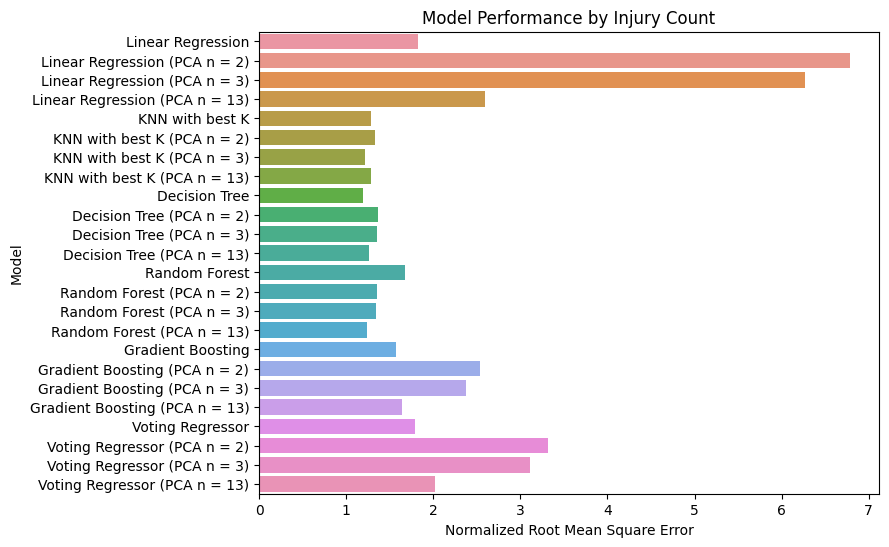

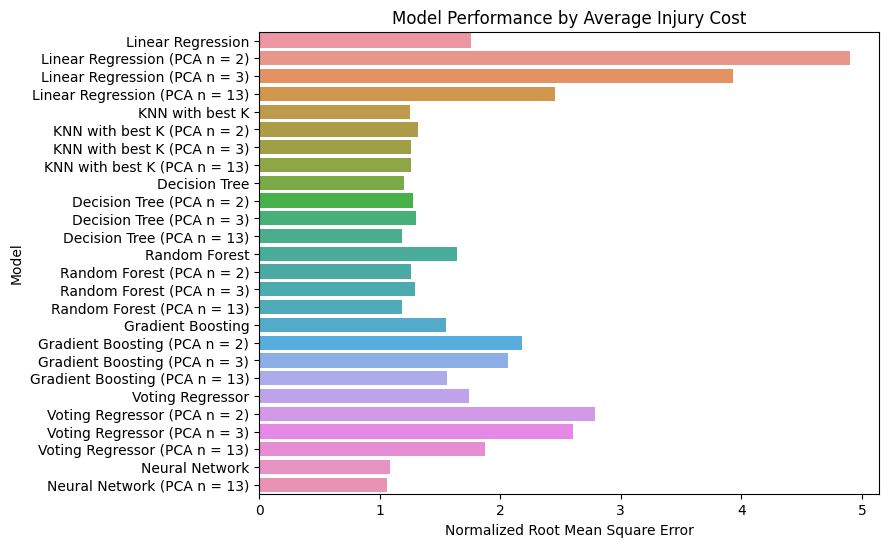

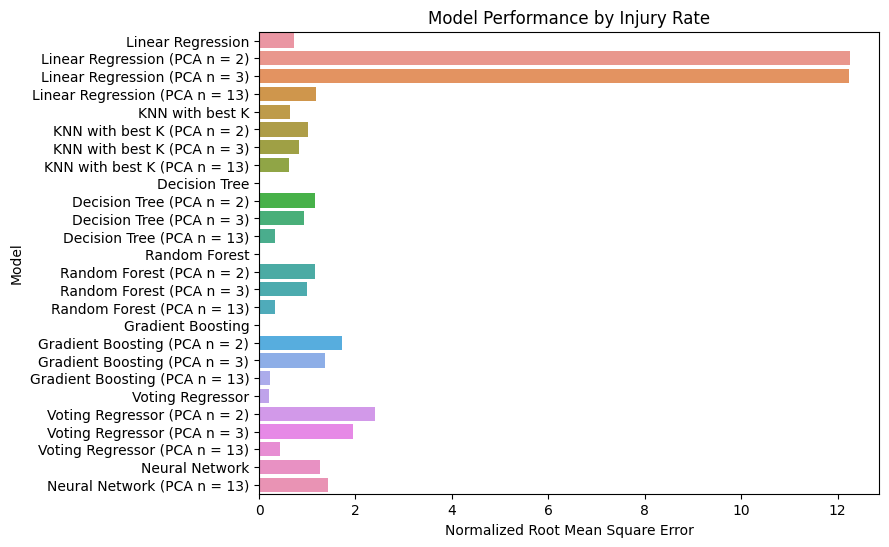

In [54]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Normalized Root Mean Square Error', target)

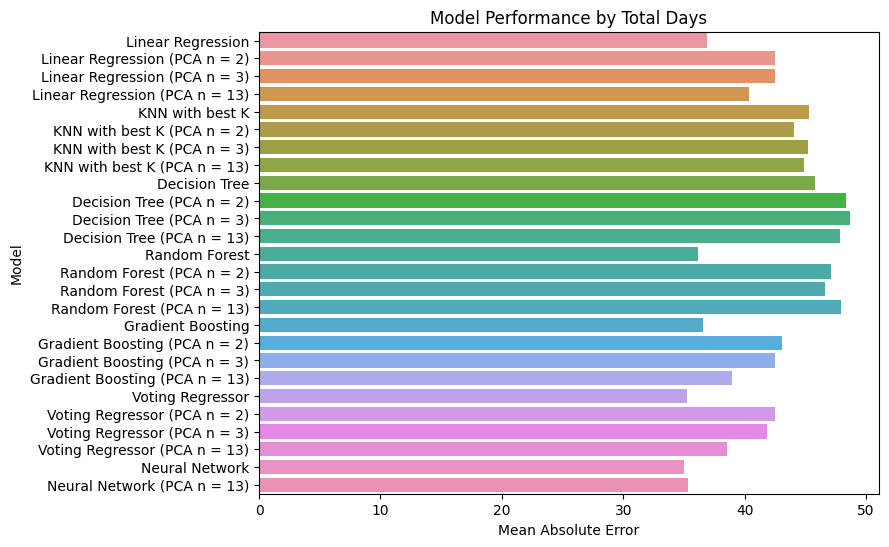

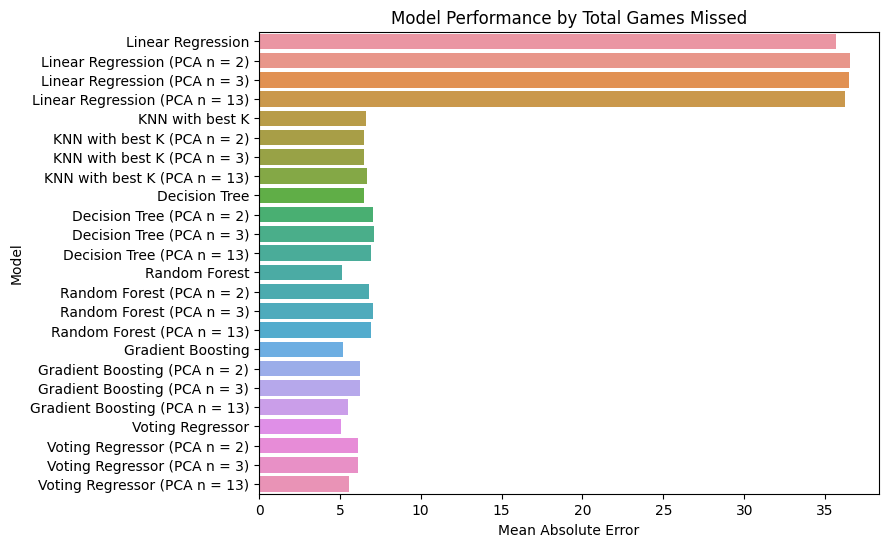

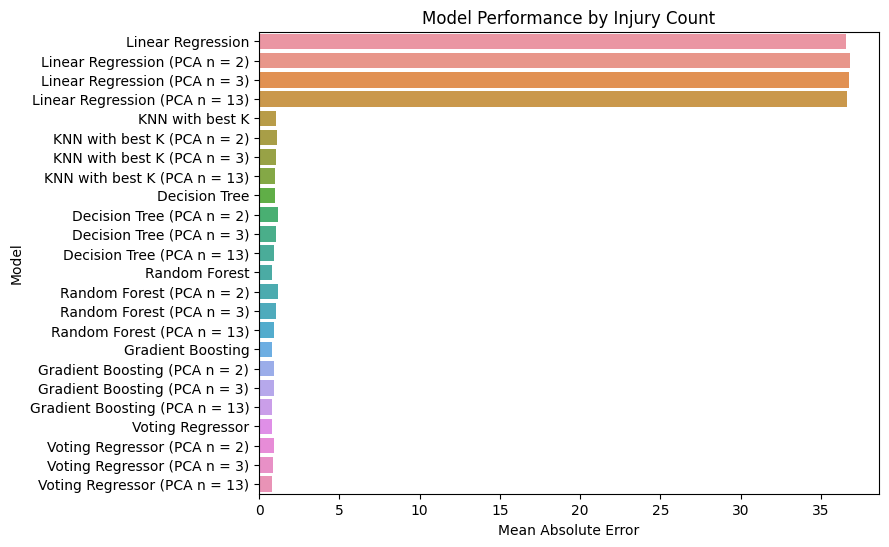

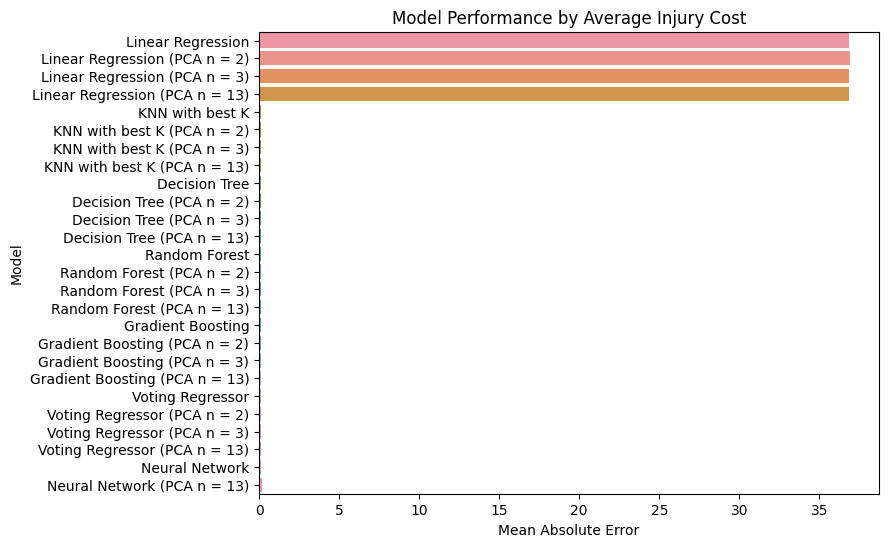

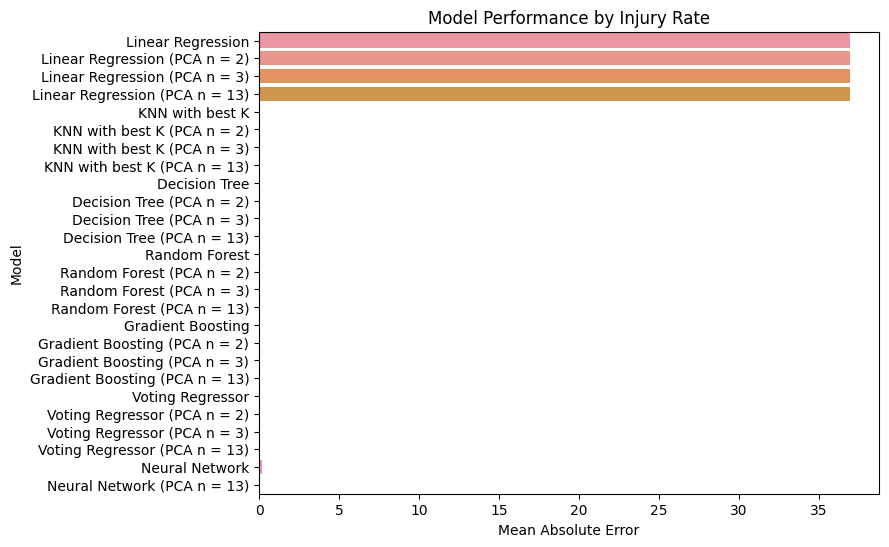

In [55]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Absolute Error', target)

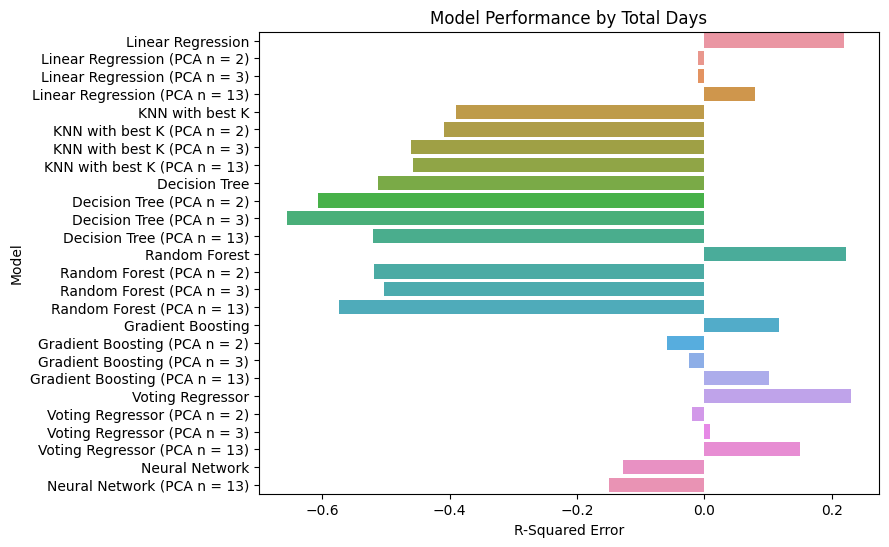

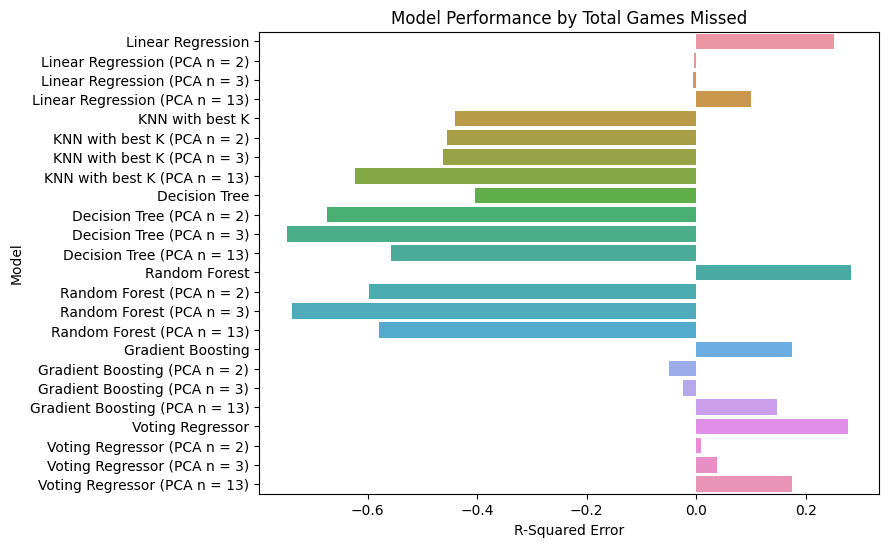

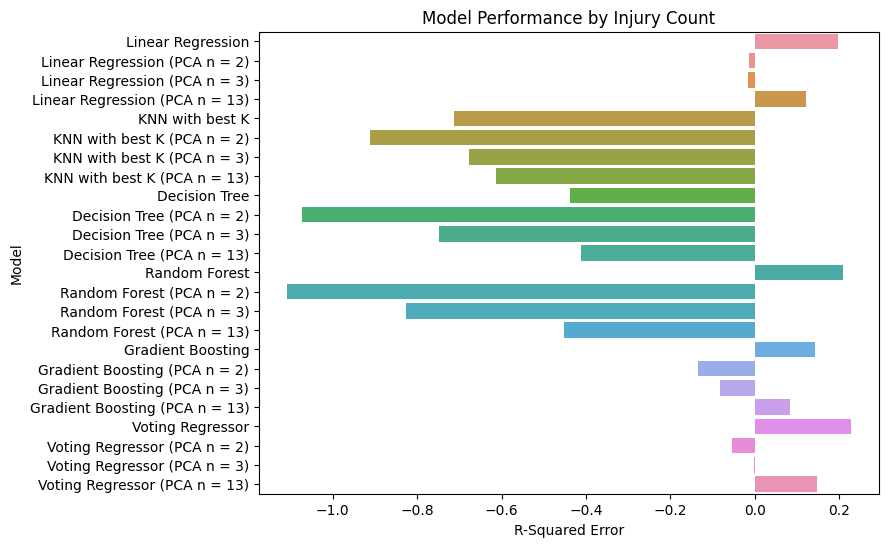

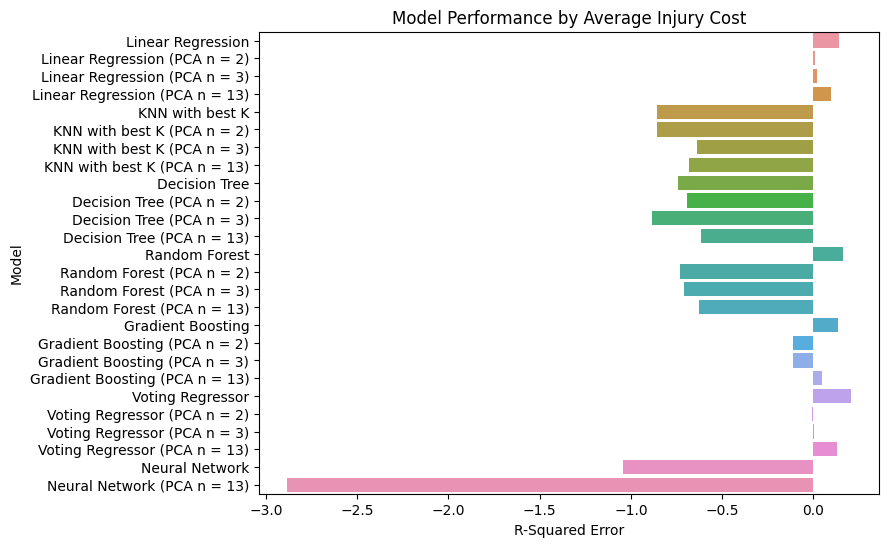

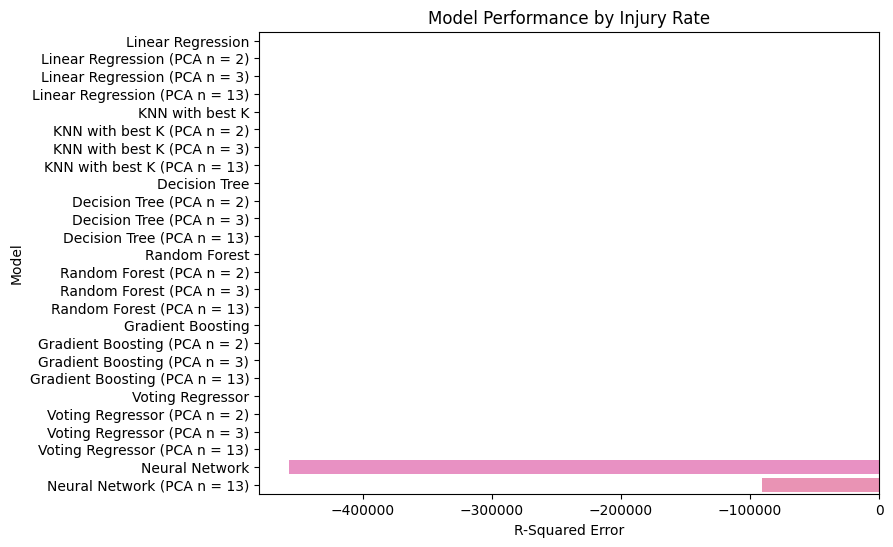

In [56]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'R-Squared Error', target)